In [1]:
import os
#os.environ["CUDA_VISIBLE_DEVICES"]="0" #for GPU usage
#import matplotlib as mpl
#mpl.use('Agg')
import numpy as np
from keras.layers import Input, Dense, Flatten, Reshape, Softmax
from keras.layers import Conv1D, MaxPooling1D, UpSampling1D
from keras.models import Model
from keras import backend as K
from keras import callbacks, optimizers
from keras.utils import multi_gpu_model
import tensorflow as tf

import DataPreprocessing as DP
from matplotlib import pyplot as plt
from astropy.io import fits
#from skimage import exposure
#------------------------------------------------------------------------#
import time
Tstart = time.time() #Timer start

In [2]:
# 使用第一张与第三张GPU卡
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
# gpus = tf.config.experimental.list_physical_devices(device_type='XLA_GPU')
# #cpus = tf.config.experimental.list_physical_devices(device_type='CPU')
# print(gpus[1])
# tf.config.experimental.set_visible_devices(devices=gpus[1], device_type='XLA_GPU')

In [3]:
input_spe = Input(shape=(1,4552))
input_spe.shape

TensorShape([None, 1, 4552])

In [4]:
x = Conv1D(64, 16, activation='relu', padding='same')(input_spe)#(1*64)
x = Conv1D(64, 16, activation='relu', padding='same')(x)#(1*64)
x = MaxPooling1D(4, padding='same')(x)#(1*64)
x = Conv1D(64, 16, activation='relu', padding='same')(x)#(1*64)
x = Conv1D(32, 16, activation='relu', padding='same')(x)#(1*32)
x = MaxPooling1D(4, padding='same')(x)#(1*32)
x = Dense(1024,activation='relu')(x)
output = Dense(4552,activation='softmax')(x)

In [5]:
autoencoder = Model(input_spe, output)
#autoencoder = multi_gpu_model(input_spe, decoded)
optimizer_adam = optimizers.Adam(lr=0.001)
autoencoder.compile(optimizer=optimizer_adam, loss='categorical_crossentropy', metrics=['accuracy'])####loss function
#autoencoder.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(autoencoder.summary())

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1, 4552)]         0         
_________________________________________________________________
conv1d (Conv1D)              (None, 1, 64)             4661312   
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1, 64)             65600     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 1, 64)             0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 1, 64)             65600     
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 1, 32)             32800     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 1, 32)             0     

In [6]:
#Dataset
#norm spectrum
kinds = ['boss_cv','boss_da+ms','boss_db','boss_db+ms','boss_dq','boss_dz','fgkm','hotstars','wd','wdsb2','yso','hotstars_m']
flux_cv, spectrum_cv = DP.Preprocessing7('/home/njl/ML/optical/'+kinds[0]+'/'+'*.fit')
flux_dams, spectrum_dams = DP.Preprocessing7('/home/njl/ML/optical/'+kinds[1]+'/'+'*.fit')
flux_db, spectrum_db = DP.Preprocessing7('/home/njl/ML/optical/'+kinds[2]+'/'+'*.fit')

#delate bad data
n = 0
for i in range(len(spectrum_db)):
    if len(spectrum_db[i][0]) < 4096:
        n = i
flux_db.pop(n)
spectrum_db.pop(n)

[array([5282.0195, 5283.235 , 5284.453 , 5285.669 , 5286.8877, 5288.104 ,
        5289.323 , 5290.54  , 5291.7573, 5292.9775, 5294.1953, 5295.416 ,
        5296.6343, 5297.8555, 5299.074 , 5300.2935, 5301.5156, 5302.7354,
        5303.958 , 5305.178 , 5306.4014, 5307.622 , 5308.8433, 5310.0674,
        5311.289 , 5312.5137, 5313.736 , 5314.9614, 5316.184 , 5317.407 ,
        5318.6333, 5319.857 , 5321.0835, 5322.3076, 5323.5347, 5324.76  ,
        5325.9844, 5327.213 , 5328.438 , 5329.667 , 5330.893 , 5332.122 ,
        5333.349 , 5334.5757, 5335.806 , 5337.0337, 5338.264 , 5339.492 ,
        5340.7236, 5341.952 , 5343.181 , 5344.413 , 5345.6426, 5346.8755,
        5348.1055, 5349.339 , 5350.5693, 5351.8003, 5353.034 , 5354.2656,
        5355.5005, 5356.7324, 5357.968 , 5359.2   , 5360.433 , 5361.6694,
        5362.903 , 5364.139 , 5365.3735, 5366.611 , 5367.845 , 5369.08  ,
        5370.3184, 5371.5537, 5372.7925, 5374.0283, 5375.2676, 5376.504 ,
        5377.744 , 5378.981 , 5380.218

In [7]:
#input spectrum
l_list =  flux_cv+flux_dams+flux_db+flux_cv+flux_dams+flux_db+flux_cv+flux_dams+flux_db+flux_cv+flux_dams+flux_db+flux_cv+flux_dams+flux_db+flux_cv+flux_dams+flux_db+flux_cv+flux_dams+flux_db+flux_cv+flux_dams+flux_db
sl = []
for i in range(len(l_list)):
    sl.append(len(l_list[i]))
sl_min = np.min(sl)
X_train = []
for i in range(len(l_list)):
    X_train.append(l_list[i][0:sl_min])
X_train = np.array(X_train)
size = 4552
#X_train = l_list
X_train = np.stack(X_train)
#X_train = X_train.reshape(len(X_train),size,1) #change the shape to NHWC for CAE input
X_train = X_train.reshape(len(X_train),1,size)#(1214,1,4552)
print(X_train.shape) #print information of training samples

(9712, 1, 4552)


In [8]:
Nepochs = 3*10**4 #number of epochs for CAE training
tosavemodel = True #if save the trained CAE model
plot_reconstruction = True #if plot the reconstruction comparison
 #setup if "tosavemodel=True" or "plot_reconstuction=True"

In [9]:
Tprocess0 = time.time()
print('\n', '## DATE PREPARATION RUNTIME:', Tprocess0-Tstart) #Timer

## MAIN ##
#training
H = autoencoder.fit(X_train, X_train,
                    batch_size = 512,
                    epochs=Nepochs,
                    verbose=2,
                    shuffle=True)

Tprocess1 = time.time()
print('\n', '## AE TRAINING RUNTIME:', Tprocess1-Tprocess0) #Timer


 ## DATE PREPARATION RUNTIME: 40.64416837692261
Epoch 1/30000
19/19 - 1s - loss: 34840.4844 - accuracy: 0.0067
Epoch 2/30000
19/19 - 0s - loss: 33245.3164 - accuracy: 0.0130
Epoch 3/30000
19/19 - 0s - loss: 32722.1973 - accuracy: 0.0227
Epoch 4/30000
19/19 - 0s - loss: 32371.0938 - accuracy: 0.0398
Epoch 5/30000
19/19 - 0s - loss: 32118.7734 - accuracy: 0.0566
Epoch 6/30000
19/19 - 0s - loss: 31863.8359 - accuracy: 0.0728
Epoch 7/30000
19/19 - 0s - loss: 31707.6797 - accuracy: 0.0852
Epoch 8/30000
19/19 - 1s - loss: 31572.1523 - accuracy: 0.0936
Epoch 9/30000
19/19 - 0s - loss: 31435.8457 - accuracy: 0.1054
Epoch 10/30000
19/19 - 0s - loss: 31358.4180 - accuracy: 0.1096
Epoch 11/30000
19/19 - 0s - loss: 31278.4277 - accuracy: 0.1137
Epoch 12/30000
19/19 - 0s - loss: 31210.6562 - accuracy: 0.1147
Epoch 13/30000
19/19 - 0s - loss: 31132.4121 - accuracy: 0.1208
Epoch 14/30000
19/19 - 0s - loss: 31064.8301 - accuracy: 0.1312
Epoch 15/30000
19/19 - 0s - loss: 30996.2109 - accuracy: 0.1323


Epoch 128/30000
19/19 - 0s - loss: 30244.9922 - accuracy: 0.2188
Epoch 129/30000
19/19 - 0s - loss: 30241.5645 - accuracy: 0.2228
Epoch 130/30000
19/19 - 0s - loss: 30232.7910 - accuracy: 0.2196
Epoch 131/30000
19/19 - 0s - loss: 30227.9629 - accuracy: 0.2245
Epoch 132/30000
19/19 - 0s - loss: 30278.4746 - accuracy: 0.2062
Epoch 133/30000
19/19 - 0s - loss: 30339.2520 - accuracy: 0.2001
Epoch 134/30000
19/19 - 0s - loss: 30356.2402 - accuracy: 0.1965
Epoch 135/30000
19/19 - 0s - loss: 30352.2891 - accuracy: 0.1994
Epoch 136/30000
19/19 - 0s - loss: 30320.3750 - accuracy: 0.2045
Epoch 137/30000
19/19 - 0s - loss: 30313.6211 - accuracy: 0.2105
Epoch 138/30000
19/19 - 0s - loss: 30283.2559 - accuracy: 0.2247
Epoch 139/30000
19/19 - 0s - loss: 30271.1230 - accuracy: 0.2316
Epoch 140/30000
19/19 - 0s - loss: 30263.0469 - accuracy: 0.2325
Epoch 141/30000
19/19 - 0s - loss: 30256.5605 - accuracy: 0.2397
Epoch 142/30000
19/19 - 0s - loss: 30253.3613 - accuracy: 0.2439
Epoch 143/30000
19/19 - 0

19/19 - 0s - loss: 30125.1406 - accuracy: 0.2857
Epoch 255/30000
19/19 - 0s - loss: 30122.8438 - accuracy: 0.2841
Epoch 256/30000
19/19 - 0s - loss: 30126.2480 - accuracy: 0.2781
Epoch 257/30000
19/19 - 0s - loss: 30122.9492 - accuracy: 0.2855
Epoch 258/30000
19/19 - 0s - loss: 30124.5801 - accuracy: 0.2826
Epoch 259/30000
19/19 - 0s - loss: 30123.8652 - accuracy: 0.2811
Epoch 260/30000
19/19 - 0s - loss: 30120.7637 - accuracy: 0.2816
Epoch 261/30000
19/19 - 0s - loss: 30118.8203 - accuracy: 0.2900
Epoch 262/30000
19/19 - 0s - loss: 30119.4590 - accuracy: 0.2869
Epoch 263/30000
19/19 - 0s - loss: 30121.2910 - accuracy: 0.2810
Epoch 264/30000
19/19 - 0s - loss: 30120.6719 - accuracy: 0.2848
Epoch 265/30000
19/19 - 0s - loss: 30119.2812 - accuracy: 0.2867
Epoch 266/30000
19/19 - 0s - loss: 30117.5977 - accuracy: 0.2890
Epoch 267/30000
19/19 - 0s - loss: 30123.1855 - accuracy: 0.2843
Epoch 268/30000
19/19 - 0s - loss: 30142.0137 - accuracy: 0.2710
Epoch 269/30000
19/19 - 0s - loss: 30145.

Epoch 381/30000
19/19 - 0s - loss: 30152.1055 - accuracy: 0.2946
Epoch 382/30000
19/19 - 0s - loss: 30153.8652 - accuracy: 0.2918
Epoch 383/30000
19/19 - 0s - loss: 30196.6660 - accuracy: 0.2627
Epoch 384/30000
19/19 - 0s - loss: 30223.5527 - accuracy: 0.2626
Epoch 385/30000
19/19 - 0s - loss: 30177.0352 - accuracy: 0.2732
Epoch 386/30000
19/19 - 0s - loss: 30151.0156 - accuracy: 0.2745
Epoch 387/30000
19/19 - 0s - loss: 30133.8887 - accuracy: 0.2815
Epoch 388/30000
19/19 - 0s - loss: 30122.0430 - accuracy: 0.3056
Epoch 389/30000
19/19 - 0s - loss: 30107.7891 - accuracy: 0.3149
Epoch 390/30000
19/19 - 0s - loss: 30104.2402 - accuracy: 0.3228
Epoch 391/30000
19/19 - 0s - loss: 30103.7324 - accuracy: 0.3124
Epoch 392/30000
19/19 - 0s - loss: 30089.4004 - accuracy: 0.3272
Epoch 393/30000
19/19 - 0s - loss: 30090.1445 - accuracy: 0.3314
Epoch 394/30000
19/19 - 0s - loss: 30087.2031 - accuracy: 0.3201
Epoch 395/30000
19/19 - 0s - loss: 30083.5957 - accuracy: 0.3333
Epoch 396/30000
19/19 - 0

19/19 - 0s - loss: 30034.2930 - accuracy: 0.3749
Epoch 508/30000
19/19 - 0s - loss: 30033.5156 - accuracy: 0.3790
Epoch 509/30000
19/19 - 0s - loss: 30034.7207 - accuracy: 0.3729
Epoch 510/30000
19/19 - 0s - loss: 30038.2402 - accuracy: 0.3660
Epoch 511/30000
19/19 - 0s - loss: 30037.9863 - accuracy: 0.3682
Epoch 512/30000
19/19 - 0s - loss: 30038.0723 - accuracy: 0.3642
Epoch 513/30000
19/19 - 0s - loss: 30039.0352 - accuracy: 0.3627
Epoch 514/30000
19/19 - 0s - loss: 30037.4824 - accuracy: 0.3692
Epoch 515/30000
19/19 - 0s - loss: 30039.7324 - accuracy: 0.3587
Epoch 516/30000
19/19 - 0s - loss: 30041.8613 - accuracy: 0.3478
Epoch 517/30000
19/19 - 0s - loss: 30044.0898 - accuracy: 0.3512
Epoch 518/30000
19/19 - 0s - loss: 30042.3027 - accuracy: 0.3567
Epoch 519/30000
19/19 - 0s - loss: 30041.0996 - accuracy: 0.3484
Epoch 520/30000
19/19 - 0s - loss: 30041.5430 - accuracy: 0.3513
Epoch 521/30000
19/19 - 0s - loss: 30042.9824 - accuracy: 0.3541
Epoch 522/30000
19/19 - 0s - loss: 30042.

Epoch 634/30000
19/19 - 0s - loss: 30189.6973 - accuracy: 0.3302
Epoch 635/30000
19/19 - 0s - loss: 30244.5469 - accuracy: 0.2941
Epoch 636/30000
19/19 - 0s - loss: 30209.4434 - accuracy: 0.2627
Epoch 637/30000
19/19 - 0s - loss: 30158.2109 - accuracy: 0.2958
Epoch 638/30000
19/19 - 0s - loss: 30105.7832 - accuracy: 0.3275
Epoch 639/30000
19/19 - 0s - loss: 30074.5137 - accuracy: 0.3468
Epoch 640/30000
19/19 - 0s - loss: 30066.9746 - accuracy: 0.3480
Epoch 641/30000
19/19 - 0s - loss: 30042.3789 - accuracy: 0.3662
Epoch 642/30000
19/19 - 0s - loss: 30032.2051 - accuracy: 0.3737
Epoch 643/30000
19/19 - 0s - loss: 30021.6543 - accuracy: 0.3854
Epoch 644/30000
19/19 - 0s - loss: 30015.9746 - accuracy: 0.4011
Epoch 645/30000
19/19 - 0s - loss: 30012.4980 - accuracy: 0.4011
Epoch 646/30000
19/19 - 0s - loss: 30011.4727 - accuracy: 0.4022
Epoch 647/30000
19/19 - 0s - loss: 30010.3320 - accuracy: 0.4090
Epoch 648/30000
19/19 - 0s - loss: 30010.1641 - accuracy: 0.4012
Epoch 649/30000
19/19 - 0

19/19 - 0s - loss: 29973.7129 - accuracy: 0.4090
Epoch 761/30000
19/19 - 0s - loss: 29973.2949 - accuracy: 0.3998
Epoch 762/30000
19/19 - 0s - loss: 29972.3203 - accuracy: 0.4127
Epoch 763/30000
19/19 - 0s - loss: 29970.7188 - accuracy: 0.4279
Epoch 764/30000
19/19 - 0s - loss: 29970.7773 - accuracy: 0.4241
Epoch 765/30000
19/19 - 0s - loss: 29973.3340 - accuracy: 0.3909
Epoch 766/30000
19/19 - 0s - loss: 29972.3301 - accuracy: 0.4082
Epoch 767/30000
19/19 - 0s - loss: 29970.5039 - accuracy: 0.4244
Epoch 768/30000
19/19 - 0s - loss: 29970.9727 - accuracy: 0.4216
Epoch 769/30000
19/19 - 0s - loss: 29971.1992 - accuracy: 0.4085
Epoch 770/30000
19/19 - 0s - loss: 29970.9590 - accuracy: 0.4180
Epoch 771/30000
19/19 - 0s - loss: 29972.6523 - accuracy: 0.4015
Epoch 772/30000
19/19 - 0s - loss: 29972.6035 - accuracy: 0.4085
Epoch 773/30000
19/19 - 0s - loss: 29977.9316 - accuracy: 0.3775
Epoch 774/30000
19/19 - 0s - loss: 29973.6309 - accuracy: 0.3991
Epoch 775/30000
19/19 - 0s - loss: 29974.

Epoch 887/30000
19/19 - 0s - loss: 29965.6797 - accuracy: 0.4006
Epoch 888/30000
19/19 - 0s - loss: 29963.7070 - accuracy: 0.4027
Epoch 889/30000
19/19 - 0s - loss: 29960.7012 - accuracy: 0.4312
Epoch 890/30000
19/19 - 0s - loss: 29960.5137 - accuracy: 0.4301
Epoch 891/30000
19/19 - 0s - loss: 29961.1309 - accuracy: 0.4105
Epoch 892/30000
19/19 - 0s - loss: 29959.8320 - accuracy: 0.4188
Epoch 893/30000
19/19 - 0s - loss: 29958.0820 - accuracy: 0.4391
Epoch 894/30000
19/19 - 0s - loss: 29956.6191 - accuracy: 0.4457
Epoch 895/30000
19/19 - 0s - loss: 29956.7734 - accuracy: 0.4460
Epoch 896/30000
19/19 - 0s - loss: 29959.7031 - accuracy: 0.4195
Epoch 897/30000
19/19 - 0s - loss: 29963.5781 - accuracy: 0.3926
Epoch 898/30000
19/19 - 0s - loss: 29964.2695 - accuracy: 0.3996
Epoch 899/30000
19/19 - 0s - loss: 29967.9707 - accuracy: 0.4172
Epoch 900/30000
19/19 - 0s - loss: 29973.6797 - accuracy: 0.3826
Epoch 901/30000
19/19 - 0s - loss: 29986.6895 - accuracy: 0.3717
Epoch 902/30000
19/19 - 0

Epoch 1013/30000
19/19 - 0s - loss: 30398.3535 - accuracy: 0.3867
Epoch 1014/30000
19/19 - 0s - loss: 30393.2148 - accuracy: 0.3940
Epoch 1015/30000
19/19 - 0s - loss: 30389.5879 - accuracy: 0.4096
Epoch 1016/30000
19/19 - 0s - loss: 30387.9004 - accuracy: 0.4143
Epoch 1017/30000
19/19 - 0s - loss: 30388.1426 - accuracy: 0.4194
Epoch 1018/30000
19/19 - 0s - loss: 30387.6738 - accuracy: 0.4195
Epoch 1019/30000
19/19 - 0s - loss: 30385.7324 - accuracy: 0.4271
Epoch 1020/30000
19/19 - 0s - loss: 30384.3164 - accuracy: 0.4224
Epoch 1021/30000
19/19 - 0s - loss: 30383.8457 - accuracy: 0.4279
Epoch 1022/30000
19/19 - 0s - loss: 30383.2852 - accuracy: 0.4258
Epoch 1023/30000
19/19 - 0s - loss: 30382.6758 - accuracy: 0.4247
Epoch 1024/30000
19/19 - 0s - loss: 30383.6738 - accuracy: 0.4251
Epoch 1025/30000
19/19 - 0s - loss: 30380.9824 - accuracy: 0.4396
Epoch 1026/30000
19/19 - 0s - loss: 30379.5000 - accuracy: 0.4474
Epoch 1027/30000
19/19 - 0s - loss: 30379.5918 - accuracy: 0.4425
Epoch 1028

19/19 - 0s - loss: 30081.6738 - accuracy: 0.3833
Epoch 1138/30000
19/19 - 0s - loss: 30071.8906 - accuracy: 0.4105
Epoch 1139/30000
19/19 - 0s - loss: 30069.3008 - accuracy: 0.4084
Epoch 1140/30000
19/19 - 0s - loss: 30066.9551 - accuracy: 0.4077
Epoch 1141/30000
19/19 - 0s - loss: 30058.6621 - accuracy: 0.4259
Epoch 1142/30000
19/19 - 0s - loss: 30053.6309 - accuracy: 0.4538
Epoch 1143/30000
19/19 - 0s - loss: 30053.0801 - accuracy: 0.4549
Epoch 1144/30000
19/19 - 0s - loss: 30052.5430 - accuracy: 0.4577
Epoch 1145/30000
19/19 - 0s - loss: 30056.9844 - accuracy: 0.4424
Epoch 1146/30000
19/19 - 0s - loss: 30060.4551 - accuracy: 0.4290
Epoch 1147/30000
19/19 - 0s - loss: 30064.0000 - accuracy: 0.3987
Epoch 1148/30000
19/19 - 0s - loss: 30060.5078 - accuracy: 0.4227
Epoch 1149/30000
19/19 - 0s - loss: 30057.1367 - accuracy: 0.4348
Epoch 1150/30000
19/19 - 0s - loss: 30053.7402 - accuracy: 0.4475
Epoch 1151/30000
19/19 - 0s - loss: 30051.0352 - accuracy: 0.4461
Epoch 1152/30000
19/19 - 0s

Epoch 1262/30000
19/19 - 0s - loss: 30059.4199 - accuracy: 0.4047
Epoch 1263/30000
19/19 - 0s - loss: 30052.5664 - accuracy: 0.4314
Epoch 1264/30000
19/19 - 0s - loss: 30054.0859 - accuracy: 0.4053
Epoch 1265/30000
19/19 - 0s - loss: 30050.4473 - accuracy: 0.4231
Epoch 1266/30000
19/19 - 0s - loss: 30049.1074 - accuracy: 0.4397
Epoch 1267/30000
19/19 - 0s - loss: 30051.3008 - accuracy: 0.4488
Epoch 1268/30000
19/19 - 0s - loss: 30057.1934 - accuracy: 0.4363
Epoch 1269/30000
19/19 - 0s - loss: 30060.0918 - accuracy: 0.3902
Epoch 1270/30000
19/19 - 0s - loss: 30056.4941 - accuracy: 0.4073
Epoch 1271/30000
19/19 - 0s - loss: 30050.1777 - accuracy: 0.4376
Epoch 1272/30000
19/19 - 0s - loss: 30045.7734 - accuracy: 0.4483
Epoch 1273/30000
19/19 - 0s - loss: 30044.1152 - accuracy: 0.4623
Epoch 1274/30000
19/19 - 0s - loss: 30044.2539 - accuracy: 0.4662
Epoch 1275/30000
19/19 - 0s - loss: 30045.7637 - accuracy: 0.4538
Epoch 1276/30000
19/19 - 0s - loss: 30050.4883 - accuracy: 0.4363
Epoch 1277

19/19 - 0s - loss: 30105.6367 - accuracy: 0.3409
Epoch 1387/30000
19/19 - 0s - loss: 30103.0176 - accuracy: 0.3417
Epoch 1388/30000
19/19 - 0s - loss: 30100.5859 - accuracy: 0.3452
Epoch 1389/30000
19/19 - 0s - loss: 30097.6445 - accuracy: 0.3534
Epoch 1390/30000
19/19 - 0s - loss: 30095.6582 - accuracy: 0.3536
Epoch 1391/30000
19/19 - 0s - loss: 30096.0000 - accuracy: 0.3519
Epoch 1392/30000
19/19 - 0s - loss: 30093.4570 - accuracy: 0.3568
Epoch 1393/30000
19/19 - 0s - loss: 30095.0352 - accuracy: 0.3551
Epoch 1394/30000
19/19 - 0s - loss: 30096.7578 - accuracy: 0.3511
Epoch 1395/30000
19/19 - 0s - loss: 30093.6504 - accuracy: 0.3409
Epoch 1396/30000
19/19 - 0s - loss: 30087.8555 - accuracy: 0.3588
Epoch 1397/30000
19/19 - 0s - loss: 30084.7969 - accuracy: 0.3674
Epoch 1398/30000
19/19 - 0s - loss: 30082.5410 - accuracy: 0.3758
Epoch 1399/30000
19/19 - 0s - loss: 30080.8633 - accuracy: 0.3714
Epoch 1400/30000
19/19 - 0s - loss: 30079.0273 - accuracy: 0.3794
Epoch 1401/30000
19/19 - 0s

Epoch 1511/30000
19/19 - 0s - loss: 30049.1602 - accuracy: 0.4316
Epoch 1512/30000
19/19 - 0s - loss: 30047.3965 - accuracy: 0.4269
Epoch 1513/30000
19/19 - 0s - loss: 30044.4219 - accuracy: 0.4482
Epoch 1514/30000
19/19 - 0s - loss: 30043.7422 - accuracy: 0.4530
Epoch 1515/30000
19/19 - 0s - loss: 30043.3086 - accuracy: 0.4617
Epoch 1516/30000
19/19 - 0s - loss: 30042.2148 - accuracy: 0.4626
Epoch 1517/30000
19/19 - 0s - loss: 30041.2285 - accuracy: 0.4555
Epoch 1518/30000
19/19 - 0s - loss: 30040.9648 - accuracy: 0.4605
Epoch 1519/30000
19/19 - 0s - loss: 30042.6953 - accuracy: 0.4336
Epoch 1520/30000
19/19 - 0s - loss: 30042.3008 - accuracy: 0.4410
Epoch 1521/30000
19/19 - 0s - loss: 30044.9102 - accuracy: 0.4244
Epoch 1522/30000
19/19 - 0s - loss: 30043.7422 - accuracy: 0.4290
Epoch 1523/30000
19/19 - 0s - loss: 30055.5918 - accuracy: 0.3676
Epoch 1524/30000
19/19 - 0s - loss: 30046.3262 - accuracy: 0.4263
Epoch 1525/30000
19/19 - 0s - loss: 30043.5156 - accuracy: 0.4467
Epoch 1526

19/19 - 0s - loss: 30420.2734 - accuracy: 0.4453
Epoch 1636/30000
19/19 - 0s - loss: 30420.7383 - accuracy: 0.4522
Epoch 1637/30000
19/19 - 0s - loss: 30425.3633 - accuracy: 0.4102
Epoch 1638/30000
19/19 - 0s - loss: 30423.5684 - accuracy: 0.4254
Epoch 1639/30000
19/19 - 0s - loss: 30421.8750 - accuracy: 0.4320
Epoch 1640/30000
19/19 - 0s - loss: 30419.4004 - accuracy: 0.4561
Epoch 1641/30000
19/19 - 0s - loss: 30419.6543 - accuracy: 0.4442
Epoch 1642/30000
19/19 - 0s - loss: 30419.1172 - accuracy: 0.4537
Epoch 1643/30000
19/19 - 0s - loss: 30421.6777 - accuracy: 0.4414
Epoch 1644/30000
19/19 - 0s - loss: 30424.3926 - accuracy: 0.4430
Epoch 1645/30000
19/19 - 0s - loss: 30424.4902 - accuracy: 0.4457
Epoch 1646/30000
19/19 - 0s - loss: 30422.4941 - accuracy: 0.4443
Epoch 1647/30000
19/19 - 0s - loss: 30422.3125 - accuracy: 0.4316
Epoch 1648/30000
19/19 - 0s - loss: 30422.7109 - accuracy: 0.4234
Epoch 1649/30000
19/19 - 0s - loss: 30420.7871 - accuracy: 0.4360
Epoch 1650/30000
19/19 - 0s

Epoch 1760/30000
19/19 - 0s - loss: 30710.5762 - accuracy: 0.3048
Epoch 1761/30000
19/19 - 0s - loss: 30488.2266 - accuracy: 0.3311
Epoch 1762/30000
19/19 - 0s - loss: 30448.2402 - accuracy: 0.3765
Epoch 1763/30000
19/19 - 0s - loss: 30422.6289 - accuracy: 0.4094
Epoch 1764/30000
19/19 - 0s - loss: 30408.4082 - accuracy: 0.4539
Epoch 1765/30000
19/19 - 0s - loss: 30400.5664 - accuracy: 0.4810
Epoch 1766/30000
19/19 - 0s - loss: 30397.4570 - accuracy: 0.4903
Epoch 1767/30000
19/19 - 0s - loss: 30395.6406 - accuracy: 0.5014
Epoch 1768/30000
19/19 - 0s - loss: 30394.3750 - accuracy: 0.5099
Epoch 1769/30000
19/19 - 0s - loss: 30393.8574 - accuracy: 0.5173
Epoch 1770/30000
19/19 - 0s - loss: 30393.7207 - accuracy: 0.5102
Epoch 1771/30000
19/19 - 0s - loss: 30393.4434 - accuracy: 0.5149
Epoch 1772/30000
19/19 - 0s - loss: 30393.3965 - accuracy: 0.5112
Epoch 1773/30000
19/19 - 0s - loss: 30393.3281 - accuracy: 0.5011
Epoch 1774/30000
19/19 - 0s - loss: 30392.8203 - accuracy: 0.4992
Epoch 1775

19/19 - 0s - loss: 30392.1641 - accuracy: 0.4772
Epoch 1885/30000
19/19 - 0s - loss: 30390.3125 - accuracy: 0.5005
Epoch 1886/30000
19/19 - 0s - loss: 30389.3730 - accuracy: 0.5112
Epoch 1887/30000
19/19 - 0s - loss: 30389.1113 - accuracy: 0.5152
Epoch 1888/30000
19/19 - 0s - loss: 30389.0605 - accuracy: 0.5151
Epoch 1889/30000
19/19 - 0s - loss: 30389.3516 - accuracy: 0.5202
Epoch 1890/30000
19/19 - 0s - loss: 30390.0332 - accuracy: 0.5118
Epoch 1891/30000
19/19 - 0s - loss: 30391.4434 - accuracy: 0.4985
Epoch 1892/30000
19/19 - 0s - loss: 30393.3848 - accuracy: 0.4868
Epoch 1893/30000
19/19 - 0s - loss: 30422.0059 - accuracy: 0.3435
Epoch 1894/30000
19/19 - 0s - loss: 30414.3359 - accuracy: 0.3814
Epoch 1895/30000
19/19 - 0s - loss: 30401.4570 - accuracy: 0.4453
Epoch 1896/30000
19/19 - 0s - loss: 30398.3984 - accuracy: 0.4776
Epoch 1897/30000
19/19 - 0s - loss: 30397.4688 - accuracy: 0.4731
Epoch 1898/30000
19/19 - 0s - loss: 30399.5098 - accuracy: 0.4749
Epoch 1899/30000
19/19 - 0s

Epoch 2009/30000
19/19 - 0s - loss: 30386.7969 - accuracy: 0.5040
Epoch 2010/30000
19/19 - 0s - loss: 30387.2715 - accuracy: 0.4935
Epoch 2011/30000
19/19 - 0s - loss: 30387.3535 - accuracy: 0.4864
Epoch 2012/30000
19/19 - 0s - loss: 30386.9102 - accuracy: 0.4985
Epoch 2013/30000
19/19 - 0s - loss: 30386.4980 - accuracy: 0.4873
Epoch 2014/30000
19/19 - 0s - loss: 30386.9219 - accuracy: 0.4835
Epoch 2015/30000
19/19 - 0s - loss: 30386.7344 - accuracy: 0.4941
Epoch 2016/30000
19/19 - 0s - loss: 30387.0176 - accuracy: 0.4839
Epoch 2017/30000
19/19 - 0s - loss: 30387.1133 - accuracy: 0.4880
Epoch 2018/30000
19/19 - 0s - loss: 30391.1992 - accuracy: 0.4419
Epoch 2019/30000
19/19 - 0s - loss: 30394.0254 - accuracy: 0.4227
Epoch 2020/30000
19/19 - 0s - loss: 30392.6191 - accuracy: 0.4361
Epoch 2021/30000
19/19 - 0s - loss: 30391.7949 - accuracy: 0.4417
Epoch 2022/30000
19/19 - 0s - loss: 30387.0508 - accuracy: 0.4827
Epoch 2023/30000
19/19 - 0s - loss: 30387.7363 - accuracy: 0.5018
Epoch 2024

19/19 - 0s - loss: 30388.0957 - accuracy: 0.4895
Epoch 2134/30000
19/19 - 0s - loss: 30388.6289 - accuracy: 0.4934
Epoch 2135/30000
19/19 - 0s - loss: 30391.8555 - accuracy: 0.4563
Epoch 2136/30000
19/19 - 0s - loss: 30396.2402 - accuracy: 0.4357
Epoch 2137/30000
19/19 - 0s - loss: 30391.3535 - accuracy: 0.4551
Epoch 2138/30000
19/19 - 0s - loss: 30386.3945 - accuracy: 0.4890
Epoch 2139/30000
19/19 - 0s - loss: 30385.1523 - accuracy: 0.4950
Epoch 2140/30000
19/19 - 0s - loss: 30384.6426 - accuracy: 0.5102
Epoch 2141/30000
19/19 - 0s - loss: 30386.6562 - accuracy: 0.4898
Epoch 2142/30000
19/19 - 0s - loss: 30385.2031 - accuracy: 0.5000
Epoch 2143/30000
19/19 - 0s - loss: 30384.7637 - accuracy: 0.5046
Epoch 2144/30000
19/19 - 0s - loss: 30384.9824 - accuracy: 0.4956
Epoch 2145/30000
19/19 - 0s - loss: 30386.6660 - accuracy: 0.4657
Epoch 2146/30000
19/19 - 0s - loss: 30384.9492 - accuracy: 0.4750
Epoch 2147/30000
19/19 - 0s - loss: 30382.9590 - accuracy: 0.5131
Epoch 2148/30000
19/19 - 0s

Epoch 2258/30000
19/19 - 0s - loss: 30394.5938 - accuracy: 0.4694
Epoch 2259/30000
19/19 - 0s - loss: 30389.5879 - accuracy: 0.4806
Epoch 2260/30000
19/19 - 0s - loss: 30387.7363 - accuracy: 0.4979
Epoch 2261/30000
19/19 - 0s - loss: 30384.3652 - accuracy: 0.5118
Epoch 2262/30000
19/19 - 0s - loss: 30383.1426 - accuracy: 0.5196
Epoch 2263/30000
19/19 - 0s - loss: 30381.9375 - accuracy: 0.5269
Epoch 2264/30000
19/19 - 0s - loss: 30380.6660 - accuracy: 0.5363
Epoch 2265/30000
19/19 - 0s - loss: 30380.3359 - accuracy: 0.5383
Epoch 2266/30000
19/19 - 0s - loss: 30379.7656 - accuracy: 0.5406
Epoch 2267/30000
19/19 - 0s - loss: 30379.6367 - accuracy: 0.5457
Epoch 2268/30000
19/19 - 0s - loss: 30379.3906 - accuracy: 0.5483
Epoch 2269/30000
19/19 - 0s - loss: 30379.5625 - accuracy: 0.5452
Epoch 2270/30000
19/19 - 0s - loss: 30379.5156 - accuracy: 0.5440
Epoch 2271/30000
19/19 - 0s - loss: 30380.0039 - accuracy: 0.5284
Epoch 2272/30000
19/19 - 0s - loss: 30379.9238 - accuracy: 0.5294
Epoch 2273

19/19 - 0s - loss: 30650.8242 - accuracy: 0.5532
Epoch 2383/30000
19/19 - 0s - loss: 30651.0176 - accuracy: 0.5409
Epoch 2384/30000
19/19 - 0s - loss: 30651.3281 - accuracy: 0.5340
Epoch 2385/30000
19/19 - 0s - loss: 30651.6309 - accuracy: 0.5349
Epoch 2386/30000
19/19 - 0s - loss: 30651.7129 - accuracy: 0.5294
Epoch 2387/30000
19/19 - 0s - loss: 30651.9707 - accuracy: 0.5265
Epoch 2388/30000
19/19 - 0s - loss: 30654.2637 - accuracy: 0.4875
Epoch 2389/30000
19/19 - 0s - loss: 30657.0352 - accuracy: 0.4587
Epoch 2390/30000
19/19 - 0s - loss: 30655.6309 - accuracy: 0.4729
Epoch 2391/30000
19/19 - 0s - loss: 30655.1465 - accuracy: 0.4946
Epoch 2392/30000
19/19 - 0s - loss: 30652.5137 - accuracy: 0.5161
Epoch 2393/30000
19/19 - 0s - loss: 30651.6934 - accuracy: 0.5391
Epoch 2394/30000
19/19 - 0s - loss: 30651.3340 - accuracy: 0.5400
Epoch 2395/30000
19/19 - 0s - loss: 30652.8066 - accuracy: 0.5032
Epoch 2396/30000
19/19 - 0s - loss: 30652.3945 - accuracy: 0.5136
Epoch 2397/30000
19/19 - 0s

Epoch 2507/30000
19/19 - 0s - loss: 30660.0762 - accuracy: 0.4229
Epoch 2508/30000
19/19 - 0s - loss: 30658.4082 - accuracy: 0.4446
Epoch 2509/30000
19/19 - 0s - loss: 30654.1582 - accuracy: 0.4810
Epoch 2510/30000
19/19 - 0s - loss: 30653.4160 - accuracy: 0.4926
Epoch 2511/30000
19/19 - 0s - loss: 30652.3223 - accuracy: 0.4968
Epoch 2512/30000
19/19 - 0s - loss: 30650.8145 - accuracy: 0.5237
Epoch 2513/30000
19/19 - 0s - loss: 30651.5684 - accuracy: 0.5142
Epoch 2514/30000
19/19 - 0s - loss: 30652.4375 - accuracy: 0.5180
Epoch 2515/30000
19/19 - 0s - loss: 30652.2891 - accuracy: 0.5146
Epoch 2516/30000
19/19 - 0s - loss: 30654.6582 - accuracy: 0.4929
Epoch 2517/30000
19/19 - 0s - loss: 30657.4434 - accuracy: 0.4495
Epoch 2518/30000
19/19 - 0s - loss: 30656.4082 - accuracy: 0.4613
Epoch 2519/30000
19/19 - 0s - loss: 30662.4609 - accuracy: 0.4594
Epoch 2520/30000
19/19 - 0s - loss: 30680.4453 - accuracy: 0.4225
Epoch 2521/30000
19/19 - 0s - loss: 30688.4551 - accuracy: 0.4028
Epoch 2522

19/19 - 0s - loss: 30632.4609 - accuracy: 0.1887
Epoch 2632/30000
19/19 - 0s - loss: 30558.4707 - accuracy: 0.2160
Epoch 2633/30000
19/19 - 0s - loss: 30516.7188 - accuracy: 0.2466
Epoch 2634/30000
19/19 - 0s - loss: 30492.9883 - accuracy: 0.2755
Epoch 2635/30000
19/19 - 0s - loss: 30473.0078 - accuracy: 0.2974
Epoch 2636/30000
19/19 - 0s - loss: 30457.5547 - accuracy: 0.3173
Epoch 2637/30000
19/19 - 0s - loss: 30445.3008 - accuracy: 0.3337
Epoch 2638/30000
19/19 - 0s - loss: 30435.6074 - accuracy: 0.3486
Epoch 2639/30000
19/19 - 0s - loss: 30427.6777 - accuracy: 0.3672
Epoch 2640/30000
19/19 - 0s - loss: 30421.0273 - accuracy: 0.3824
Epoch 2641/30000
19/19 - 0s - loss: 30415.5098 - accuracy: 0.3961
Epoch 2642/30000
19/19 - 0s - loss: 30410.7539 - accuracy: 0.4067
Epoch 2643/30000
19/19 - 0s - loss: 30406.5527 - accuracy: 0.4222
Epoch 2644/30000
19/19 - 0s - loss: 30403.2324 - accuracy: 0.4326
Epoch 2645/30000
19/19 - 0s - loss: 30400.5996 - accuracy: 0.4387
Epoch 2646/30000
19/19 - 0s

Epoch 2756/30000
19/19 - 0s - loss: 30381.6680 - accuracy: 0.4944
Epoch 2757/30000
19/19 - 0s - loss: 30381.5957 - accuracy: 0.4947
Epoch 2758/30000
19/19 - 0s - loss: 30381.8809 - accuracy: 0.4932
Epoch 2759/30000
19/19 - 0s - loss: 30384.2637 - accuracy: 0.4883
Epoch 2760/30000
19/19 - 0s - loss: 30384.5039 - accuracy: 0.4827
Epoch 2761/30000
19/19 - 0s - loss: 30385.5684 - accuracy: 0.4801
Epoch 2762/30000
19/19 - 0s - loss: 30395.1309 - accuracy: 0.4639
Epoch 2763/30000
19/19 - 0s - loss: 30401.7168 - accuracy: 0.4072
Epoch 2764/30000
19/19 - 0s - loss: 30393.6367 - accuracy: 0.4407
Epoch 2765/30000
19/19 - 0s - loss: 30387.6152 - accuracy: 0.4603
Epoch 2766/30000
19/19 - 0s - loss: 30382.8105 - accuracy: 0.4777
Epoch 2767/30000
19/19 - 0s - loss: 30380.2832 - accuracy: 0.4922
Epoch 2768/30000
19/19 - 0s - loss: 30379.4375 - accuracy: 0.4937
Epoch 2769/30000
19/19 - 0s - loss: 30379.3516 - accuracy: 0.4891
Epoch 2770/30000
19/19 - 0s - loss: 30378.6035 - accuracy: 0.5009
Epoch 2771

19/19 - 0s - loss: 30373.5742 - accuracy: 0.5371
Epoch 2881/30000
19/19 - 0s - loss: 30372.7051 - accuracy: 0.5438
Epoch 2882/30000
19/19 - 0s - loss: 30372.2871 - accuracy: 0.5533
Epoch 2883/30000
19/19 - 0s - loss: 30372.2168 - accuracy: 0.5443
Epoch 2884/30000
19/19 - 0s - loss: 30372.0820 - accuracy: 0.5415
Epoch 2885/30000
19/19 - 0s - loss: 30371.9277 - accuracy: 0.5350
Epoch 2886/30000
19/19 - 0s - loss: 30372.1641 - accuracy: 0.5393
Epoch 2887/30000
19/19 - 0s - loss: 30372.2891 - accuracy: 0.5333
Epoch 2888/30000
19/19 - 0s - loss: 30372.0859 - accuracy: 0.5374
Epoch 2889/30000
19/19 - 0s - loss: 30371.9844 - accuracy: 0.5400
Epoch 2890/30000
19/19 - 0s - loss: 30372.1094 - accuracy: 0.5352
Epoch 2891/30000
19/19 - 0s - loss: 30372.4570 - accuracy: 0.5252
Epoch 2892/30000
19/19 - 0s - loss: 30373.5449 - accuracy: 0.4972
Epoch 2893/30000
19/19 - 0s - loss: 30373.8320 - accuracy: 0.4933
Epoch 2894/30000
19/19 - 0s - loss: 30374.5078 - accuracy: 0.4808
Epoch 2895/30000
19/19 - 0s

Epoch 3005/30000
19/19 - 0s - loss: 30370.4180 - accuracy: 0.5394
Epoch 3006/30000
19/19 - 0s - loss: 30370.5938 - accuracy: 0.5433
Epoch 3007/30000
19/19 - 0s - loss: 30370.8672 - accuracy: 0.5407
Epoch 3008/30000
19/19 - 0s - loss: 30371.4199 - accuracy: 0.5315
Epoch 3009/30000
19/19 - 0s - loss: 30372.4941 - accuracy: 0.5075
Epoch 3010/30000
19/19 - 0s - loss: 30374.4746 - accuracy: 0.4863
Epoch 3011/30000
19/19 - 0s - loss: 30376.3789 - accuracy: 0.4922
Epoch 3012/30000
19/19 - 0s - loss: 30375.9805 - accuracy: 0.5006
Epoch 3013/30000
19/19 - 0s - loss: 30376.0859 - accuracy: 0.4996
Epoch 3014/30000
19/19 - 0s - loss: 30374.9844 - accuracy: 0.4889
Epoch 3015/30000
19/19 - 0s - loss: 30376.0059 - accuracy: 0.4615
Epoch 3016/30000
19/19 - 0s - loss: 30377.9512 - accuracy: 0.4669
Epoch 3017/30000
19/19 - 0s - loss: 30379.0977 - accuracy: 0.4710
Epoch 3018/30000
19/19 - 0s - loss: 30397.5742 - accuracy: 0.4243
Epoch 3019/30000
19/19 - 0s - loss: 30413.4375 - accuracy: 0.3753
Epoch 3020

19/19 - 0s - loss: 30374.7480 - accuracy: 0.4762
Epoch 3130/30000
19/19 - 0s - loss: 30373.6602 - accuracy: 0.4794
Epoch 3131/30000
19/19 - 0s - loss: 30371.7734 - accuracy: 0.5056
Epoch 3132/30000
19/19 - 0s - loss: 30380.1777 - accuracy: 0.5334
Epoch 3133/30000
19/19 - 0s - loss: 30380.3984 - accuracy: 0.5297
Epoch 3134/30000
19/19 - 0s - loss: 30380.0898 - accuracy: 0.5210
Epoch 3135/30000
19/19 - 0s - loss: 30376.1426 - accuracy: 0.5137
Epoch 3136/30000
19/19 - 0s - loss: 30373.9180 - accuracy: 0.4994
Epoch 3137/30000
19/19 - 0s - loss: 30372.6621 - accuracy: 0.4967
Epoch 3138/30000
19/19 - 0s - loss: 30370.8770 - accuracy: 0.5134
Epoch 3139/30000
19/19 - 0s - loss: 30369.2578 - accuracy: 0.5355
Epoch 3140/30000
19/19 - 0s - loss: 30368.5273 - accuracy: 0.5441
Epoch 3141/30000
19/19 - 0s - loss: 30367.8848 - accuracy: 0.5579
Epoch 3142/30000
19/19 - 0s - loss: 30367.8711 - accuracy: 0.5533
Epoch 3143/30000
19/19 - 0s - loss: 30367.7422 - accuracy: 0.5539
Epoch 3144/30000
19/19 - 0s

Epoch 3254/30000
19/19 - 0s - loss: 30372.8164 - accuracy: 0.5023
Epoch 3255/30000
19/19 - 0s - loss: 30373.6738 - accuracy: 0.5096
Epoch 3256/30000
19/19 - 0s - loss: 30380.3555 - accuracy: 0.4807
Epoch 3257/30000
19/19 - 0s - loss: 30382.9219 - accuracy: 0.4422
Epoch 3258/30000
19/19 - 0s - loss: 30377.1328 - accuracy: 0.4703
Epoch 3259/30000
19/19 - 0s - loss: 30372.8730 - accuracy: 0.5160
Epoch 3260/30000
19/19 - 0s - loss: 30370.4688 - accuracy: 0.5282
Epoch 3261/30000
19/19 - 0s - loss: 30368.5957 - accuracy: 0.5489
Epoch 3262/30000
19/19 - 0s - loss: 30367.5723 - accuracy: 0.5466
Epoch 3263/30000
19/19 - 0s - loss: 30366.6523 - accuracy: 0.5584
Epoch 3264/30000
19/19 - 0s - loss: 30366.0684 - accuracy: 0.5801
Epoch 3265/30000
19/19 - 0s - loss: 30365.9336 - accuracy: 0.5820
Epoch 3266/30000
19/19 - 0s - loss: 30366.2168 - accuracy: 0.5635
Epoch 3267/30000
19/19 - 0s - loss: 30366.0488 - accuracy: 0.5708
Epoch 3268/30000
19/19 - 0s - loss: 30365.9512 - accuracy: 0.5692
Epoch 3269

19/19 - 0s - loss: 30365.8262 - accuracy: 0.5492
Epoch 3379/30000
19/19 - 0s - loss: 30365.2090 - accuracy: 0.5662
Epoch 3380/30000
19/19 - 0s - loss: 30365.0938 - accuracy: 0.5688
Epoch 3381/30000
19/19 - 0s - loss: 30364.8789 - accuracy: 0.5740
Epoch 3382/30000
19/19 - 0s - loss: 30364.9980 - accuracy: 0.5680
Epoch 3383/30000
19/19 - 0s - loss: 30365.4863 - accuracy: 0.5555
Epoch 3384/30000
19/19 - 0s - loss: 30369.7598 - accuracy: 0.4698
Epoch 3385/30000
19/19 - 0s - loss: 30368.9121 - accuracy: 0.4865
Epoch 3386/30000
19/19 - 0s - loss: 30366.9727 - accuracy: 0.5218
Epoch 3387/30000
19/19 - 0s - loss: 30366.0684 - accuracy: 0.5461
Epoch 3388/30000
19/19 - 0s - loss: 30365.6934 - accuracy: 0.5523
Epoch 3389/30000
19/19 - 0s - loss: 30365.5742 - accuracy: 0.5531
Epoch 3390/30000
19/19 - 0s - loss: 30365.6445 - accuracy: 0.5570
Epoch 3391/30000
19/19 - 0s - loss: 30366.1777 - accuracy: 0.5645
Epoch 3392/30000
19/19 - 0s - loss: 30368.2832 - accuracy: 0.5294
Epoch 3393/30000
19/19 - 0s

Epoch 3503/30000
19/19 - 0s - loss: 30364.1953 - accuracy: 0.5852
Epoch 3504/30000
19/19 - 0s - loss: 30364.9395 - accuracy: 0.5870
Epoch 3505/30000
19/19 - 0s - loss: 30365.4590 - accuracy: 0.5755
Epoch 3506/30000
19/19 - 0s - loss: 30365.1699 - accuracy: 0.5765
Epoch 3507/30000
19/19 - 0s - loss: 30365.0215 - accuracy: 0.5817
Epoch 3508/30000
19/19 - 0s - loss: 30364.5371 - accuracy: 0.5803
Epoch 3509/30000
19/19 - 0s - loss: 30364.1777 - accuracy: 0.5808
Epoch 3510/30000
19/19 - 0s - loss: 30364.1152 - accuracy: 0.5786
Epoch 3511/30000
19/19 - 0s - loss: 30364.2246 - accuracy: 0.5787
Epoch 3512/30000
19/19 - 0s - loss: 30363.9414 - accuracy: 0.5780
Epoch 3513/30000
19/19 - 0s - loss: 30364.0059 - accuracy: 0.5846
Epoch 3514/30000
19/19 - 0s - loss: 30364.1445 - accuracy: 0.5848
Epoch 3515/30000
19/19 - 0s - loss: 30364.5371 - accuracy: 0.5641
Epoch 3516/30000
19/19 - 0s - loss: 30365.0938 - accuracy: 0.5414
Epoch 3517/30000
19/19 - 0s - loss: 30364.6289 - accuracy: 0.5566
Epoch 3518

19/19 - 0s - loss: 30369.8320 - accuracy: 0.4756
Epoch 3628/30000
19/19 - 0s - loss: 30367.4336 - accuracy: 0.5127
Epoch 3629/30000
19/19 - 0s - loss: 30365.7402 - accuracy: 0.5373
Epoch 3630/30000
19/19 - 0s - loss: 30364.5742 - accuracy: 0.5586
Epoch 3631/30000
19/19 - 0s - loss: 30364.8359 - accuracy: 0.5439
Epoch 3632/30000
19/19 - 0s - loss: 30364.6426 - accuracy: 0.5550
Epoch 3633/30000
19/19 - 0s - loss: 30364.5508 - accuracy: 0.5498
Epoch 3634/30000
19/19 - 0s - loss: 30366.0098 - accuracy: 0.5216
Epoch 3635/30000
19/19 - 0s - loss: 30364.7246 - accuracy: 0.5492
Epoch 3636/30000
19/19 - 0s - loss: 30364.6660 - accuracy: 0.5453
Epoch 3637/30000
19/19 - 0s - loss: 30364.8535 - accuracy: 0.5372
Epoch 3638/30000
19/19 - 0s - loss: 30364.6816 - accuracy: 0.5426
Epoch 3639/30000
19/19 - 0s - loss: 30364.8301 - accuracy: 0.5410
Epoch 3640/30000
19/19 - 0s - loss: 30364.3789 - accuracy: 0.5548
Epoch 3641/30000
19/19 - 0s - loss: 30364.0723 - accuracy: 0.5585
Epoch 3642/30000
19/19 - 0s

Epoch 3752/30000
19/19 - 0s - loss: 30378.2305 - accuracy: 0.4677
Epoch 3753/30000
19/19 - 0s - loss: 30374.0918 - accuracy: 0.4952
Epoch 3754/30000
19/19 - 0s - loss: 30370.5371 - accuracy: 0.5155
Epoch 3755/30000
19/19 - 0s - loss: 30379.3379 - accuracy: 0.5142
Epoch 3756/30000
19/19 - 0s - loss: 30381.5625 - accuracy: 0.4673
Epoch 3757/30000
19/19 - 0s - loss: 30381.0977 - accuracy: 0.4761
Epoch 3758/30000
19/19 - 0s - loss: 30372.5840 - accuracy: 0.5038
Epoch 3759/30000
19/19 - 0s - loss: 30368.7246 - accuracy: 0.5338
Epoch 3760/30000
19/19 - 0s - loss: 30366.5957 - accuracy: 0.5524
Epoch 3761/30000
19/19 - 0s - loss: 30368.2070 - accuracy: 0.5444
Epoch 3762/30000
19/19 - 0s - loss: 30384.5332 - accuracy: 0.4018
Epoch 3763/30000
19/19 - 0s - loss: 30386.3535 - accuracy: 0.4328
Epoch 3764/30000
19/19 - 0s - loss: 30407.6113 - accuracy: 0.4402
Epoch 3765/30000
19/19 - 0s - loss: 30385.2031 - accuracy: 0.4657
Epoch 3766/30000
19/19 - 0s - loss: 30376.8203 - accuracy: 0.4952
Epoch 3767

19/19 - 0s - loss: 30362.0859 - accuracy: 0.6045
Epoch 3877/30000
19/19 - 0s - loss: 30361.9414 - accuracy: 0.6040
Epoch 3878/30000
19/19 - 0s - loss: 30361.8027 - accuracy: 0.6054
Epoch 3879/30000
19/19 - 0s - loss: 30361.7520 - accuracy: 0.6015
Epoch 3880/30000
19/19 - 0s - loss: 30361.9473 - accuracy: 0.5964
Epoch 3881/30000
19/19 - 0s - loss: 30361.9961 - accuracy: 0.5890
Epoch 3882/30000
19/19 - 0s - loss: 30362.1387 - accuracy: 0.5805
Epoch 3883/30000
19/19 - 0s - loss: 30361.9082 - accuracy: 0.5867
Epoch 3884/30000
19/19 - 0s - loss: 30361.9961 - accuracy: 0.5836
Epoch 3885/30000
19/19 - 0s - loss: 30361.8848 - accuracy: 0.5913
Epoch 3886/30000
19/19 - 0s - loss: 30362.1484 - accuracy: 0.5822
Epoch 3887/30000
19/19 - 0s - loss: 30363.3770 - accuracy: 0.5359
Epoch 3888/30000
19/19 - 0s - loss: 30363.6445 - accuracy: 0.5318
Epoch 3889/30000
19/19 - 0s - loss: 30364.0566 - accuracy: 0.5274
Epoch 3890/30000
19/19 - 0s - loss: 30363.3418 - accuracy: 0.5381
Epoch 3891/30000
19/19 - 0s

Epoch 4001/30000
19/19 - 0s - loss: 30391.0801 - accuracy: 0.4211
Epoch 4002/30000
19/19 - 0s - loss: 30390.4375 - accuracy: 0.4286
Epoch 4003/30000
19/19 - 0s - loss: 30391.1641 - accuracy: 0.4189
Epoch 4004/30000
19/19 - 0s - loss: 30390.7637 - accuracy: 0.4181
Epoch 4005/30000
19/19 - 0s - loss: 30389.2383 - accuracy: 0.4283
Epoch 4006/30000
19/19 - 0s - loss: 30387.6641 - accuracy: 0.4537
Epoch 4007/30000
19/19 - 0s - loss: 30387.0703 - accuracy: 0.4581
Epoch 4008/30000
19/19 - 0s - loss: 30386.8262 - accuracy: 0.4504
Epoch 4009/30000
19/19 - 0s - loss: 30386.5527 - accuracy: 0.4557
Epoch 4010/30000
19/19 - 0s - loss: 30387.0117 - accuracy: 0.4466
Epoch 4011/30000
19/19 - 0s - loss: 30388.9746 - accuracy: 0.4157
Epoch 4012/30000
19/19 - 0s - loss: 30393.4297 - accuracy: 0.3888
Epoch 4013/30000
19/19 - 0s - loss: 30391.1836 - accuracy: 0.4044
Epoch 4014/30000
19/19 - 0s - loss: 30388.2930 - accuracy: 0.4313
Epoch 4015/30000
19/19 - 0s - loss: 30385.9668 - accuracy: 0.4586
Epoch 4016

19/19 - 0s - loss: 30375.1895 - accuracy: 0.4672
Epoch 4126/30000
19/19 - 0s - loss: 30376.4941 - accuracy: 0.4555
Epoch 4127/30000
19/19 - 0s - loss: 30374.9395 - accuracy: 0.4674
Epoch 4128/30000
19/19 - 0s - loss: 30374.0059 - accuracy: 0.4804
Epoch 4129/30000
19/19 - 0s - loss: 30372.7637 - accuracy: 0.5016
Epoch 4130/30000
19/19 - 0s - loss: 30372.3750 - accuracy: 0.5074
Epoch 4131/30000
19/19 - 0s - loss: 30371.9238 - accuracy: 0.5131
Epoch 4132/30000
19/19 - 0s - loss: 30372.9824 - accuracy: 0.4924
Epoch 4133/30000
19/19 - 0s - loss: 30374.0332 - accuracy: 0.4854
Epoch 4134/30000
19/19 - 0s - loss: 30378.3008 - accuracy: 0.4671
Epoch 4135/30000
19/19 - 0s - loss: 30388.6797 - accuracy: 0.3860
Epoch 4136/30000
19/19 - 0s - loss: 30384.8926 - accuracy: 0.4203
Epoch 4137/30000
19/19 - 0s - loss: 30392.4316 - accuracy: 0.4126
Epoch 4138/30000
19/19 - 0s - loss: 30393.4922 - accuracy: 0.4011
Epoch 4139/30000
19/19 - 0s - loss: 30383.6504 - accuracy: 0.4555
Epoch 4140/30000
19/19 - 0s

Epoch 4250/30000
19/19 - 0s - loss: 30373.2715 - accuracy: 0.5357
Epoch 4251/30000
19/19 - 0s - loss: 30373.9219 - accuracy: 0.5245
Epoch 4252/30000
19/19 - 0s - loss: 30376.0781 - accuracy: 0.4817
Epoch 4253/30000
19/19 - 0s - loss: 30375.7031 - accuracy: 0.4894
Epoch 4254/30000
19/19 - 0s - loss: 30375.2363 - accuracy: 0.5141
Epoch 4255/30000
19/19 - 0s - loss: 30380.6230 - accuracy: 0.4765
Epoch 4256/30000
19/19 - 0s - loss: 30380.5566 - accuracy: 0.4763
Epoch 4257/30000
19/19 - 0s - loss: 30380.7422 - accuracy: 0.4719
Epoch 4258/30000
19/19 - 0s - loss: 30380.2266 - accuracy: 0.4671
Epoch 4259/30000
19/19 - 0s - loss: 30378.1016 - accuracy: 0.4889
Epoch 4260/30000
19/19 - 0s - loss: 30376.8691 - accuracy: 0.5042
Epoch 4261/30000
19/19 - 0s - loss: 30374.9922 - accuracy: 0.5160
Epoch 4262/30000
19/19 - 0s - loss: 30373.2617 - accuracy: 0.5360
Epoch 4263/30000
19/19 - 0s - loss: 30372.9102 - accuracy: 0.5492
Epoch 4264/30000
19/19 - 0s - loss: 30373.2715 - accuracy: 0.5374
Epoch 4265

19/19 - 0s - loss: 30488.1777 - accuracy: 0.3927
Epoch 4375/30000
19/19 - 0s - loss: 30703.4492 - accuracy: 0.4408
Epoch 4376/30000
19/19 - 0s - loss: 30692.0469 - accuracy: 0.4660
Epoch 4377/30000
19/19 - 0s - loss: 30684.8867 - accuracy: 0.4842
Epoch 4378/30000
19/19 - 0s - loss: 30652.3496 - accuracy: 0.4904
Epoch 4379/30000
19/19 - 0s - loss: 30697.0215 - accuracy: 0.4159
Epoch 4380/30000
19/19 - 0s - loss: 30727.5527 - accuracy: 0.3808
Epoch 4381/30000
19/19 - 0s - loss: 30774.5742 - accuracy: 0.3504
Epoch 4382/30000
19/19 - 0s - loss: 30782.0898 - accuracy: 0.3339
Epoch 4383/30000
19/19 - 0s - loss: 30732.5176 - accuracy: 0.4072
Epoch 4384/30000
19/19 - 0s - loss: 30710.4805 - accuracy: 0.4458
Epoch 4385/30000
19/19 - 0s - loss: 30699.3438 - accuracy: 0.4767
Epoch 4386/30000
19/19 - 0s - loss: 30689.2422 - accuracy: 0.5068
Epoch 4387/30000
19/19 - 0s - loss: 30690.2734 - accuracy: 0.5130
Epoch 4388/30000
19/19 - 0s - loss: 30675.6777 - accuracy: 0.5089
Epoch 4389/30000
19/19 - 0s

Epoch 4499/30000
19/19 - 0s - loss: 30654.2969 - accuracy: 0.5523
Epoch 4500/30000
19/19 - 0s - loss: 30654.2070 - accuracy: 0.5520
Epoch 4501/30000
19/19 - 0s - loss: 30653.7734 - accuracy: 0.5627
Epoch 4502/30000
19/19 - 0s - loss: 30654.0469 - accuracy: 0.5494
Epoch 4503/30000
19/19 - 0s - loss: 30661.1699 - accuracy: 0.4477
Epoch 4504/30000
19/19 - 0s - loss: 30660.0781 - accuracy: 0.4600
Epoch 4505/30000
19/19 - 0s - loss: 30657.3203 - accuracy: 0.4881
Epoch 4506/30000
19/19 - 0s - loss: 30655.9082 - accuracy: 0.5123
Epoch 4507/30000
19/19 - 0s - loss: 30654.9316 - accuracy: 0.5380
Epoch 4508/30000
19/19 - 0s - loss: 30654.3594 - accuracy: 0.5482
Epoch 4509/30000
19/19 - 0s - loss: 30654.1250 - accuracy: 0.5635
Epoch 4510/30000
19/19 - 0s - loss: 30654.0566 - accuracy: 0.5601
Epoch 4511/30000
19/19 - 0s - loss: 30654.5840 - accuracy: 0.5609
Epoch 4512/30000
19/19 - 0s - loss: 30654.8262 - accuracy: 0.5423
Epoch 4513/30000
19/19 - 0s - loss: 30654.4746 - accuracy: 0.5450
Epoch 4514

19/19 - 0s - loss: 30655.8711 - accuracy: 0.5616
Epoch 4624/30000
19/19 - 0s - loss: 30659.3418 - accuracy: 0.5606
Epoch 4625/30000
19/19 - 0s - loss: 30666.8066 - accuracy: 0.5421
Epoch 4626/30000
19/19 - 0s - loss: 30668.4941 - accuracy: 0.5218
Epoch 4627/30000
19/19 - 0s - loss: 30660.9414 - accuracy: 0.5244
Epoch 4628/30000
19/19 - 0s - loss: 30655.4824 - accuracy: 0.5453
Epoch 4629/30000
19/19 - 0s - loss: 30653.4492 - accuracy: 0.5685
Epoch 4630/30000
19/19 - 0s - loss: 30654.4082 - accuracy: 0.5820
Epoch 4631/30000
19/19 - 0s - loss: 30654.0234 - accuracy: 0.5841
Epoch 4632/30000
19/19 - 0s - loss: 30653.2324 - accuracy: 0.5852
Epoch 4633/30000
19/19 - 0s - loss: 30652.5410 - accuracy: 0.5835
Epoch 4634/30000
19/19 - 0s - loss: 30652.5742 - accuracy: 0.5928
Epoch 4635/30000
19/19 - 0s - loss: 30652.3594 - accuracy: 0.5918
Epoch 4636/30000
19/19 - 0s - loss: 30651.9375 - accuracy: 0.5951
Epoch 4637/30000
19/19 - 0s - loss: 30651.8281 - accuracy: 0.5986
Epoch 4638/30000
19/19 - 0s

Epoch 4748/30000
19/19 - 0s - loss: 30652.0859 - accuracy: 0.5576
Epoch 4749/30000
19/19 - 0s - loss: 30652.8574 - accuracy: 0.5511
Epoch 4750/30000
19/19 - 0s - loss: 30653.5020 - accuracy: 0.5281
Epoch 4751/30000
19/19 - 0s - loss: 30653.5293 - accuracy: 0.5420
Epoch 4752/30000
19/19 - 0s - loss: 30653.2988 - accuracy: 0.5498
Epoch 4753/30000
19/19 - 0s - loss: 30654.5000 - accuracy: 0.5265
Epoch 4754/30000
19/19 - 0s - loss: 30670.5332 - accuracy: 0.3907
Epoch 4755/30000
19/19 - 0s - loss: 30672.6797 - accuracy: 0.3929
Epoch 4756/30000
19/19 - 0s - loss: 30660.2070 - accuracy: 0.4805
Epoch 4757/30000
19/19 - 0s - loss: 30656.1484 - accuracy: 0.5211
Epoch 4758/30000
19/19 - 0s - loss: 30654.3535 - accuracy: 0.5390
Epoch 4759/30000
19/19 - 0s - loss: 30653.8477 - accuracy: 0.5536
Epoch 4760/30000
19/19 - 0s - loss: 30654.1484 - accuracy: 0.5623
Epoch 4761/30000
19/19 - 0s - loss: 30655.0977 - accuracy: 0.5586
Epoch 4762/30000
19/19 - 0s - loss: 30653.4922 - accuracy: 0.5576
Epoch 4763

19/19 - 0s - loss: 30653.1406 - accuracy: 0.5377
Epoch 4873/30000
19/19 - 0s - loss: 30653.0410 - accuracy: 0.5321
Epoch 4874/30000
19/19 - 0s - loss: 30652.6992 - accuracy: 0.5383
Epoch 4875/30000
19/19 - 0s - loss: 30652.3301 - accuracy: 0.5462
Epoch 4876/30000
19/19 - 0s - loss: 30651.7695 - accuracy: 0.5580
Epoch 4877/30000
19/19 - 0s - loss: 30651.2617 - accuracy: 0.5668
Epoch 4878/30000
19/19 - 0s - loss: 30650.9355 - accuracy: 0.5859
Epoch 4879/30000
19/19 - 0s - loss: 30651.6738 - accuracy: 0.5858
Epoch 4880/30000
19/19 - 0s - loss: 30652.8691 - accuracy: 0.5581
Epoch 4881/30000
19/19 - 0s - loss: 30653.8047 - accuracy: 0.5367
Epoch 4882/30000
19/19 - 0s - loss: 30653.7695 - accuracy: 0.5168
Epoch 4883/30000
19/19 - 0s - loss: 30652.8164 - accuracy: 0.5446
Epoch 4884/30000
19/19 - 0s - loss: 30652.2578 - accuracy: 0.5620
Epoch 4885/30000
19/19 - 0s - loss: 30651.6016 - accuracy: 0.5760
Epoch 4886/30000
19/19 - 0s - loss: 30651.3203 - accuracy: 0.5756
Epoch 4887/30000
19/19 - 0s

Epoch 4997/30000
19/19 - 0s - loss: 30656.0859 - accuracy: 0.5215
Epoch 4998/30000
19/19 - 0s - loss: 30664.9590 - accuracy: 0.4797
Epoch 4999/30000
19/19 - 0s - loss: 30669.7656 - accuracy: 0.4247
Epoch 5000/30000
19/19 - 0s - loss: 30667.6895 - accuracy: 0.4843
Epoch 5001/30000
19/19 - 0s - loss: 30682.9688 - accuracy: 0.4400
Epoch 5002/30000
19/19 - 0s - loss: 30709.5645 - accuracy: 0.4068
Epoch 5003/30000
19/19 - 0s - loss: 30765.5059 - accuracy: 0.3546
Epoch 5004/30000
19/19 - 0s - loss: 30752.9551 - accuracy: 0.3981
Epoch 5005/30000
19/19 - 0s - loss: 30735.5527 - accuracy: 0.4520
Epoch 5006/30000
19/19 - 0s - loss: 30723.6016 - accuracy: 0.4874
Epoch 5007/30000
19/19 - 0s - loss: 30714.2402 - accuracy: 0.5269
Epoch 5008/30000
19/19 - 0s - loss: 30709.8848 - accuracy: 0.5446
Epoch 5009/30000
19/19 - 0s - loss: 30707.8184 - accuracy: 0.5656
Epoch 5010/30000
19/19 - 0s - loss: 30706.5273 - accuracy: 0.5773
Epoch 5011/30000
19/19 - 0s - loss: 30705.7168 - accuracy: 0.5872
Epoch 5012

19/19 - 0s - loss: 30738.7715 - accuracy: 0.4365
Epoch 5122/30000
19/19 - 0s - loss: 30726.9023 - accuracy: 0.4749
Epoch 5123/30000
19/19 - 0s - loss: 30719.7832 - accuracy: 0.5150
Epoch 5124/30000
19/19 - 0s - loss: 30720.3125 - accuracy: 0.5350
Epoch 5125/30000
19/19 - 0s - loss: 30715.6504 - accuracy: 0.5471
Epoch 5126/30000
19/19 - 0s - loss: 30716.6621 - accuracy: 0.5567
Epoch 5127/30000
19/19 - 0s - loss: 30722.9258 - accuracy: 0.5495
Epoch 5128/30000
19/19 - 0s - loss: 30721.2988 - accuracy: 0.5308
Epoch 5129/30000
19/19 - 0s - loss: 30717.5293 - accuracy: 0.5369
Epoch 5130/30000
19/19 - 0s - loss: 30716.0566 - accuracy: 0.5463
Epoch 5131/30000
19/19 - 0s - loss: 30715.1934 - accuracy: 0.5507
Epoch 5132/30000
19/19 - 0s - loss: 30711.5684 - accuracy: 0.5632
Epoch 5133/30000
19/19 - 0s - loss: 30709.8750 - accuracy: 0.5898
Epoch 5134/30000
19/19 - 0s - loss: 30709.4043 - accuracy: 0.5991
Epoch 5135/30000
19/19 - 0s - loss: 30709.2383 - accuracy: 0.5958
Epoch 5136/30000
19/19 - 0s

Epoch 5246/30000
19/19 - 0s - loss: 30708.1680 - accuracy: 0.5590
Epoch 5247/30000
19/19 - 0s - loss: 30707.7422 - accuracy: 0.5769
Epoch 5248/30000
19/19 - 0s - loss: 30707.9277 - accuracy: 0.5704
Epoch 5249/30000
19/19 - 0s - loss: 30707.7656 - accuracy: 0.5813
Epoch 5250/30000
19/19 - 0s - loss: 30707.7949 - accuracy: 0.5820
Epoch 5251/30000
19/19 - 0s - loss: 30707.4902 - accuracy: 0.5925
Epoch 5252/30000
19/19 - 0s - loss: 30707.5312 - accuracy: 0.5932
Epoch 5253/30000
19/19 - 0s - loss: 30707.5723 - accuracy: 0.5904
Epoch 5254/30000
19/19 - 0s - loss: 30707.8613 - accuracy: 0.5738
Epoch 5255/30000
19/19 - 0s - loss: 30709.1953 - accuracy: 0.5559
Epoch 5256/30000
19/19 - 0s - loss: 30710.9199 - accuracy: 0.5540
Epoch 5257/30000
19/19 - 0s - loss: 30712.1113 - accuracy: 0.5019
Epoch 5258/30000
19/19 - 0s - loss: 30710.7949 - accuracy: 0.5200
Epoch 5259/30000
19/19 - 0s - loss: 30709.1797 - accuracy: 0.5387
Epoch 5260/30000
19/19 - 0s - loss: 30708.7012 - accuracy: 0.5637
Epoch 5261

19/19 - 0s - loss: 30708.8359 - accuracy: 0.5659
Epoch 5371/30000
19/19 - 0s - loss: 30708.4082 - accuracy: 0.5806
Epoch 5372/30000
19/19 - 0s - loss: 30708.2969 - accuracy: 0.5842
Epoch 5373/30000
19/19 - 0s - loss: 30708.4180 - accuracy: 0.5689
Epoch 5374/30000
19/19 - 0s - loss: 30709.0273 - accuracy: 0.5554
Epoch 5375/30000
19/19 - 0s - loss: 30724.6035 - accuracy: 0.3963
Epoch 5376/30000
19/19 - 0s - loss: 30717.4375 - accuracy: 0.4592
Epoch 5377/30000
19/19 - 0s - loss: 30710.5078 - accuracy: 0.5376
Epoch 5378/30000
19/19 - 0s - loss: 30708.3984 - accuracy: 0.5750
Epoch 5379/30000
19/19 - 0s - loss: 30707.8555 - accuracy: 0.5928
Epoch 5380/30000
19/19 - 0s - loss: 30707.7227 - accuracy: 0.5950
Epoch 5381/30000
19/19 - 0s - loss: 30707.6074 - accuracy: 0.5975
Epoch 5382/30000
19/19 - 0s - loss: 30707.5840 - accuracy: 0.6018
Epoch 5383/30000
19/19 - 0s - loss: 30707.8691 - accuracy: 0.6052
Epoch 5384/30000
19/19 - 0s - loss: 30708.0430 - accuracy: 0.5915
Epoch 5385/30000
19/19 - 0s

Epoch 5495/30000
19/19 - 0s - loss: 30724.4512 - accuracy: 0.4572
Epoch 5496/30000
19/19 - 0s - loss: 30725.7520 - accuracy: 0.4536
Epoch 5497/30000
19/19 - 0s - loss: 30723.5781 - accuracy: 0.4516
Epoch 5498/30000
19/19 - 0s - loss: 30722.2480 - accuracy: 0.4565
Epoch 5499/30000
19/19 - 0s - loss: 30721.0879 - accuracy: 0.4623
Epoch 5500/30000
19/19 - 0s - loss: 30720.4844 - accuracy: 0.4656
Epoch 5501/30000
19/19 - 0s - loss: 30720.3984 - accuracy: 0.4760
Epoch 5502/30000
19/19 - 0s - loss: 30720.0234 - accuracy: 0.4777
Epoch 5503/30000
19/19 - 0s - loss: 30719.5195 - accuracy: 0.4757
Epoch 5504/30000
19/19 - 0s - loss: 30719.4668 - accuracy: 0.4734
Epoch 5505/30000
19/19 - 0s - loss: 30719.4902 - accuracy: 0.4606
Epoch 5506/30000
19/19 - 0s - loss: 30719.4199 - accuracy: 0.4600
Epoch 5507/30000
19/19 - 0s - loss: 30720.9258 - accuracy: 0.4351
Epoch 5508/30000
19/19 - 0s - loss: 30719.0508 - accuracy: 0.4629
Epoch 5509/30000
19/19 - 0s - loss: 30719.3438 - accuracy: 0.4634
Epoch 5510

19/19 - 0s - loss: 30704.2637 - accuracy: 0.5084
Epoch 5620/30000
19/19 - 0s - loss: 30703.6699 - accuracy: 0.5259
Epoch 5621/30000
19/19 - 0s - loss: 30703.6582 - accuracy: 0.5201
Epoch 5622/30000
19/19 - 0s - loss: 30703.2910 - accuracy: 0.5312
Epoch 5623/30000
19/19 - 0s - loss: 30703.1836 - accuracy: 0.5316
Epoch 5624/30000
19/19 - 0s - loss: 30703.1738 - accuracy: 0.5336
Epoch 5625/30000
19/19 - 0s - loss: 30703.7754 - accuracy: 0.5159
Epoch 5626/30000
19/19 - 0s - loss: 30705.1426 - accuracy: 0.4960
Epoch 5627/30000
19/19 - 0s - loss: 30704.8438 - accuracy: 0.4958
Epoch 5628/30000
19/19 - 0s - loss: 30705.3516 - accuracy: 0.4994
Epoch 5629/30000
19/19 - 0s - loss: 30704.9102 - accuracy: 0.5117
Epoch 5630/30000
19/19 - 0s - loss: 30704.6270 - accuracy: 0.5032
Epoch 5631/30000
19/19 - 0s - loss: 30705.6367 - accuracy: 0.4831
Epoch 5632/30000
19/19 - 0s - loss: 30704.3691 - accuracy: 0.5078
Epoch 5633/30000
19/19 - 0s - loss: 30705.0547 - accuracy: 0.5089
Epoch 5634/30000
19/19 - 0s

Epoch 5744/30000
19/19 - 0s - loss: 30707.9004 - accuracy: 0.4559
Epoch 5745/30000
19/19 - 0s - loss: 30711.6445 - accuracy: 0.4547
Epoch 5746/30000
19/19 - 0s - loss: 30705.8574 - accuracy: 0.4904
Epoch 5747/30000
19/19 - 0s - loss: 30703.7129 - accuracy: 0.5169
Epoch 5748/30000
19/19 - 0s - loss: 30702.1211 - accuracy: 0.5329
Epoch 5749/30000
19/19 - 0s - loss: 30700.6855 - accuracy: 0.5455
Epoch 5750/30000
19/19 - 0s - loss: 30699.8750 - accuracy: 0.5564
Epoch 5751/30000
19/19 - 0s - loss: 30699.8516 - accuracy: 0.5529
Epoch 5752/30000
19/19 - 0s - loss: 30699.6973 - accuracy: 0.5483
Epoch 5753/30000
19/19 - 0s - loss: 30699.3008 - accuracy: 0.5539
Epoch 5754/30000
19/19 - 0s - loss: 30699.1113 - accuracy: 0.5594
Epoch 5755/30000
19/19 - 0s - loss: 30699.2578 - accuracy: 0.5522
Epoch 5756/30000
19/19 - 0s - loss: 30699.7207 - accuracy: 0.5430
Epoch 5757/30000
19/19 - 0s - loss: 30699.6406 - accuracy: 0.5463
Epoch 5758/30000
19/19 - 0s - loss: 30699.4199 - accuracy: 0.5429
Epoch 5759

19/19 - 0s - loss: 30698.6816 - accuracy: 0.5430
Epoch 5869/30000
19/19 - 0s - loss: 30698.4707 - accuracy: 0.5354
Epoch 5870/30000
19/19 - 0s - loss: 30699.1309 - accuracy: 0.5231
Epoch 5871/30000
19/19 - 0s - loss: 30699.3809 - accuracy: 0.5317
Epoch 5872/30000
19/19 - 0s - loss: 30698.4277 - accuracy: 0.5458
Epoch 5873/30000
19/19 - 0s - loss: 30698.1543 - accuracy: 0.5423
Epoch 5874/30000
19/19 - 0s - loss: 30698.0664 - accuracy: 0.5547
Epoch 5875/30000
19/19 - 0s - loss: 30698.0586 - accuracy: 0.5468
Epoch 5876/30000
19/19 - 0s - loss: 30698.6680 - accuracy: 0.5355
Epoch 5877/30000
19/19 - 0s - loss: 30700.0254 - accuracy: 0.4980
Epoch 5878/30000
19/19 - 0s - loss: 30700.1777 - accuracy: 0.4848
Epoch 5879/30000
19/19 - 0s - loss: 30699.1855 - accuracy: 0.5126
Epoch 5880/30000
19/19 - 0s - loss: 30698.1445 - accuracy: 0.5293
Epoch 5881/30000
19/19 - 0s - loss: 30697.6680 - accuracy: 0.5523
Epoch 5882/30000
19/19 - 0s - loss: 30697.2363 - accuracy: 0.5604
Epoch 5883/30000
19/19 - 0s

Epoch 5993/30000
19/19 - 0s - loss: 30698.0195 - accuracy: 0.5214
Epoch 5994/30000
19/19 - 0s - loss: 30705.6172 - accuracy: 0.4291
Epoch 5995/30000
19/19 - 0s - loss: 30709.5645 - accuracy: 0.4038
Epoch 5996/30000
19/19 - 0s - loss: 30704.2676 - accuracy: 0.4569
Epoch 5997/30000
19/19 - 0s - loss: 30700.1836 - accuracy: 0.5003
Epoch 5998/30000
19/19 - 0s - loss: 30707.6074 - accuracy: 0.4794
Epoch 5999/30000
19/19 - 0s - loss: 30707.5117 - accuracy: 0.4757
Epoch 6000/30000
19/19 - 0s - loss: 30703.8887 - accuracy: 0.4950
Epoch 6001/30000
19/19 - 0s - loss: 30699.9707 - accuracy: 0.5283
Epoch 6002/30000
19/19 - 0s - loss: 30698.2051 - accuracy: 0.5464
Epoch 6003/30000
19/19 - 0s - loss: 30697.6016 - accuracy: 0.5605
Epoch 6004/30000
19/19 - 0s - loss: 30696.6523 - accuracy: 0.5664
Epoch 6005/30000
19/19 - 0s - loss: 30696.5996 - accuracy: 0.5708
Epoch 6006/30000
19/19 - 0s - loss: 30696.4746 - accuracy: 0.5706
Epoch 6007/30000
19/19 - 0s - loss: 30696.2871 - accuracy: 0.5742
Epoch 6008

19/19 - 0s - loss: 30696.5234 - accuracy: 0.5723
Epoch 6118/30000
19/19 - 0s - loss: 30695.9629 - accuracy: 0.5789
Epoch 6119/30000
19/19 - 0s - loss: 30695.6504 - accuracy: 0.5901
Epoch 6120/30000
19/19 - 0s - loss: 30779.7422 - accuracy: 0.4655
Epoch 6121/30000
19/19 - 0s - loss: 30720.4648 - accuracy: 0.3429
Epoch 6122/30000
19/19 - 0s - loss: 30691.1641 - accuracy: 0.4264
Epoch 6123/30000
19/19 - 0s - loss: 30678.3633 - accuracy: 0.4914
Epoch 6124/30000
19/19 - 0s - loss: 30674.0625 - accuracy: 0.5327
Epoch 6125/30000
19/19 - 0s - loss: 30672.3633 - accuracy: 0.5615
Epoch 6126/30000
19/19 - 0s - loss: 30671.4199 - accuracy: 0.5751
Epoch 6127/30000
19/19 - 0s - loss: 30670.6387 - accuracy: 0.5807
Epoch 6128/30000
19/19 - 0s - loss: 30669.9629 - accuracy: 0.5844
Epoch 6129/30000
19/19 - 0s - loss: 30669.5000 - accuracy: 0.5868
Epoch 6130/30000
19/19 - 0s - loss: 30668.7910 - accuracy: 0.5918
Epoch 6131/30000
19/19 - 0s - loss: 30668.0684 - accuracy: 0.5915
Epoch 6132/30000
19/19 - 0s

Epoch 6242/30000
19/19 - 0s - loss: 30663.3438 - accuracy: 0.5832
Epoch 6243/30000
19/19 - 0s - loss: 30663.6504 - accuracy: 0.5686
Epoch 6244/30000
19/19 - 0s - loss: 30664.3828 - accuracy: 0.5433
Epoch 6245/30000
19/19 - 0s - loss: 30667.4160 - accuracy: 0.4817
Epoch 6246/30000
19/19 - 0s - loss: 30665.4375 - accuracy: 0.5169
Epoch 6247/30000
19/19 - 0s - loss: 30664.1445 - accuracy: 0.5589
Epoch 6248/30000
19/19 - 0s - loss: 30663.8027 - accuracy: 0.5700
Epoch 6249/30000
19/19 - 0s - loss: 30663.4395 - accuracy: 0.5886
Epoch 6250/30000
19/19 - 0s - loss: 30663.5645 - accuracy: 0.5909
Epoch 6251/30000
19/19 - 0s - loss: 30663.7031 - accuracy: 0.5785
Epoch 6252/30000
19/19 - 0s - loss: 30663.7734 - accuracy: 0.5769
Epoch 6253/30000
19/19 - 0s - loss: 30664.4902 - accuracy: 0.5418
Epoch 6254/30000
19/19 - 0s - loss: 30665.3535 - accuracy: 0.5244
Epoch 6255/30000
19/19 - 0s - loss: 30665.0078 - accuracy: 0.5375
Epoch 6256/30000
19/19 - 0s - loss: 30664.5176 - accuracy: 0.5519
Epoch 6257

19/19 - 0s - loss: 30664.2695 - accuracy: 0.5574
Epoch 6367/30000
19/19 - 0s - loss: 30664.1777 - accuracy: 0.5650
Epoch 6368/30000
19/19 - 0s - loss: 30659.7891 - accuracy: 0.4733
Epoch 6369/30000
19/19 - 0s - loss: 30717.5957 - accuracy: 0.3245
Epoch 6370/30000
19/19 - 0s - loss: 30710.8438 - accuracy: 0.3828
Epoch 6371/30000
19/19 - 0s - loss: 30704.1152 - accuracy: 0.3960
Epoch 6372/30000
19/19 - 0s - loss: 30692.9199 - accuracy: 0.4486
Epoch 6373/30000
19/19 - 0s - loss: 30690.9219 - accuracy: 0.4565
Epoch 6374/30000
19/19 - 0s - loss: 30680.5996 - accuracy: 0.4557
Epoch 6375/30000
19/19 - 0s - loss: 30669.2480 - accuracy: 0.4931
Epoch 6376/30000
19/19 - 0s - loss: 30664.7246 - accuracy: 0.5327
Epoch 6377/30000
19/19 - 0s - loss: 30663.6445 - accuracy: 0.5565
Epoch 6378/30000
19/19 - 0s - loss: 30662.6660 - accuracy: 0.5698
Epoch 6379/30000
19/19 - 0s - loss: 30661.0938 - accuracy: 0.5729
Epoch 6380/30000
19/19 - 0s - loss: 30660.4219 - accuracy: 0.5802
Epoch 6381/30000
19/19 - 0s

Epoch 6491/30000
19/19 - 0s - loss: 30668.1680 - accuracy: 0.4744
Epoch 6492/30000
19/19 - 0s - loss: 30684.9590 - accuracy: 0.4795
Epoch 6493/30000
19/19 - 0s - loss: 30689.7266 - accuracy: 0.4525
Epoch 6494/30000
19/19 - 0s - loss: 30686.6484 - accuracy: 0.4464
Epoch 6495/30000
19/19 - 0s - loss: 30688.7188 - accuracy: 0.4484
Epoch 6496/30000
19/19 - 0s - loss: 30680.9160 - accuracy: 0.4183
Epoch 6497/30000
19/19 - 0s - loss: 30667.3633 - accuracy: 0.5056
Epoch 6498/30000
19/19 - 0s - loss: 30662.0762 - accuracy: 0.5462
Epoch 6499/30000
19/19 - 0s - loss: 30659.7559 - accuracy: 0.5750
Epoch 6500/30000
19/19 - 0s - loss: 30658.9941 - accuracy: 0.5965
Epoch 6501/30000
19/19 - 0s - loss: 30659.0273 - accuracy: 0.5946
Epoch 6502/30000
19/19 - 0s - loss: 30658.7090 - accuracy: 0.5951
Epoch 6503/30000
19/19 - 0s - loss: 30658.4023 - accuracy: 0.5959
Epoch 6504/30000
19/19 - 0s - loss: 30658.4551 - accuracy: 0.6023
Epoch 6505/30000
19/19 - 0s - loss: 30658.1543 - accuracy: 0.6085
Epoch 6506

19/19 - 0s - loss: 30658.3496 - accuracy: 0.5882
Epoch 6616/30000
19/19 - 0s - loss: 30658.1484 - accuracy: 0.5917
Epoch 6617/30000
19/19 - 0s - loss: 30658.2246 - accuracy: 0.5931
Epoch 6618/30000
19/19 - 0s - loss: 30658.7207 - accuracy: 0.5694
Epoch 6619/30000
19/19 - 0s - loss: 30658.3594 - accuracy: 0.5780
Epoch 6620/30000
19/19 - 0s - loss: 30658.3887 - accuracy: 0.5799
Epoch 6621/30000
19/19 - 0s - loss: 30658.1543 - accuracy: 0.5855
Epoch 6622/30000
19/19 - 0s - loss: 30658.0762 - accuracy: 0.5914
Epoch 6623/30000
19/19 - 0s - loss: 30658.2168 - accuracy: 0.5879
Epoch 6624/30000
19/19 - 0s - loss: 30658.9121 - accuracy: 0.5673
Epoch 6625/30000
19/19 - 0s - loss: 30659.4492 - accuracy: 0.5474
Epoch 6626/30000
19/19 - 0s - loss: 30659.0996 - accuracy: 0.5646
Epoch 6627/30000
19/19 - 0s - loss: 30658.8867 - accuracy: 0.5681
Epoch 6628/30000
19/19 - 0s - loss: 30658.4121 - accuracy: 0.5843
Epoch 6629/30000
19/19 - 0s - loss: 30658.6230 - accuracy: 0.5946
Epoch 6630/30000
19/19 - 0s

Epoch 6740/30000
19/19 - 0s - loss: 30236.9785 - accuracy: 0.5854
Epoch 6741/30000
19/19 - 0s - loss: 30236.7520 - accuracy: 0.5994
Epoch 6742/30000
19/19 - 0s - loss: 30236.7715 - accuracy: 0.5911
Epoch 6743/30000
19/19 - 0s - loss: 30236.8262 - accuracy: 0.5831
Epoch 6744/30000
19/19 - 0s - loss: 30240.6680 - accuracy: 0.5062
Epoch 6745/30000
19/19 - 0s - loss: 30242.4512 - accuracy: 0.4780
Epoch 6746/30000
19/19 - 0s - loss: 30239.2480 - accuracy: 0.5294
Epoch 6747/30000
19/19 - 0s - loss: 30237.8223 - accuracy: 0.5572
Epoch 6748/30000
19/19 - 0s - loss: 30237.0938 - accuracy: 0.5869
Epoch 6749/30000
19/19 - 0s - loss: 30236.7090 - accuracy: 0.5964
Epoch 6750/30000
19/19 - 0s - loss: 30236.5605 - accuracy: 0.5980
Epoch 6751/30000
19/19 - 0s - loss: 30236.8594 - accuracy: 0.6018
Epoch 6752/30000
19/19 - 0s - loss: 30239.3086 - accuracy: 0.5754
Epoch 6753/30000
19/19 - 0s - loss: 30240.5039 - accuracy: 0.5577
Epoch 6754/30000
19/19 - 0s - loss: 30241.0078 - accuracy: 0.5504
Epoch 6755

19/19 - 0s - loss: 30271.5195 - accuracy: 0.5837
Epoch 6865/30000
19/19 - 0s - loss: 30272.2480 - accuracy: 0.5511
Epoch 6866/30000
19/19 - 0s - loss: 30272.5273 - accuracy: 0.5427
Epoch 6867/30000
19/19 - 0s - loss: 30272.2871 - accuracy: 0.5537
Epoch 6868/30000
19/19 - 0s - loss: 30273.2852 - accuracy: 0.5446
Epoch 6869/30000
19/19 - 0s - loss: 30274.1348 - accuracy: 0.5382
Epoch 6870/30000
19/19 - 0s - loss: 30272.7949 - accuracy: 0.5559
Epoch 6871/30000
19/19 - 0s - loss: 30272.1973 - accuracy: 0.5775
Epoch 6872/30000
19/19 - 0s - loss: 30271.8164 - accuracy: 0.5802
Epoch 6873/30000
19/19 - 0s - loss: 30271.8887 - accuracy: 0.5707
Epoch 6874/30000
19/19 - 0s - loss: 30271.9043 - accuracy: 0.5681
Epoch 6875/30000
19/19 - 0s - loss: 30271.6680 - accuracy: 0.5751
Epoch 6876/30000
19/19 - 0s - loss: 30271.9336 - accuracy: 0.5815
Epoch 6877/30000
19/19 - 0s - loss: 30272.5742 - accuracy: 0.5647
Epoch 6878/30000
19/19 - 0s - loss: 30273.1035 - accuracy: 0.5445
Epoch 6879/30000
19/19 - 0s

Epoch 6989/30000
19/19 - 0s - loss: 30613.0020 - accuracy: 0.5171
Epoch 6990/30000
19/19 - 0s - loss: 30612.2695 - accuracy: 0.5284
Epoch 6991/30000
19/19 - 0s - loss: 30611.8223 - accuracy: 0.5302
Epoch 6992/30000
19/19 - 0s - loss: 30611.4199 - accuracy: 0.5340
Epoch 6993/30000
19/19 - 0s - loss: 30610.9922 - accuracy: 0.5382
Epoch 6994/30000
19/19 - 0s - loss: 30610.6758 - accuracy: 0.5507
Epoch 6995/30000
19/19 - 0s - loss: 30610.3359 - accuracy: 0.5539
Epoch 6996/30000
19/19 - 0s - loss: 30610.1875 - accuracy: 0.5492
Epoch 6997/30000
19/19 - 0s - loss: 30610.0898 - accuracy: 0.5519
Epoch 6998/30000
19/19 - 0s - loss: 30610.0781 - accuracy: 0.5499
Epoch 6999/30000
19/19 - 0s - loss: 30612.9590 - accuracy: 0.5446
Epoch 7000/30000
19/19 - 0s - loss: 30612.0000 - accuracy: 0.5331
Epoch 7001/30000
19/19 - 0s - loss: 30610.2773 - accuracy: 0.5575
Epoch 7002/30000
19/19 - 0s - loss: 30609.7500 - accuracy: 0.5622
Epoch 7003/30000
19/19 - 0s - loss: 30609.6152 - accuracy: 0.5595
Epoch 7004

19/19 - 0s - loss: 30680.9004 - accuracy: 0.5764
Epoch 7114/30000
19/19 - 0s - loss: 30681.1113 - accuracy: 0.5710
Epoch 7115/30000
19/19 - 0s - loss: 30681.7109 - accuracy: 0.5535
Epoch 7116/30000
19/19 - 0s - loss: 30681.7227 - accuracy: 0.5525
Epoch 7117/30000
19/19 - 0s - loss: 30681.7930 - accuracy: 0.5640
Epoch 7118/30000
19/19 - 0s - loss: 30681.9043 - accuracy: 0.5776
Epoch 7119/30000
19/19 - 0s - loss: 30682.5098 - accuracy: 0.5698
Epoch 7120/30000
19/19 - 0s - loss: 30682.4941 - accuracy: 0.5623
Epoch 7121/30000
19/19 - 0s - loss: 30682.4805 - accuracy: 0.5611
Epoch 7122/30000
19/19 - 0s - loss: 30682.9531 - accuracy: 0.5402
Epoch 7123/30000
19/19 - 0s - loss: 30682.5176 - accuracy: 0.5377
Epoch 7124/30000
19/19 - 0s - loss: 30682.1152 - accuracy: 0.5499
Epoch 7125/30000
19/19 - 0s - loss: 30681.5918 - accuracy: 0.5611
Epoch 7126/30000
19/19 - 0s - loss: 30681.3242 - accuracy: 0.5604
Epoch 7127/30000
19/19 - 0s - loss: 30681.4961 - accuracy: 0.5601
Epoch 7128/30000
19/19 - 0s

Epoch 7238/30000
19/19 - 0s - loss: 30680.6152 - accuracy: 0.5880
Epoch 7239/30000
19/19 - 0s - loss: 30680.8574 - accuracy: 0.5721
Epoch 7240/30000
19/19 - 0s - loss: 30681.9316 - accuracy: 0.5413
Epoch 7241/30000
19/19 - 0s - loss: 30681.8574 - accuracy: 0.5433
Epoch 7242/30000
19/19 - 0s - loss: 30681.3730 - accuracy: 0.5578
Epoch 7243/30000
19/19 - 0s - loss: 30681.1406 - accuracy: 0.5710
Epoch 7244/30000
19/19 - 0s - loss: 30680.8477 - accuracy: 0.5753
Epoch 7245/30000
19/19 - 0s - loss: 30680.6133 - accuracy: 0.5814
Epoch 7246/30000
19/19 - 0s - loss: 30680.7285 - accuracy: 0.5744
Epoch 7247/30000
19/19 - 0s - loss: 30680.9531 - accuracy: 0.5626
Epoch 7248/30000
19/19 - 0s - loss: 30680.8574 - accuracy: 0.5670
Epoch 7249/30000
19/19 - 0s - loss: 30680.4746 - accuracy: 0.5881
Epoch 7250/30000
19/19 - 0s - loss: 30680.5410 - accuracy: 0.5772
Epoch 7251/30000
19/19 - 0s - loss: 30681.1836 - accuracy: 0.5586
Epoch 7252/30000
19/19 - 0s - loss: 30681.4902 - accuracy: 0.5495
Epoch 7253

19/19 - 0s - loss: 30695.4590 - accuracy: 0.6133
Epoch 7363/30000
19/19 - 0s - loss: 30695.4141 - accuracy: 0.6132
Epoch 7364/30000
19/19 - 0s - loss: 30695.3906 - accuracy: 0.6154
Epoch 7365/30000
19/19 - 0s - loss: 30695.4062 - accuracy: 0.6084
Epoch 7366/30000
19/19 - 0s - loss: 30695.4902 - accuracy: 0.6040
Epoch 7367/30000
19/19 - 0s - loss: 30695.4863 - accuracy: 0.6005
Epoch 7368/30000
19/19 - 0s - loss: 30695.4668 - accuracy: 0.6003
Epoch 7369/30000
19/19 - 0s - loss: 30695.4863 - accuracy: 0.6031
Epoch 7370/30000
19/19 - 0s - loss: 30695.5781 - accuracy: 0.5957
Epoch 7371/30000
19/19 - 0s - loss: 30695.8418 - accuracy: 0.5793
Epoch 7372/30000
19/19 - 0s - loss: 30695.7422 - accuracy: 0.5847
Epoch 7373/30000
19/19 - 0s - loss: 30695.7832 - accuracy: 0.5847
Epoch 7374/30000
19/19 - 0s - loss: 30696.0000 - accuracy: 0.5763
Epoch 7375/30000
19/19 - 0s - loss: 30696.1543 - accuracy: 0.5766
Epoch 7376/30000
19/19 - 0s - loss: 30696.1621 - accuracy: 0.5776
Epoch 7377/30000
19/19 - 0s

Epoch 7487/30000
19/19 - 0s - loss: 30688.9004 - accuracy: 0.6157
Epoch 7488/30000
19/19 - 0s - loss: 30688.9023 - accuracy: 0.6129
Epoch 7489/30000
19/19 - 0s - loss: 30688.8965 - accuracy: 0.6138
Epoch 7490/30000
19/19 - 0s - loss: 30688.8730 - accuracy: 0.6190
Epoch 7491/30000
19/19 - 0s - loss: 30688.8672 - accuracy: 0.6154
Epoch 7492/30000
19/19 - 0s - loss: 30688.8887 - accuracy: 0.6134
Epoch 7493/30000
19/19 - 0s - loss: 30688.8965 - accuracy: 0.6149
Epoch 7494/30000
19/19 - 0s - loss: 30688.8789 - accuracy: 0.6110
Epoch 7495/30000
19/19 - 0s - loss: 30688.8535 - accuracy: 0.6130
Epoch 7496/30000
19/19 - 0s - loss: 30688.8730 - accuracy: 0.6106
Epoch 7497/30000
19/19 - 0s - loss: 30688.8691 - accuracy: 0.6127
Epoch 7498/30000
19/19 - 0s - loss: 30688.8066 - accuracy: 0.6193
Epoch 7499/30000
19/19 - 0s - loss: 30688.8340 - accuracy: 0.6144
Epoch 7500/30000
19/19 - 0s - loss: 30689.0117 - accuracy: 0.5996
Epoch 7501/30000
19/19 - 0s - loss: 30689.0879 - accuracy: 0.5979
Epoch 7502

19/19 - 0s - loss: 30710.9688 - accuracy: 0.3874
Epoch 7612/30000
19/19 - 0s - loss: 30701.2676 - accuracy: 0.4698
Epoch 7613/30000
19/19 - 0s - loss: 30693.2578 - accuracy: 0.5409
Epoch 7614/30000
19/19 - 0s - loss: 30690.8164 - accuracy: 0.5760
Epoch 7615/30000
19/19 - 0s - loss: 30689.7363 - accuracy: 0.5927
Epoch 7616/30000
19/19 - 0s - loss: 30689.0898 - accuracy: 0.6078
Epoch 7617/30000
19/19 - 0s - loss: 30688.8867 - accuracy: 0.6124
Epoch 7618/30000
19/19 - 0s - loss: 30688.6953 - accuracy: 0.6165
Epoch 7619/30000
19/19 - 0s - loss: 30688.5039 - accuracy: 0.6185
Epoch 7620/30000
19/19 - 0s - loss: 30688.3984 - accuracy: 0.6194
Epoch 7621/30000
19/19 - 0s - loss: 30688.3828 - accuracy: 0.6240
Epoch 7622/30000
19/19 - 0s - loss: 30688.3652 - accuracy: 0.6202
Epoch 7623/30000
19/19 - 0s - loss: 30688.4160 - accuracy: 0.6204
Epoch 7624/30000
19/19 - 0s - loss: 30688.4551 - accuracy: 0.6166
Epoch 7625/30000
19/19 - 0s - loss: 30688.5332 - accuracy: 0.6115
Epoch 7626/30000
19/19 - 0s

Epoch 7736/30000
19/19 - 0s - loss: 30688.1250 - accuracy: 0.5868
Epoch 7737/30000
19/19 - 0s - loss: 30688.4551 - accuracy: 0.5732
Epoch 7738/30000
19/19 - 0s - loss: 30689.1934 - accuracy: 0.5562
Epoch 7739/30000
19/19 - 0s - loss: 30688.5996 - accuracy: 0.5815
Epoch 7740/30000
19/19 - 0s - loss: 30688.3652 - accuracy: 0.5887
Epoch 7741/30000
19/19 - 0s - loss: 30689.5352 - accuracy: 0.5629
Epoch 7742/30000
19/19 - 0s - loss: 30689.4922 - accuracy: 0.5589
Epoch 7743/30000
19/19 - 0s - loss: 30688.5410 - accuracy: 0.5812
Epoch 7744/30000
19/19 - 0s - loss: 30687.8555 - accuracy: 0.5928
Epoch 7745/30000
19/19 - 0s - loss: 30687.6074 - accuracy: 0.5973
Epoch 7746/30000
19/19 - 0s - loss: 30687.6934 - accuracy: 0.5888
Epoch 7747/30000
19/19 - 0s - loss: 30688.1426 - accuracy: 0.5701
Epoch 7748/30000
19/19 - 0s - loss: 30689.0117 - accuracy: 0.5400
Epoch 7749/30000
19/19 - 0s - loss: 30688.6797 - accuracy: 0.5485
Epoch 7750/30000
19/19 - 0s - loss: 30688.3320 - accuracy: 0.5552
Epoch 7751

19/19 - 0s - loss: 30695.8359 - accuracy: 0.4524
Epoch 7861/30000
19/19 - 0s - loss: 30693.5879 - accuracy: 0.4964
Epoch 7862/30000
19/19 - 0s - loss: 30690.2148 - accuracy: 0.5462
Epoch 7863/30000
19/19 - 0s - loss: 30688.9199 - accuracy: 0.5859
Epoch 7864/30000
19/19 - 0s - loss: 30688.4648 - accuracy: 0.6010
Epoch 7865/30000
19/19 - 0s - loss: 30688.4277 - accuracy: 0.6079
Epoch 7866/30000
19/19 - 0s - loss: 30688.3945 - accuracy: 0.6055
Epoch 7867/30000
19/19 - 0s - loss: 30688.6230 - accuracy: 0.6035
Epoch 7868/30000
19/19 - 0s - loss: 30690.1289 - accuracy: 0.5852
Epoch 7869/30000
19/19 - 0s - loss: 30690.0039 - accuracy: 0.5765
Epoch 7870/30000
19/19 - 0s - loss: 30689.0742 - accuracy: 0.5867
Epoch 7871/30000
19/19 - 0s - loss: 30688.8047 - accuracy: 0.5879
Epoch 7872/30000
19/19 - 0s - loss: 30688.7148 - accuracy: 0.5969
Epoch 7873/30000
19/19 - 0s - loss: 30688.6465 - accuracy: 0.5966
Epoch 7874/30000
19/19 - 0s - loss: 30688.5859 - accuracy: 0.5938
Epoch 7875/30000
19/19 - 0s

Epoch 7985/30000
19/19 - 0s - loss: 30688.9492 - accuracy: 0.5790
Epoch 7986/30000
19/19 - 0s - loss: 30689.0449 - accuracy: 0.5693
Epoch 7987/30000
19/19 - 0s - loss: 30691.1641 - accuracy: 0.5077
Epoch 7988/30000
19/19 - 0s - loss: 30689.6055 - accuracy: 0.5524
Epoch 7989/30000
19/19 - 0s - loss: 30689.0977 - accuracy: 0.5676
Epoch 7990/30000
19/19 - 0s - loss: 30689.3906 - accuracy: 0.5729
Epoch 7991/30000
19/19 - 0s - loss: 30689.5879 - accuracy: 0.5785
Epoch 7992/30000
19/19 - 0s - loss: 30689.5527 - accuracy: 0.5739
Epoch 7993/30000
19/19 - 0s - loss: 30689.3418 - accuracy: 0.5845
Epoch 7994/30000
19/19 - 0s - loss: 30689.0508 - accuracy: 0.5775
Epoch 7995/30000
19/19 - 0s - loss: 30688.9785 - accuracy: 0.5814
Epoch 7996/30000
19/19 - 0s - loss: 30688.6426 - accuracy: 0.5834
Epoch 7997/30000
19/19 - 0s - loss: 30689.2227 - accuracy: 0.5810
Epoch 7998/30000
19/19 - 0s - loss: 30688.8574 - accuracy: 0.5748
Epoch 7999/30000
19/19 - 0s - loss: 30688.4570 - accuracy: 0.5836
Epoch 8000

19/19 - 0s - loss: 30696.0898 - accuracy: 0.5537
Epoch 8110/30000
19/19 - 0s - loss: 30695.9102 - accuracy: 0.5626
Epoch 8111/30000
19/19 - 0s - loss: 30695.5312 - accuracy: 0.5726
Epoch 8112/30000
19/19 - 0s - loss: 30695.0879 - accuracy: 0.5839
Epoch 8113/30000
19/19 - 0s - loss: 30694.8574 - accuracy: 0.5941
Epoch 8114/30000
19/19 - 0s - loss: 30694.8301 - accuracy: 0.5899
Epoch 8115/30000
19/19 - 0s - loss: 30694.6855 - accuracy: 0.5997
Epoch 8116/30000
19/19 - 0s - loss: 30694.6562 - accuracy: 0.5979
Epoch 8117/30000
19/19 - 0s - loss: 30694.5469 - accuracy: 0.6058
Epoch 8118/30000
19/19 - 0s - loss: 30694.5898 - accuracy: 0.6040
Epoch 8119/30000
19/19 - 0s - loss: 30694.8633 - accuracy: 0.5903
Epoch 8120/30000
19/19 - 0s - loss: 30694.7148 - accuracy: 0.5910
Epoch 8121/30000
19/19 - 0s - loss: 30694.7344 - accuracy: 0.5927
Epoch 8122/30000
19/19 - 0s - loss: 30695.1699 - accuracy: 0.5688
Epoch 8123/30000
19/19 - 0s - loss: 30694.8438 - accuracy: 0.5862
Epoch 8124/30000
19/19 - 0s

Epoch 8234/30000
19/19 - 0s - loss: 30692.8828 - accuracy: 0.5969
Epoch 8235/30000
19/19 - 0s - loss: 30692.5996 - accuracy: 0.6097
Epoch 8236/30000
19/19 - 0s - loss: 30692.5039 - accuracy: 0.6101
Epoch 8237/30000
19/19 - 0s - loss: 30692.3633 - accuracy: 0.6156
Epoch 8238/30000
19/19 - 0s - loss: 30692.3008 - accuracy: 0.6234
Epoch 8239/30000
19/19 - 0s - loss: 30692.3496 - accuracy: 0.6160
Epoch 8240/30000
19/19 - 0s - loss: 30692.5312 - accuracy: 0.6013
Epoch 8241/30000
19/19 - 0s - loss: 30692.6426 - accuracy: 0.5940
Epoch 8242/30000
19/19 - 0s - loss: 30692.6152 - accuracy: 0.5957
Epoch 8243/30000
19/19 - 0s - loss: 30692.9492 - accuracy: 0.5817
Epoch 8244/30000
19/19 - 0s - loss: 30693.1328 - accuracy: 0.5749
Epoch 8245/30000
19/19 - 0s - loss: 30692.6953 - accuracy: 0.5918
Epoch 8246/30000
19/19 - 0s - loss: 30692.6562 - accuracy: 0.6013
Epoch 8247/30000
19/19 - 0s - loss: 30692.8008 - accuracy: 0.5848
Epoch 8248/30000
19/19 - 0s - loss: 30692.5410 - accuracy: 0.6025
Epoch 8249

19/19 - 0s - loss: 30693.8184 - accuracy: 0.6004
Epoch 8359/30000
19/19 - 0s - loss: 30693.5488 - accuracy: 0.5977
Epoch 8360/30000
19/19 - 0s - loss: 30693.4336 - accuracy: 0.5970
Epoch 8361/30000
19/19 - 0s - loss: 30693.3047 - accuracy: 0.6045
Epoch 8362/30000
19/19 - 0s - loss: 30693.0586 - accuracy: 0.6104
Epoch 8363/30000
19/19 - 0s - loss: 30692.9395 - accuracy: 0.6185
Epoch 8364/30000
19/19 - 0s - loss: 30692.9453 - accuracy: 0.6121
Epoch 8365/30000
19/19 - 0s - loss: 30692.9297 - accuracy: 0.6098
Epoch 8366/30000
19/19 - 0s - loss: 30692.7969 - accuracy: 0.6200
Epoch 8367/30000
19/19 - 0s - loss: 30692.8145 - accuracy: 0.6131
Epoch 8368/30000
19/19 - 0s - loss: 30692.8828 - accuracy: 0.6101
Epoch 8369/30000
19/19 - 0s - loss: 30700.0918 - accuracy: 0.5354
Epoch 8370/30000
19/19 - 0s - loss: 30880.0723 - accuracy: 0.2482
Epoch 8371/30000
19/19 - 0s - loss: 31005.3320 - accuracy: 0.1723
Epoch 8372/30000
19/19 - 0s - loss: 30889.4199 - accuracy: 0.2142
Epoch 8373/30000
19/19 - 0s

Epoch 8483/30000
19/19 - 0s - loss: 30695.0781 - accuracy: 0.5872
Epoch 8484/30000
19/19 - 0s - loss: 30694.5371 - accuracy: 0.6029
Epoch 8485/30000
19/19 - 0s - loss: 30694.5508 - accuracy: 0.6009
Epoch 8486/30000
19/19 - 0s - loss: 30694.9648 - accuracy: 0.5853
Epoch 8487/30000
19/19 - 0s - loss: 30695.2148 - accuracy: 0.5784
Epoch 8488/30000
19/19 - 0s - loss: 30694.9492 - accuracy: 0.5948
Epoch 8489/30000
19/19 - 0s - loss: 30694.5801 - accuracy: 0.5943
Epoch 8490/30000
19/19 - 0s - loss: 30694.6270 - accuracy: 0.5907
Epoch 8491/30000
19/19 - 0s - loss: 30694.2930 - accuracy: 0.5970
Epoch 8492/30000
19/19 - 0s - loss: 30694.2539 - accuracy: 0.6035
Epoch 8493/30000
19/19 - 0s - loss: 30694.1973 - accuracy: 0.6011
Epoch 8494/30000
19/19 - 0s - loss: 30694.7441 - accuracy: 0.5733
Epoch 8495/30000
19/19 - 0s - loss: 30695.2754 - accuracy: 0.5552
Epoch 8496/30000
19/19 - 0s - loss: 30695.5430 - accuracy: 0.5464
Epoch 8497/30000
19/19 - 0s - loss: 30695.0801 - accuracy: 0.5661
Epoch 8498

19/19 - 0s - loss: 30694.2207 - accuracy: 0.5854
Epoch 8608/30000
19/19 - 0s - loss: 30694.3848 - accuracy: 0.5783
Epoch 8609/30000
19/19 - 0s - loss: 30696.4707 - accuracy: 0.5329
Epoch 8610/30000
19/19 - 0s - loss: 30700.4160 - accuracy: 0.4658
Epoch 8611/30000
19/19 - 0s - loss: 30696.8477 - accuracy: 0.5241
Epoch 8612/30000
19/19 - 0s - loss: 30694.8340 - accuracy: 0.5531
Epoch 8613/30000
19/19 - 0s - loss: 30693.5918 - accuracy: 0.5837
Epoch 8614/30000
19/19 - 0s - loss: 30693.0254 - accuracy: 0.5931
Epoch 8615/30000
19/19 - 0s - loss: 30692.7617 - accuracy: 0.6073
Epoch 8616/30000
19/19 - 0s - loss: 30692.5566 - accuracy: 0.6125
Epoch 8617/30000
19/19 - 0s - loss: 30692.4688 - accuracy: 0.6208
Epoch 8618/30000
19/19 - 0s - loss: 30692.3848 - accuracy: 0.6228
Epoch 8619/30000
19/19 - 0s - loss: 30692.3691 - accuracy: 0.6227
Epoch 8620/30000
19/19 - 0s - loss: 30692.3887 - accuracy: 0.6199
Epoch 8621/30000
19/19 - 0s - loss: 30692.4082 - accuracy: 0.6177
Epoch 8622/30000
19/19 - 0s

Epoch 8732/30000
19/19 - 0s - loss: 30685.9961 - accuracy: 0.5587
Epoch 8733/30000
19/19 - 0s - loss: 30685.7598 - accuracy: 0.5748
Epoch 8734/30000
19/19 - 0s - loss: 30685.1523 - accuracy: 0.5889
Epoch 8735/30000
19/19 - 0s - loss: 30685.2891 - accuracy: 0.5862
Epoch 8736/30000
19/19 - 0s - loss: 30685.6152 - accuracy: 0.5749
Epoch 8737/30000
19/19 - 0s - loss: 30685.8281 - accuracy: 0.5869
Epoch 8738/30000
19/19 - 0s - loss: 30685.6074 - accuracy: 0.6017
Epoch 8739/30000
19/19 - 0s - loss: 30685.8555 - accuracy: 0.5960
Epoch 8740/30000
19/19 - 0s - loss: 30685.9219 - accuracy: 0.5878
Epoch 8741/30000
19/19 - 0s - loss: 30686.2598 - accuracy: 0.5569
Epoch 8742/30000
19/19 - 0s - loss: 30686.0254 - accuracy: 0.5685
Epoch 8743/30000
19/19 - 0s - loss: 30686.8359 - accuracy: 0.5404
Epoch 8744/30000
19/19 - 0s - loss: 30686.2070 - accuracy: 0.5709
Epoch 8745/30000
19/19 - 0s - loss: 30685.8750 - accuracy: 0.5766
Epoch 8746/30000
19/19 - 0s - loss: 30685.5352 - accuracy: 0.5844
Epoch 8747

19/19 - 0s - loss: 30692.1953 - accuracy: 0.6170
Epoch 8857/30000
19/19 - 0s - loss: 30692.1523 - accuracy: 0.6152
Epoch 8858/30000
19/19 - 0s - loss: 30692.0469 - accuracy: 0.6252
Epoch 8859/30000
19/19 - 0s - loss: 30692.0430 - accuracy: 0.6216
Epoch 8860/30000
19/19 - 0s - loss: 30692.0039 - accuracy: 0.6269
Epoch 8861/30000
19/19 - 0s - loss: 30692.1016 - accuracy: 0.6161
Epoch 8862/30000
19/19 - 0s - loss: 30692.1348 - accuracy: 0.6136
Epoch 8863/30000
19/19 - 0s - loss: 30692.1484 - accuracy: 0.6133
Epoch 8864/30000
19/19 - 0s - loss: 30692.1289 - accuracy: 0.6125
Epoch 8865/30000
19/19 - 0s - loss: 30692.0918 - accuracy: 0.6156
Epoch 8866/30000
19/19 - 0s - loss: 30692.2500 - accuracy: 0.6062
Epoch 8867/30000
19/19 - 0s - loss: 30692.3203 - accuracy: 0.6014
Epoch 8868/30000
19/19 - 0s - loss: 30692.5098 - accuracy: 0.5891
Epoch 8869/30000
19/19 - 0s - loss: 30693.0547 - accuracy: 0.5701
Epoch 8870/30000
19/19 - 0s - loss: 30692.9785 - accuracy: 0.5683
Epoch 8871/30000
19/19 - 0s

Epoch 8981/30000
19/19 - 0s - loss: 30700.8262 - accuracy: 0.4333
Epoch 8982/30000
19/19 - 0s - loss: 30692.3027 - accuracy: 0.4615
Epoch 8983/30000
19/19 - 0s - loss: 30688.7109 - accuracy: 0.5109
Epoch 8984/30000
19/19 - 0s - loss: 30684.0566 - accuracy: 0.5452
Epoch 8985/30000
19/19 - 0s - loss: 30680.4082 - accuracy: 0.5614
Epoch 8986/30000
19/19 - 0s - loss: 30677.9766 - accuracy: 0.5933
Epoch 8987/30000
19/19 - 0s - loss: 30676.8770 - accuracy: 0.6018
Epoch 8988/30000
19/19 - 0s - loss: 30676.1250 - accuracy: 0.6117
Epoch 8989/30000
19/19 - 0s - loss: 30675.7949 - accuracy: 0.6241
Epoch 8990/30000
19/19 - 0s - loss: 30675.6406 - accuracy: 0.6205
Epoch 8991/30000
19/19 - 0s - loss: 30675.5391 - accuracy: 0.6305
Epoch 8992/30000
19/19 - 0s - loss: 30675.4590 - accuracy: 0.6314
Epoch 8993/30000
19/19 - 0s - loss: 30675.4102 - accuracy: 0.6344
Epoch 8994/30000
19/19 - 0s - loss: 30675.4238 - accuracy: 0.6284
Epoch 8995/30000
19/19 - 0s - loss: 30675.4492 - accuracy: 0.6226
Epoch 8996

19/19 - 0s - loss: 30673.8418 - accuracy: 0.6165
Epoch 9106/30000
19/19 - 0s - loss: 30674.1641 - accuracy: 0.6009
Epoch 9107/30000
19/19 - 0s - loss: 30674.4512 - accuracy: 0.5878
Epoch 9108/30000
19/19 - 0s - loss: 30674.3203 - accuracy: 0.5860
Epoch 9109/30000
19/19 - 0s - loss: 30674.1816 - accuracy: 0.5970
Epoch 9110/30000
19/19 - 0s - loss: 30674.5371 - accuracy: 0.5845
Epoch 9111/30000
19/19 - 0s - loss: 30674.3262 - accuracy: 0.5877
Epoch 9112/30000
19/19 - 0s - loss: 30673.9941 - accuracy: 0.5995
Epoch 9113/30000
19/19 - 0s - loss: 30673.9746 - accuracy: 0.6077
Epoch 9114/30000
19/19 - 0s - loss: 30673.9570 - accuracy: 0.6073
Epoch 9115/30000
19/19 - 0s - loss: 30674.3730 - accuracy: 0.5889
Epoch 9116/30000
19/19 - 0s - loss: 30674.3535 - accuracy: 0.5910
Epoch 9117/30000
19/19 - 0s - loss: 30674.2012 - accuracy: 0.5962
Epoch 9118/30000
19/19 - 0s - loss: 30674.8574 - accuracy: 0.5671
Epoch 9119/30000
19/19 - 0s - loss: 30675.1660 - accuracy: 0.5648
Epoch 9120/30000
19/19 - 0s

Epoch 9230/30000
19/19 - 0s - loss: 30673.7988 - accuracy: 0.6102
Epoch 9231/30000
19/19 - 0s - loss: 30673.9336 - accuracy: 0.5998
Epoch 9232/30000
19/19 - 0s - loss: 30674.0566 - accuracy: 0.5950
Epoch 9233/30000
19/19 - 0s - loss: 30673.7930 - accuracy: 0.6164
Epoch 9234/30000
19/19 - 0s - loss: 30673.6250 - accuracy: 0.6218
Epoch 9235/30000
19/19 - 0s - loss: 30673.5742 - accuracy: 0.6258
Epoch 9236/30000
19/19 - 0s - loss: 30673.8184 - accuracy: 0.6145
Epoch 9237/30000
19/19 - 0s - loss: 30676.5703 - accuracy: 0.5230
Epoch 9238/30000
19/19 - 0s - loss: 30677.3145 - accuracy: 0.5055
Epoch 9239/30000
19/19 - 0s - loss: 30675.2031 - accuracy: 0.5549
Epoch 9240/30000
19/19 - 0s - loss: 30674.2871 - accuracy: 0.5866
Epoch 9241/30000
19/19 - 0s - loss: 30673.9863 - accuracy: 0.6058
Epoch 9242/30000
19/19 - 0s - loss: 30673.8164 - accuracy: 0.6147
Epoch 9243/30000
19/19 - 0s - loss: 30673.6270 - accuracy: 0.6211
Epoch 9244/30000
19/19 - 0s - loss: 30673.6055 - accuracy: 0.6223
Epoch 9245

19/19 - 0s - loss: 30673.8184 - accuracy: 0.6053
Epoch 9355/30000
19/19 - 0s - loss: 30673.7793 - accuracy: 0.6078
Epoch 9356/30000
19/19 - 0s - loss: 30673.8809 - accuracy: 0.6148
Epoch 9357/30000
19/19 - 0s - loss: 30674.2305 - accuracy: 0.6113
Epoch 9358/30000
19/19 - 0s - loss: 30674.3926 - accuracy: 0.6058
Epoch 9359/30000
19/19 - 0s - loss: 30674.6895 - accuracy: 0.5951
Epoch 9360/30000
19/19 - 0s - loss: 30674.9941 - accuracy: 0.5961
Epoch 9361/30000
19/19 - 0s - loss: 30676.1582 - accuracy: 0.5798
Epoch 9362/30000
19/19 - 0s - loss: 30679.4492 - accuracy: 0.5329
Epoch 9363/30000
19/19 - 0s - loss: 30679.2148 - accuracy: 0.5409
Epoch 9364/30000
19/19 - 0s - loss: 30677.6348 - accuracy: 0.5665
Epoch 9365/30000
19/19 - 0s - loss: 30676.8535 - accuracy: 0.5777
Epoch 9366/30000
19/19 - 0s - loss: 30676.5566 - accuracy: 0.5798
Epoch 9367/30000
19/19 - 0s - loss: 30677.8086 - accuracy: 0.5355
Epoch 9368/30000
19/19 - 0s - loss: 30677.4043 - accuracy: 0.5366
Epoch 9369/30000
19/19 - 0s

Epoch 9479/30000
19/19 - 0s - loss: 30826.5312 - accuracy: 0.3013
Epoch 9480/30000
19/19 - 0s - loss: 30827.4062 - accuracy: 0.2990
Epoch 9481/30000
19/19 - 0s - loss: 30826.9941 - accuracy: 0.2950
Epoch 9482/30000
19/19 - 0s - loss: 30832.8105 - accuracy: 0.2856
Epoch 9483/30000
19/19 - 0s - loss: 30836.6230 - accuracy: 0.2728
Epoch 9484/30000
19/19 - 0s - loss: 30840.6523 - accuracy: 0.2745
Epoch 9485/30000
19/19 - 0s - loss: 30840.9531 - accuracy: 0.2642
Epoch 9486/30000
19/19 - 0s - loss: 30832.9688 - accuracy: 0.2771
Epoch 9487/30000
19/19 - 0s - loss: 30827.7949 - accuracy: 0.2940
Epoch 9488/30000
19/19 - 0s - loss: 30824.9414 - accuracy: 0.3012
Epoch 9489/30000
19/19 - 0s - loss: 30823.8555 - accuracy: 0.3088
Epoch 9490/30000
19/19 - 0s - loss: 30823.7363 - accuracy: 0.3042
Epoch 9491/30000
19/19 - 0s - loss: 30822.1621 - accuracy: 0.3083
Epoch 9492/30000
19/19 - 0s - loss: 30821.3516 - accuracy: 0.3082
Epoch 9493/30000
19/19 - 0s - loss: 30821.3008 - accuracy: 0.3081
Epoch 9494

19/19 - 0s - loss: 30793.8789 - accuracy: 0.3407
Epoch 9604/30000
19/19 - 0s - loss: 30794.0527 - accuracy: 0.3394
Epoch 9605/30000
19/19 - 0s - loss: 30794.1582 - accuracy: 0.3303
Epoch 9606/30000
19/19 - 0s - loss: 30793.6797 - accuracy: 0.3329
Epoch 9607/30000
19/19 - 0s - loss: 30793.7402 - accuracy: 0.3307
Epoch 9608/30000
19/19 - 0s - loss: 30793.7656 - accuracy: 0.3355
Epoch 9609/30000
19/19 - 0s - loss: 30794.4473 - accuracy: 0.3276
Epoch 9610/30000
19/19 - 0s - loss: 30794.1094 - accuracy: 0.3275
Epoch 9611/30000
19/19 - 0s - loss: 30794.0762 - accuracy: 0.3301
Epoch 9612/30000
19/19 - 0s - loss: 30794.1973 - accuracy: 0.3304
Epoch 9613/30000
19/19 - 0s - loss: 30795.3945 - accuracy: 0.3299
Epoch 9614/30000
19/19 - 0s - loss: 31068.6621 - accuracy: 0.2303
Epoch 9615/30000
19/19 - 0s - loss: 31231.1504 - accuracy: 0.1505
Epoch 9616/30000
19/19 - 0s - loss: 31246.8730 - accuracy: 0.1701
Epoch 9617/30000
19/19 - 0s - loss: 31160.7871 - accuracy: 0.1940
Epoch 9618/30000
19/19 - 0s

Epoch 9728/30000
19/19 - 0s - loss: 30871.0469 - accuracy: 0.3543
Epoch 9729/30000
19/19 - 0s - loss: 30871.2383 - accuracy: 0.3492
Epoch 9730/30000
19/19 - 0s - loss: 30872.4551 - accuracy: 0.3410
Epoch 9731/30000
19/19 - 0s - loss: 30875.0508 - accuracy: 0.3264
Epoch 9732/30000
19/19 - 0s - loss: 30876.4805 - accuracy: 0.3119
Epoch 9733/30000
19/19 - 0s - loss: 30873.8711 - accuracy: 0.3280
Epoch 9734/30000
19/19 - 0s - loss: 30871.3535 - accuracy: 0.3431
Epoch 9735/30000
19/19 - 0s - loss: 30870.4551 - accuracy: 0.3494
Epoch 9736/30000
19/19 - 0s - loss: 30869.9102 - accuracy: 0.3570
Epoch 9737/30000
19/19 - 0s - loss: 30869.5059 - accuracy: 0.3581
Epoch 9738/30000
19/19 - 0s - loss: 30869.5625 - accuracy: 0.3580
Epoch 9739/30000
19/19 - 0s - loss: 30869.7832 - accuracy: 0.3573
Epoch 9740/30000
19/19 - 0s - loss: 30870.1953 - accuracy: 0.3543
Epoch 9741/30000
19/19 - 0s - loss: 30869.7754 - accuracy: 0.3562
Epoch 9742/30000
19/19 - 0s - loss: 30869.8848 - accuracy: 0.3449
Epoch 9743

19/19 - 0s - loss: 30862.8672 - accuracy: 0.3533
Epoch 9853/30000
19/19 - 0s - loss: 30863.4688 - accuracy: 0.3472
Epoch 9854/30000
19/19 - 0s - loss: 30864.4609 - accuracy: 0.3441
Epoch 9855/30000
19/19 - 0s - loss: 30867.9082 - accuracy: 0.3241
Epoch 9856/30000
19/19 - 0s - loss: 30883.9004 - accuracy: 0.2667
Epoch 9857/30000
19/19 - 0s - loss: 30880.6797 - accuracy: 0.2902
Epoch 9858/30000
19/19 - 0s - loss: 30870.6484 - accuracy: 0.3255
Epoch 9859/30000
19/19 - 0s - loss: 30869.0215 - accuracy: 0.3404
Epoch 9860/30000
19/19 - 0s - loss: 30864.7090 - accuracy: 0.3503
Epoch 9861/30000
19/19 - 0s - loss: 30864.6992 - accuracy: 0.3505
Epoch 9862/30000
19/19 - 0s - loss: 30866.5898 - accuracy: 0.3458
Epoch 9863/30000
19/19 - 0s - loss: 30864.8535 - accuracy: 0.3456
Epoch 9864/30000
19/19 - 0s - loss: 30864.4844 - accuracy: 0.3540
Epoch 9865/30000
19/19 - 0s - loss: 30866.8770 - accuracy: 0.3411
Epoch 9866/30000
19/19 - 0s - loss: 30869.2285 - accuracy: 0.3397
Epoch 9867/30000
19/19 - 0s

Epoch 9977/30000
19/19 - 0s - loss: 30854.9023 - accuracy: 0.3633
Epoch 9978/30000
19/19 - 0s - loss: 30855.3105 - accuracy: 0.3597
Epoch 9979/30000
19/19 - 0s - loss: 30855.1836 - accuracy: 0.3570
Epoch 9980/30000
19/19 - 0s - loss: 30854.4316 - accuracy: 0.3593
Epoch 9981/30000
19/19 - 0s - loss: 30853.8984 - accuracy: 0.3653
Epoch 9982/30000
19/19 - 0s - loss: 30854.1113 - accuracy: 0.3665
Epoch 9983/30000
19/19 - 0s - loss: 30856.2363 - accuracy: 0.3494
Epoch 9984/30000
19/19 - 0s - loss: 30857.5625 - accuracy: 0.3434
Epoch 9985/30000
19/19 - 0s - loss: 30861.1367 - accuracy: 0.3369
Epoch 9986/30000
19/19 - 0s - loss: 30860.1836 - accuracy: 0.3441
Epoch 9987/30000
19/19 - 0s - loss: 30856.9883 - accuracy: 0.3393
Epoch 9988/30000
19/19 - 0s - loss: 30856.0820 - accuracy: 0.3521
Epoch 9989/30000
19/19 - 0s - loss: 30856.2676 - accuracy: 0.3566
Epoch 9990/30000
19/19 - 0s - loss: 30854.1484 - accuracy: 0.3667
Epoch 9991/30000
19/19 - 0s - loss: 30853.8418 - accuracy: 0.3705
Epoch 9992

Epoch 10100/30000
19/19 - 0s - loss: 30849.2285 - accuracy: 0.3868
Epoch 10101/30000
19/19 - 0s - loss: 30849.4492 - accuracy: 0.3782
Epoch 10102/30000
19/19 - 0s - loss: 30849.3633 - accuracy: 0.3808
Epoch 10103/30000
19/19 - 0s - loss: 30849.5430 - accuracy: 0.3747
Epoch 10104/30000
19/19 - 0s - loss: 30849.0742 - accuracy: 0.3835
Epoch 10105/30000
19/19 - 0s - loss: 30849.1992 - accuracy: 0.3801
Epoch 10106/30000
19/19 - 0s - loss: 30849.3711 - accuracy: 0.3772
Epoch 10107/30000
19/19 - 0s - loss: 30850.1445 - accuracy: 0.3667
Epoch 10108/30000
19/19 - 0s - loss: 30850.6387 - accuracy: 0.3642
Epoch 10109/30000
19/19 - 0s - loss: 30851.5625 - accuracy: 0.3498
Epoch 10110/30000
19/19 - 0s - loss: 30852.9102 - accuracy: 0.3477
Epoch 10111/30000
19/19 - 0s - loss: 30851.4688 - accuracy: 0.3536
Epoch 10112/30000
19/19 - 0s - loss: 30851.2793 - accuracy: 0.3654
Epoch 10113/30000
19/19 - 0s - loss: 30850.8672 - accuracy: 0.3682
Epoch 10114/30000
19/19 - 0s - loss: 30850.7109 - accuracy: 0.

Epoch 10223/30000
19/19 - 0s - loss: 31019.2988 - accuracy: 0.1817
Epoch 10224/30000
19/19 - 0s - loss: 30954.3887 - accuracy: 0.2063
Epoch 10225/30000
19/19 - 0s - loss: 30921.7559 - accuracy: 0.2220
Epoch 10226/30000
19/19 - 0s - loss: 30882.2637 - accuracy: 0.2549
Epoch 10227/30000
19/19 - 0s - loss: 30862.2500 - accuracy: 0.2786
Epoch 10228/30000
19/19 - 0s - loss: 30849.7070 - accuracy: 0.2943
Epoch 10229/30000
19/19 - 0s - loss: 30841.7422 - accuracy: 0.3036
Epoch 10230/30000
19/19 - 0s - loss: 30835.9512 - accuracy: 0.3140
Epoch 10231/30000
19/19 - 0s - loss: 30831.8457 - accuracy: 0.3303
Epoch 10232/30000
19/19 - 0s - loss: 30828.6035 - accuracy: 0.3394
Epoch 10233/30000
19/19 - 0s - loss: 30826.2695 - accuracy: 0.3414
Epoch 10234/30000
19/19 - 0s - loss: 30824.1191 - accuracy: 0.3506
Epoch 10235/30000
19/19 - 0s - loss: 30822.6953 - accuracy: 0.3452
Epoch 10236/30000
19/19 - 0s - loss: 30821.2793 - accuracy: 0.3580
Epoch 10237/30000
19/19 - 0s - loss: 30820.3008 - accuracy: 0.

Epoch 10346/30000
19/19 - 0s - loss: 30810.5078 - accuracy: 0.3858
Epoch 10347/30000
19/19 - 0s - loss: 30810.5508 - accuracy: 0.3868
Epoch 10348/30000
19/19 - 0s - loss: 30810.4746 - accuracy: 0.3865
Epoch 10349/30000
19/19 - 0s - loss: 30810.7578 - accuracy: 0.3803
Epoch 10350/30000
19/19 - 0s - loss: 30811.0547 - accuracy: 0.3809
Epoch 10351/30000
19/19 - 0s - loss: 30810.4043 - accuracy: 0.3852
Epoch 10352/30000
19/19 - 0s - loss: 30810.6270 - accuracy: 0.3792
Epoch 10353/30000
19/19 - 0s - loss: 30809.8691 - accuracy: 0.3912
Epoch 10354/30000
19/19 - 0s - loss: 30809.7031 - accuracy: 0.3962
Epoch 10355/30000
19/19 - 0s - loss: 30809.7305 - accuracy: 0.3942
Epoch 10356/30000
19/19 - 0s - loss: 30809.7461 - accuracy: 0.3956
Epoch 10357/30000
19/19 - 0s - loss: 30809.7695 - accuracy: 0.3982
Epoch 10358/30000
19/19 - 0s - loss: 30809.8281 - accuracy: 0.3910
Epoch 10359/30000
19/19 - 0s - loss: 30811.2988 - accuracy: 0.3771
Epoch 10360/30000
19/19 - 0s - loss: 30812.3828 - accuracy: 0.

Epoch 10469/30000
19/19 - 0s - loss: 30807.8047 - accuracy: 0.4031
Epoch 10470/30000
19/19 - 0s - loss: 30807.9238 - accuracy: 0.4057
Epoch 10471/30000
19/19 - 0s - loss: 30807.6973 - accuracy: 0.4041
Epoch 10472/30000
19/19 - 0s - loss: 30807.8164 - accuracy: 0.4012
Epoch 10473/30000
19/19 - 0s - loss: 30807.8809 - accuracy: 0.4009
Epoch 10474/30000
19/19 - 0s - loss: 30808.1309 - accuracy: 0.4001
Epoch 10475/30000
19/19 - 0s - loss: 30807.8711 - accuracy: 0.4037
Epoch 10476/30000
19/19 - 0s - loss: 30808.3789 - accuracy: 0.4030
Epoch 10477/30000
19/19 - 0s - loss: 30808.2676 - accuracy: 0.3999
Epoch 10478/30000
19/19 - 0s - loss: 30808.5664 - accuracy: 0.3901
Epoch 10479/30000
19/19 - 0s - loss: 30808.4980 - accuracy: 0.3921
Epoch 10480/30000
19/19 - 0s - loss: 30808.4941 - accuracy: 0.3856
Epoch 10481/30000
19/19 - 0s - loss: 30807.9375 - accuracy: 0.3940
Epoch 10482/30000
19/19 - 0s - loss: 30807.5254 - accuracy: 0.4004
Epoch 10483/30000
19/19 - 0s - loss: 30807.2227 - accuracy: 0.

Epoch 10592/30000
19/19 - 0s - loss: 30830.2266 - accuracy: 0.3337
Epoch 10593/30000
19/19 - 0s - loss: 30824.3750 - accuracy: 0.3586
Epoch 10594/30000
19/19 - 0s - loss: 30821.1836 - accuracy: 0.3629
Epoch 10595/30000
19/19 - 0s - loss: 30818.0625 - accuracy: 0.3725
Epoch 10596/30000
19/19 - 0s - loss: 30816.1523 - accuracy: 0.3791
Epoch 10597/30000
19/19 - 0s - loss: 30814.7773 - accuracy: 0.3833
Epoch 10598/30000
19/19 - 0s - loss: 30813.6270 - accuracy: 0.3873
Epoch 10599/30000
19/19 - 0s - loss: 30812.7285 - accuracy: 0.3912
Epoch 10600/30000
19/19 - 0s - loss: 30812.0586 - accuracy: 0.3921
Epoch 10601/30000
19/19 - 0s - loss: 30811.4473 - accuracy: 0.3948
Epoch 10602/30000
19/19 - 0s - loss: 30810.9531 - accuracy: 0.3998
Epoch 10603/30000
19/19 - 0s - loss: 30810.5137 - accuracy: 0.4023
Epoch 10604/30000
19/19 - 0s - loss: 30810.1445 - accuracy: 0.4003
Epoch 10605/30000
19/19 - 0s - loss: 30809.8262 - accuracy: 0.4065
Epoch 10606/30000
19/19 - 0s - loss: 30809.4688 - accuracy: 0.

Epoch 10715/30000
19/19 - 0s - loss: 30802.7207 - accuracy: 0.4209
Epoch 10716/30000
19/19 - 0s - loss: 30802.8398 - accuracy: 0.4213
Epoch 10717/30000
19/19 - 0s - loss: 30802.8887 - accuracy: 0.4158
Epoch 10718/30000
19/19 - 0s - loss: 30802.8789 - accuracy: 0.4154
Epoch 10719/30000
19/19 - 0s - loss: 30803.0352 - accuracy: 0.4135
Epoch 10720/30000
19/19 - 0s - loss: 30803.3203 - accuracy: 0.4044
Epoch 10721/30000
19/19 - 0s - loss: 30803.4336 - accuracy: 0.4032
Epoch 10722/30000
19/19 - 0s - loss: 30803.6699 - accuracy: 0.4005
Epoch 10723/30000
19/19 - 0s - loss: 30803.6074 - accuracy: 0.3992
Epoch 10724/30000
19/19 - 0s - loss: 30802.8691 - accuracy: 0.4172
Epoch 10725/30000
19/19 - 0s - loss: 30802.8828 - accuracy: 0.4166
Epoch 10726/30000
19/19 - 0s - loss: 30803.2559 - accuracy: 0.4146
Epoch 10727/30000
19/19 - 0s - loss: 30803.1074 - accuracy: 0.4120
Epoch 10728/30000
19/19 - 0s - loss: 30803.1992 - accuracy: 0.4138
Epoch 10729/30000
19/19 - 0s - loss: 30803.1895 - accuracy: 0.

Epoch 10838/30000
19/19 - 0s - loss: 30800.5215 - accuracy: 0.4284
Epoch 10839/30000
19/19 - 0s - loss: 30800.4805 - accuracy: 0.4242
Epoch 10840/30000
19/19 - 0s - loss: 30800.7520 - accuracy: 0.4211
Epoch 10841/30000
19/19 - 0s - loss: 30803.8789 - accuracy: 0.4133
Epoch 10842/30000
19/19 - 0s - loss: 30803.9531 - accuracy: 0.4072
Epoch 10843/30000
19/19 - 0s - loss: 30803.7695 - accuracy: 0.4015
Epoch 10844/30000
19/19 - 0s - loss: 30804.7383 - accuracy: 0.3948
Epoch 10845/30000
19/19 - 0s - loss: 30803.2988 - accuracy: 0.4156
Epoch 10846/30000
19/19 - 0s - loss: 30803.1855 - accuracy: 0.4068
Epoch 10847/30000
19/19 - 0s - loss: 30802.1445 - accuracy: 0.4100
Epoch 10848/30000
19/19 - 0s - loss: 30801.4824 - accuracy: 0.4204
Epoch 10849/30000
19/19 - 0s - loss: 30801.0156 - accuracy: 0.4148
Epoch 10850/30000
19/19 - 0s - loss: 30800.8672 - accuracy: 0.4200
Epoch 10851/30000
19/19 - 0s - loss: 30800.7441 - accuracy: 0.4203
Epoch 10852/30000
19/19 - 0s - loss: 30800.7871 - accuracy: 0.

Epoch 10961/30000
19/19 - 0s - loss: 30813.3320 - accuracy: 0.4293
Epoch 10962/30000
19/19 - 0s - loss: 30813.3320 - accuracy: 0.4282
Epoch 10963/30000
19/19 - 0s - loss: 30813.3418 - accuracy: 0.4242
Epoch 10964/30000
19/19 - 0s - loss: 30813.3047 - accuracy: 0.4280
Epoch 10965/30000
19/19 - 0s - loss: 30813.6797 - accuracy: 0.4297
Epoch 10966/30000
19/19 - 0s - loss: 30813.5059 - accuracy: 0.4322
Epoch 10967/30000
19/19 - 0s - loss: 30813.3105 - accuracy: 0.4298
Epoch 10968/30000
19/19 - 0s - loss: 30813.1660 - accuracy: 0.4312
Epoch 10969/30000
19/19 - 0s - loss: 30813.1738 - accuracy: 0.4309
Epoch 10970/30000
19/19 - 0s - loss: 30813.5840 - accuracy: 0.4259
Epoch 10971/30000
19/19 - 0s - loss: 30814.0586 - accuracy: 0.4251
Epoch 10972/30000
19/19 - 0s - loss: 30819.4434 - accuracy: 0.4163
Epoch 10973/30000
19/19 - 0s - loss: 30820.3535 - accuracy: 0.4031
Epoch 10974/30000
19/19 - 0s - loss: 30818.8105 - accuracy: 0.4053
Epoch 10975/30000
19/19 - 0s - loss: 30820.9648 - accuracy: 0.

Epoch 11084/30000
19/19 - 0s - loss: 30827.0879 - accuracy: 0.3261
Epoch 11085/30000
19/19 - 0s - loss: 30817.4062 - accuracy: 0.3736
Epoch 11086/30000
19/19 - 0s - loss: 30813.7656 - accuracy: 0.3962
Epoch 11087/30000
19/19 - 0s - loss: 30813.0801 - accuracy: 0.4144
Epoch 11088/30000
19/19 - 0s - loss: 30813.2852 - accuracy: 0.4214
Epoch 11089/30000
19/19 - 0s - loss: 30837.3184 - accuracy: 0.4083
Epoch 11090/30000
19/19 - 0s - loss: 30833.8691 - accuracy: 0.3643
Epoch 11091/30000
19/19 - 0s - loss: 30827.9043 - accuracy: 0.3707
Epoch 11092/30000
19/19 - 0s - loss: 30820.5137 - accuracy: 0.3887
Epoch 11093/30000
19/19 - 0s - loss: 30816.8672 - accuracy: 0.4081
Epoch 11094/30000
19/19 - 0s - loss: 30815.5098 - accuracy: 0.4082
Epoch 11095/30000
19/19 - 0s - loss: 30815.4473 - accuracy: 0.4119
Epoch 11096/30000
19/19 - 0s - loss: 30813.8574 - accuracy: 0.4142
Epoch 11097/30000
19/19 - 0s - loss: 30812.7949 - accuracy: 0.4119
Epoch 11098/30000
19/19 - 0s - loss: 30811.7305 - accuracy: 0.

Epoch 11207/30000
19/19 - 0s - loss: 30858.7090 - accuracy: 0.2970
Epoch 11208/30000
19/19 - 0s - loss: 30878.4473 - accuracy: 0.3135
Epoch 11209/30000
19/19 - 0s - loss: 30857.2148 - accuracy: 0.3113
Epoch 11210/30000
19/19 - 0s - loss: 30838.7734 - accuracy: 0.3312
Epoch 11211/30000
19/19 - 0s - loss: 30825.5059 - accuracy: 0.3616
Epoch 11212/30000
19/19 - 0s - loss: 30827.1465 - accuracy: 0.3788
Epoch 11213/30000
19/19 - 0s - loss: 30817.3340 - accuracy: 0.3839
Epoch 11214/30000
19/19 - 0s - loss: 30808.6133 - accuracy: 0.3924
Epoch 11215/30000
19/19 - 0s - loss: 30805.2324 - accuracy: 0.4054
Epoch 11216/30000
19/19 - 0s - loss: 30802.1445 - accuracy: 0.4175
Epoch 11217/30000
19/19 - 0s - loss: 30800.6367 - accuracy: 0.4223
Epoch 11218/30000
19/19 - 0s - loss: 30800.6191 - accuracy: 0.4213
Epoch 11219/30000
19/19 - 0s - loss: 30799.2891 - accuracy: 0.4235
Epoch 11220/30000
19/19 - 0s - loss: 30799.4199 - accuracy: 0.4247
Epoch 11221/30000
19/19 - 0s - loss: 30799.5215 - accuracy: 0.

Epoch 11330/30000
19/19 - 0s - loss: 30775.5547 - accuracy: 0.4234
Epoch 11331/30000
19/19 - 0s - loss: 30774.5469 - accuracy: 0.4257
Epoch 11332/30000
19/19 - 0s - loss: 30773.7734 - accuracy: 0.4296
Epoch 11333/30000
19/19 - 0s - loss: 30773.2031 - accuracy: 0.4297
Epoch 11334/30000
19/19 - 0s - loss: 30772.8105 - accuracy: 0.4325
Epoch 11335/30000
19/19 - 0s - loss: 30772.5137 - accuracy: 0.4283
Epoch 11336/30000
19/19 - 0s - loss: 30772.3926 - accuracy: 0.4348
Epoch 11337/30000
19/19 - 0s - loss: 30772.2598 - accuracy: 0.4292
Epoch 11338/30000
19/19 - 0s - loss: 30772.2148 - accuracy: 0.4309
Epoch 11339/30000
19/19 - 0s - loss: 30772.1289 - accuracy: 0.4275
Epoch 11340/30000
19/19 - 0s - loss: 30772.0488 - accuracy: 0.4306
Epoch 11341/30000
19/19 - 0s - loss: 30772.0195 - accuracy: 0.4284
Epoch 11342/30000
19/19 - 0s - loss: 30771.8984 - accuracy: 0.4312
Epoch 11343/30000
19/19 - 0s - loss: 30771.7949 - accuracy: 0.4335
Epoch 11344/30000
19/19 - 0s - loss: 30772.0527 - accuracy: 0.

Epoch 11453/30000
19/19 - 0s - loss: 30770.5098 - accuracy: 0.4371
Epoch 11454/30000
19/19 - 0s - loss: 30770.6055 - accuracy: 0.4354
Epoch 11455/30000
19/19 - 0s - loss: 30770.4355 - accuracy: 0.4381
Epoch 11456/30000
19/19 - 0s - loss: 30770.4316 - accuracy: 0.4379
Epoch 11457/30000
19/19 - 0s - loss: 30770.4844 - accuracy: 0.4371
Epoch 11458/30000
19/19 - 0s - loss: 30770.4805 - accuracy: 0.4332
Epoch 11459/30000
19/19 - 0s - loss: 30770.5938 - accuracy: 0.4313
Epoch 11460/30000
19/19 - 0s - loss: 30770.4883 - accuracy: 0.4318
Epoch 11461/30000
19/19 - 0s - loss: 30770.4043 - accuracy: 0.4341
Epoch 11462/30000
19/19 - 0s - loss: 30770.3887 - accuracy: 0.4353
Epoch 11463/30000
19/19 - 0s - loss: 30770.3066 - accuracy: 0.4374
Epoch 11464/30000
19/19 - 0s - loss: 30770.3750 - accuracy: 0.4363
Epoch 11465/30000
19/19 - 0s - loss: 30770.4219 - accuracy: 0.4344
Epoch 11466/30000
19/19 - 0s - loss: 30770.6621 - accuracy: 0.4293
Epoch 11467/30000
19/19 - 0s - loss: 30770.8867 - accuracy: 0.

Epoch 11576/30000
19/19 - 0s - loss: 30769.6211 - accuracy: 0.4139
Epoch 11577/30000
19/19 - 0s - loss: 30769.6934 - accuracy: 0.4122
Epoch 11578/30000
19/19 - 0s - loss: 30770.0488 - accuracy: 0.4079
Epoch 11579/30000
19/19 - 0s - loss: 30770.8105 - accuracy: 0.4145
Epoch 11580/30000
19/19 - 0s - loss: 30770.6680 - accuracy: 0.4145
Epoch 11581/30000
19/19 - 0s - loss: 30769.8223 - accuracy: 0.4160
Epoch 11582/30000
19/19 - 0s - loss: 30769.5879 - accuracy: 0.4191
Epoch 11583/30000
19/19 - 0s - loss: 30769.8984 - accuracy: 0.4148
Epoch 11584/30000
19/19 - 0s - loss: 30769.6582 - accuracy: 0.4164
Epoch 11585/30000
19/19 - 0s - loss: 30769.1465 - accuracy: 0.4207
Epoch 11586/30000
19/19 - 0s - loss: 30769.3477 - accuracy: 0.4140
Epoch 11587/30000
19/19 - 0s - loss: 30769.2715 - accuracy: 0.4210
Epoch 11588/30000
19/19 - 0s - loss: 30769.0605 - accuracy: 0.4192
Epoch 11589/30000
19/19 - 0s - loss: 30768.9121 - accuracy: 0.4246
Epoch 11590/30000
19/19 - 0s - loss: 30768.8867 - accuracy: 0.

Epoch 11699/30000
19/19 - 0s - loss: 30888.6035 - accuracy: 0.2595
Epoch 11700/30000
19/19 - 0s - loss: 30888.0430 - accuracy: 0.2614
Epoch 11701/30000
19/19 - 0s - loss: 30889.0996 - accuracy: 0.2606
Epoch 11702/30000
19/19 - 0s - loss: 30891.8711 - accuracy: 0.2477
Epoch 11703/30000
19/19 - 0s - loss: 30890.0586 - accuracy: 0.2515
Epoch 11704/30000
19/19 - 0s - loss: 30888.3398 - accuracy: 0.2578
Epoch 11705/30000
19/19 - 0s - loss: 30888.6680 - accuracy: 0.2638
Epoch 11706/30000
19/19 - 0s - loss: 30890.9746 - accuracy: 0.2609
Epoch 11707/30000
19/19 - 0s - loss: 30893.1113 - accuracy: 0.2542
Epoch 11708/30000
19/19 - 0s - loss: 30893.1074 - accuracy: 0.2470
Epoch 11709/30000
19/19 - 0s - loss: 30890.1191 - accuracy: 0.2515
Epoch 11710/30000
19/19 - 0s - loss: 30887.2461 - accuracy: 0.2535
Epoch 11711/30000
19/19 - 0s - loss: 30885.5312 - accuracy: 0.2556
Epoch 11712/30000
19/19 - 0s - loss: 30887.5059 - accuracy: 0.2512
Epoch 11713/30000
19/19 - 0s - loss: 30884.1914 - accuracy: 0.

Epoch 11822/30000
19/19 - 0s - loss: 30850.5234 - accuracy: 0.2981
Epoch 11823/30000
19/19 - 0s - loss: 30850.8438 - accuracy: 0.2954
Epoch 11824/30000
19/19 - 0s - loss: 30852.5371 - accuracy: 0.2841
Epoch 11825/30000
19/19 - 0s - loss: 30860.9883 - accuracy: 0.2596
Epoch 11826/30000
19/19 - 0s - loss: 30865.1836 - accuracy: 0.2543
Epoch 11827/30000
19/19 - 0s - loss: 30868.2773 - accuracy: 0.2662
Epoch 11828/30000
19/19 - 0s - loss: 30859.7734 - accuracy: 0.2794
Epoch 11829/30000
19/19 - 0s - loss: 30855.2754 - accuracy: 0.2851
Epoch 11830/30000
19/19 - 0s - loss: 30854.0781 - accuracy: 0.2945
Epoch 11831/30000
19/19 - 0s - loss: 30853.9707 - accuracy: 0.2894
Epoch 11832/30000
19/19 - 0s - loss: 30851.5879 - accuracy: 0.2986
Epoch 11833/30000
19/19 - 0s - loss: 30849.6992 - accuracy: 0.3004
Epoch 11834/30000
19/19 - 0s - loss: 30848.4414 - accuracy: 0.3005
Epoch 11835/30000
19/19 - 0s - loss: 30847.6406 - accuracy: 0.3065
Epoch 11836/30000
19/19 - 0s - loss: 30847.2051 - accuracy: 0.

Epoch 11945/30000
19/19 - 0s - loss: 30824.3594 - accuracy: 0.3165
Epoch 11946/30000
19/19 - 0s - loss: 30823.6543 - accuracy: 0.3172
Epoch 11947/30000
19/19 - 0s - loss: 30823.1465 - accuracy: 0.3163
Epoch 11948/30000
19/19 - 0s - loss: 30822.7422 - accuracy: 0.3183
Epoch 11949/30000
19/19 - 0s - loss: 30822.3301 - accuracy: 0.3135
Epoch 11950/30000
19/19 - 0s - loss: 30821.8125 - accuracy: 0.3204
Epoch 11951/30000
19/19 - 0s - loss: 30821.5391 - accuracy: 0.3206
Epoch 11952/30000
19/19 - 0s - loss: 30821.1953 - accuracy: 0.3190
Epoch 11953/30000
19/19 - 0s - loss: 30820.9551 - accuracy: 0.3222
Epoch 11954/30000
19/19 - 0s - loss: 30820.5469 - accuracy: 0.3204
Epoch 11955/30000
19/19 - 0s - loss: 30820.0664 - accuracy: 0.3166
Epoch 11956/30000
19/19 - 0s - loss: 30819.6777 - accuracy: 0.3206
Epoch 11957/30000
19/19 - 0s - loss: 30819.2910 - accuracy: 0.3233
Epoch 11958/30000
19/19 - 0s - loss: 30819.0117 - accuracy: 0.3293
Epoch 11959/30000
19/19 - 0s - loss: 30818.7285 - accuracy: 0.

Epoch 12068/30000
19/19 - 0s - loss: 30806.7871 - accuracy: 0.3376
Epoch 12069/30000
19/19 - 0s - loss: 30806.9629 - accuracy: 0.3368
Epoch 12070/30000
19/19 - 0s - loss: 30806.7812 - accuracy: 0.3356
Epoch 12071/30000
19/19 - 0s - loss: 30806.5566 - accuracy: 0.3332
Epoch 12072/30000
19/19 - 0s - loss: 30806.4785 - accuracy: 0.3400
Epoch 12073/30000
19/19 - 0s - loss: 30806.2734 - accuracy: 0.3357
Epoch 12074/30000
19/19 - 0s - loss: 30806.1094 - accuracy: 0.3403
Epoch 12075/30000
19/19 - 0s - loss: 30805.9668 - accuracy: 0.3425
Epoch 12076/30000
19/19 - 0s - loss: 30805.8848 - accuracy: 0.3453
Epoch 12077/30000
19/19 - 0s - loss: 30805.8457 - accuracy: 0.3403
Epoch 12078/30000
19/19 - 0s - loss: 30805.8320 - accuracy: 0.3381
Epoch 12079/30000
19/19 - 0s - loss: 30805.8281 - accuracy: 0.3400
Epoch 12080/30000
19/19 - 0s - loss: 30805.6641 - accuracy: 0.3400
Epoch 12081/30000
19/19 - 0s - loss: 30805.6152 - accuracy: 0.3458
Epoch 12082/30000
19/19 - 0s - loss: 30805.7305 - accuracy: 0.

Epoch 12191/30000
19/19 - 0s - loss: 30804.5840 - accuracy: 0.3389
Epoch 12192/30000
19/19 - 0s - loss: 30804.6289 - accuracy: 0.3368
Epoch 12193/30000
19/19 - 0s - loss: 30804.4902 - accuracy: 0.3391
Epoch 12194/30000
19/19 - 0s - loss: 30805.1309 - accuracy: 0.3388
Epoch 12195/30000
19/19 - 0s - loss: 30805.6895 - accuracy: 0.3435
Epoch 12196/30000
19/19 - 0s - loss: 30805.3711 - accuracy: 0.3381
Epoch 12197/30000
19/19 - 0s - loss: 30805.2285 - accuracy: 0.3376
Epoch 12198/30000
19/19 - 0s - loss: 30804.5527 - accuracy: 0.3409
Epoch 12199/30000
19/19 - 0s - loss: 30804.5430 - accuracy: 0.3375
Epoch 12200/30000
19/19 - 0s - loss: 30804.6367 - accuracy: 0.3388
Epoch 12201/30000
19/19 - 0s - loss: 30805.6152 - accuracy: 0.3360
Epoch 12202/30000
19/19 - 0s - loss: 30805.8613 - accuracy: 0.3270
Epoch 12203/30000
19/19 - 0s - loss: 30805.4336 - accuracy: 0.3313
Epoch 12204/30000
19/19 - 0s - loss: 30805.2656 - accuracy: 0.3311
Epoch 12205/30000
19/19 - 0s - loss: 30805.3184 - accuracy: 0.

Epoch 12314/30000
19/19 - 0s - loss: 30840.3555 - accuracy: 0.3329
Epoch 12315/30000
19/19 - 0s - loss: 30839.1836 - accuracy: 0.3417
Epoch 12316/30000
19/19 - 0s - loss: 30838.0586 - accuracy: 0.3402
Epoch 12317/30000
19/19 - 0s - loss: 30837.3945 - accuracy: 0.3438
Epoch 12318/30000
19/19 - 0s - loss: 30836.9688 - accuracy: 0.3447
Epoch 12319/30000
19/19 - 0s - loss: 30836.7812 - accuracy: 0.3463
Epoch 12320/30000
19/19 - 0s - loss: 30837.7324 - accuracy: 0.3476
Epoch 12321/30000
19/19 - 0s - loss: 30838.0859 - accuracy: 0.3449
Epoch 12322/30000
19/19 - 0s - loss: 30838.1113 - accuracy: 0.3475
Epoch 12323/30000
19/19 - 0s - loss: 30835.8848 - accuracy: 0.3487
Epoch 12324/30000
19/19 - 0s - loss: 30835.2559 - accuracy: 0.3511
Epoch 12325/30000
19/19 - 0s - loss: 30834.9355 - accuracy: 0.3543
Epoch 12326/30000
19/19 - 0s - loss: 30834.6953 - accuracy: 0.3521
Epoch 12327/30000
19/19 - 0s - loss: 30834.4414 - accuracy: 0.3556
Epoch 12328/30000
19/19 - 0s - loss: 30834.3418 - accuracy: 0.

Epoch 12437/30000
19/19 - 0s - loss: 30828.1094 - accuracy: 0.3541
Epoch 12438/30000
19/19 - 0s - loss: 30828.0859 - accuracy: 0.3525
Epoch 12439/30000
19/19 - 0s - loss: 30829.1426 - accuracy: 0.3468
Epoch 12440/30000
19/19 - 0s - loss: 30831.1133 - accuracy: 0.3314
Epoch 12441/30000
19/19 - 0s - loss: 30829.6074 - accuracy: 0.3384
Epoch 12442/30000
19/19 - 0s - loss: 30828.5605 - accuracy: 0.3441
Epoch 12443/30000
19/19 - 0s - loss: 30828.1016 - accuracy: 0.3472
Epoch 12444/30000
19/19 - 0s - loss: 30827.6250 - accuracy: 0.3519
Epoch 12445/30000
19/19 - 0s - loss: 30827.4824 - accuracy: 0.3560
Epoch 12446/30000
19/19 - 0s - loss: 30827.3711 - accuracy: 0.3553
Epoch 12447/30000
19/19 - 0s - loss: 30827.3906 - accuracy: 0.3552
Epoch 12448/30000
19/19 - 0s - loss: 30827.5488 - accuracy: 0.3541
Epoch 12449/30000
19/19 - 0s - loss: 30827.6113 - accuracy: 0.3497
Epoch 12450/30000
19/19 - 0s - loss: 30827.3379 - accuracy: 0.3540
Epoch 12451/30000
19/19 - 0s - loss: 30827.3477 - accuracy: 0.

Epoch 12560/30000
19/19 - 0s - loss: 30580.6523 - accuracy: 0.2904
Epoch 12561/30000
19/19 - 0s - loss: 30578.3496 - accuracy: 0.2881
Epoch 12562/30000
19/19 - 0s - loss: 30577.6055 - accuracy: 0.2923
Epoch 12563/30000
19/19 - 0s - loss: 30580.4219 - accuracy: 0.2931
Epoch 12564/30000
19/19 - 0s - loss: 30578.0781 - accuracy: 0.2918
Epoch 12565/30000
19/19 - 0s - loss: 30576.1836 - accuracy: 0.2929
Epoch 12566/30000
19/19 - 0s - loss: 30576.8535 - accuracy: 0.2928
Epoch 12567/30000
19/19 - 0s - loss: 30575.5723 - accuracy: 0.2938
Epoch 12568/30000
19/19 - 0s - loss: 30575.5527 - accuracy: 0.2932
Epoch 12569/30000
19/19 - 0s - loss: 30576.3945 - accuracy: 0.2950
Epoch 12570/30000
19/19 - 0s - loss: 30576.0527 - accuracy: 0.2929
Epoch 12571/30000
19/19 - 0s - loss: 30573.9141 - accuracy: 0.2986
Epoch 12572/30000
19/19 - 0s - loss: 30574.0234 - accuracy: 0.2944
Epoch 12573/30000
19/19 - 0s - loss: 30573.8945 - accuracy: 0.2979
Epoch 12574/30000
19/19 - 0s - loss: 30574.1055 - accuracy: 0.

Epoch 12683/30000
19/19 - 0s - loss: 30556.2168 - accuracy: 0.3131
Epoch 12684/30000
19/19 - 0s - loss: 30555.7207 - accuracy: 0.3132
Epoch 12685/30000
19/19 - 0s - loss: 30555.9863 - accuracy: 0.3151
Epoch 12686/30000
19/19 - 0s - loss: 30557.9180 - accuracy: 0.3176
Epoch 12687/30000
19/19 - 0s - loss: 30555.5586 - accuracy: 0.3147
Epoch 12688/30000
19/19 - 0s - loss: 30555.8906 - accuracy: 0.3138
Epoch 12689/30000
19/19 - 0s - loss: 30554.8926 - accuracy: 0.3181
Epoch 12690/30000
19/19 - 0s - loss: 30554.8008 - accuracy: 0.3127
Epoch 12691/30000
19/19 - 0s - loss: 30555.0176 - accuracy: 0.3185
Epoch 12692/30000
19/19 - 0s - loss: 30556.4902 - accuracy: 0.3085
Epoch 12693/30000
19/19 - 0s - loss: 30557.2578 - accuracy: 0.2998
Epoch 12694/30000
19/19 - 0s - loss: 30557.3809 - accuracy: 0.3030
Epoch 12695/30000
19/19 - 0s - loss: 30556.6680 - accuracy: 0.3065
Epoch 12696/30000
19/19 - 0s - loss: 30555.5586 - accuracy: 0.3098
Epoch 12697/30000
19/19 - 0s - loss: 30554.7441 - accuracy: 0.

Epoch 12806/30000
19/19 - 0s - loss: 30551.5195 - accuracy: 0.3178
Epoch 12807/30000
19/19 - 0s - loss: 30550.8301 - accuracy: 0.3184
Epoch 12808/30000
19/19 - 0s - loss: 30550.5762 - accuracy: 0.3235
Epoch 12809/30000
19/19 - 0s - loss: 30551.8711 - accuracy: 0.3181
Epoch 12810/30000
19/19 - 0s - loss: 30549.9844 - accuracy: 0.3229
Epoch 12811/30000
19/19 - 0s - loss: 30549.7305 - accuracy: 0.3244
Epoch 12812/30000
19/19 - 0s - loss: 30549.9336 - accuracy: 0.3199
Epoch 12813/30000
19/19 - 0s - loss: 30549.9277 - accuracy: 0.3239
Epoch 12814/30000
19/19 - 0s - loss: 30549.8691 - accuracy: 0.3226
Epoch 12815/30000
19/19 - 0s - loss: 30549.7930 - accuracy: 0.3205
Epoch 12816/30000
19/19 - 0s - loss: 30549.4141 - accuracy: 0.3228
Epoch 12817/30000
19/19 - 0s - loss: 30548.9004 - accuracy: 0.3234
Epoch 12818/30000
19/19 - 0s - loss: 30550.5078 - accuracy: 0.3216
Epoch 12819/30000
19/19 - 0s - loss: 30548.9551 - accuracy: 0.3192
Epoch 12820/30000
19/19 - 0s - loss: 30548.9531 - accuracy: 0.

Epoch 12929/30000
19/19 - 0s - loss: 30563.8789 - accuracy: 0.3105
Epoch 12930/30000
19/19 - 0s - loss: 30563.1406 - accuracy: 0.3169
Epoch 12931/30000
19/19 - 0s - loss: 30562.4746 - accuracy: 0.3165
Epoch 12932/30000
19/19 - 0s - loss: 30561.9102 - accuracy: 0.3173
Epoch 12933/30000
19/19 - 0s - loss: 30561.0840 - accuracy: 0.3232
Epoch 12934/30000
19/19 - 0s - loss: 30560.8828 - accuracy: 0.3231
Epoch 12935/30000
19/19 - 0s - loss: 30560.3301 - accuracy: 0.3195
Epoch 12936/30000
19/19 - 0s - loss: 30560.4902 - accuracy: 0.3204
Epoch 12937/30000
19/19 - 0s - loss: 30559.0547 - accuracy: 0.3218
Epoch 12938/30000
19/19 - 0s - loss: 30558.7148 - accuracy: 0.3203
Epoch 12939/30000
19/19 - 0s - loss: 30558.1445 - accuracy: 0.3204
Epoch 12940/30000
19/19 - 0s - loss: 30557.7949 - accuracy: 0.3217
Epoch 12941/30000
19/19 - 0s - loss: 30557.4785 - accuracy: 0.3278
Epoch 12942/30000
19/19 - 0s - loss: 30558.5664 - accuracy: 0.3255
Epoch 12943/30000
19/19 - 0s - loss: 30557.2617 - accuracy: 0.

Epoch 13052/30000
19/19 - 0s - loss: 30548.0469 - accuracy: 0.3271
Epoch 13053/30000
19/19 - 0s - loss: 30548.4160 - accuracy: 0.3231
Epoch 13054/30000
19/19 - 0s - loss: 30548.0254 - accuracy: 0.3255
Epoch 13055/30000
19/19 - 0s - loss: 30547.9805 - accuracy: 0.3263
Epoch 13056/30000
19/19 - 0s - loss: 30548.0391 - accuracy: 0.3326
Epoch 13057/30000
19/19 - 0s - loss: 30547.5430 - accuracy: 0.3294
Epoch 13058/30000
19/19 - 0s - loss: 30548.4902 - accuracy: 0.3341
Epoch 13059/30000
19/19 - 0s - loss: 30547.8750 - accuracy: 0.3299
Epoch 13060/30000
19/19 - 0s - loss: 30547.5820 - accuracy: 0.3294
Epoch 13061/30000
19/19 - 0s - loss: 30546.5762 - accuracy: 0.3337
Epoch 13062/30000
19/19 - 0s - loss: 30546.9688 - accuracy: 0.3317
Epoch 13063/30000
19/19 - 0s - loss: 30546.4453 - accuracy: 0.3347
Epoch 13064/30000
19/19 - 0s - loss: 30547.3770 - accuracy: 0.3323
Epoch 13065/30000
19/19 - 0s - loss: 30547.1934 - accuracy: 0.3242
Epoch 13066/30000
19/19 - 0s - loss: 30547.4824 - accuracy: 0.

Epoch 13175/30000
19/19 - 0s - loss: 30562.6328 - accuracy: 0.3128
Epoch 13176/30000
19/19 - 0s - loss: 30561.8457 - accuracy: 0.3182
Epoch 13177/30000
19/19 - 0s - loss: 30563.3047 - accuracy: 0.3173
Epoch 13178/30000
19/19 - 0s - loss: 30563.6934 - accuracy: 0.3129
Epoch 13179/30000
19/19 - 0s - loss: 30563.8691 - accuracy: 0.3128
Epoch 13180/30000
19/19 - 0s - loss: 30561.8691 - accuracy: 0.3164
Epoch 13181/30000
19/19 - 0s - loss: 30589.7598 - accuracy: 0.2797
Epoch 13182/30000
19/19 - 0s - loss: 30656.0762 - accuracy: 0.1961
Epoch 13183/30000
19/19 - 0s - loss: 30603.9316 - accuracy: 0.2389
Epoch 13184/30000
19/19 - 0s - loss: 30581.1855 - accuracy: 0.2759
Epoch 13185/30000
19/19 - 0s - loss: 30576.5664 - accuracy: 0.2927
Epoch 13186/30000
19/19 - 0s - loss: 30571.9629 - accuracy: 0.3008
Epoch 13187/30000
19/19 - 0s - loss: 30567.4395 - accuracy: 0.3101
Epoch 13188/30000
19/19 - 0s - loss: 30564.6426 - accuracy: 0.3148
Epoch 13189/30000
19/19 - 0s - loss: 30587.7070 - accuracy: 0.

Epoch 13298/30000
19/19 - 0s - loss: 30556.2363 - accuracy: 0.3335
Epoch 13299/30000
19/19 - 0s - loss: 30555.2383 - accuracy: 0.3333
Epoch 13300/30000
19/19 - 0s - loss: 30554.1953 - accuracy: 0.3428
Epoch 13301/30000
19/19 - 0s - loss: 30554.8633 - accuracy: 0.3424
Epoch 13302/30000
19/19 - 0s - loss: 30554.2363 - accuracy: 0.3386
Epoch 13303/30000
19/19 - 0s - loss: 30554.5234 - accuracy: 0.3454
Epoch 13304/30000
19/19 - 0s - loss: 30554.9727 - accuracy: 0.3400
Epoch 13305/30000
19/19 - 0s - loss: 30553.7461 - accuracy: 0.3431
Epoch 13306/30000
19/19 - 0s - loss: 30554.1738 - accuracy: 0.3430
Epoch 13307/30000
19/19 - 0s - loss: 30553.1465 - accuracy: 0.3419
Epoch 13308/30000
19/19 - 0s - loss: 30553.8418 - accuracy: 0.3436
Epoch 13309/30000
19/19 - 0s - loss: 30553.2656 - accuracy: 0.3435
Epoch 13310/30000
19/19 - 0s - loss: 30553.5879 - accuracy: 0.3423
Epoch 13311/30000
19/19 - 0s - loss: 30552.9023 - accuracy: 0.3440
Epoch 13312/30000
19/19 - 0s - loss: 30553.4160 - accuracy: 0.

Epoch 13421/30000
19/19 - 0s - loss: 30549.9941 - accuracy: 0.3334
Epoch 13422/30000
19/19 - 0s - loss: 30547.7520 - accuracy: 0.3386
Epoch 13423/30000
19/19 - 0s - loss: 30548.5312 - accuracy: 0.3387
Epoch 13424/30000
19/19 - 0s - loss: 30553.8086 - accuracy: 0.3372
Epoch 13425/30000
19/19 - 0s - loss: 30550.5215 - accuracy: 0.3293
Epoch 13426/30000
19/19 - 0s - loss: 30548.7148 - accuracy: 0.3313
Epoch 13427/30000
19/19 - 0s - loss: 30547.9941 - accuracy: 0.3379
Epoch 13428/30000
19/19 - 0s - loss: 30546.7715 - accuracy: 0.3438
Epoch 13429/30000
19/19 - 0s - loss: 30547.4336 - accuracy: 0.3409
Epoch 13430/30000
19/19 - 0s - loss: 30546.7188 - accuracy: 0.3480
Epoch 13431/30000
19/19 - 0s - loss: 30546.1875 - accuracy: 0.3459
Epoch 13432/30000
19/19 - 0s - loss: 30547.6738 - accuracy: 0.3478
Epoch 13433/30000
19/19 - 0s - loss: 30546.5000 - accuracy: 0.3407
Epoch 13434/30000
19/19 - 0s - loss: 30546.0781 - accuracy: 0.3494
Epoch 13435/30000
19/19 - 0s - loss: 30546.0098 - accuracy: 0.

Epoch 13544/30000
19/19 - 0s - loss: 30549.4297 - accuracy: 0.3215
Epoch 13545/30000
19/19 - 0s - loss: 30548.6758 - accuracy: 0.3295
Epoch 13546/30000
19/19 - 0s - loss: 30546.2070 - accuracy: 0.3379
Epoch 13547/30000
19/19 - 0s - loss: 30545.2793 - accuracy: 0.3419
Epoch 13548/30000
19/19 - 0s - loss: 30544.0098 - accuracy: 0.3432
Epoch 13549/30000
19/19 - 0s - loss: 30543.5195 - accuracy: 0.3478
Epoch 13550/30000
19/19 - 0s - loss: 30543.3730 - accuracy: 0.3461
Epoch 13551/30000
19/19 - 0s - loss: 30543.0645 - accuracy: 0.3462
Epoch 13552/30000
19/19 - 0s - loss: 30542.9199 - accuracy: 0.3462
Epoch 13553/30000
19/19 - 0s - loss: 30543.1270 - accuracy: 0.3494
Epoch 13554/30000
19/19 - 0s - loss: 30542.6094 - accuracy: 0.3506
Epoch 13555/30000
19/19 - 0s - loss: 30543.0586 - accuracy: 0.3464
Epoch 13556/30000
19/19 - 0s - loss: 30543.5293 - accuracy: 0.3480
Epoch 13557/30000
19/19 - 0s - loss: 30543.2461 - accuracy: 0.3425
Epoch 13558/30000
19/19 - 0s - loss: 30543.4531 - accuracy: 0.

Epoch 13667/30000
19/19 - 0s - loss: 30545.8887 - accuracy: 0.3417
Epoch 13668/30000
19/19 - 0s - loss: 30546.6562 - accuracy: 0.3428
Epoch 13669/30000
19/19 - 0s - loss: 30546.1152 - accuracy: 0.3449
Epoch 13670/30000
19/19 - 0s - loss: 30545.5723 - accuracy: 0.3449
Epoch 13671/30000
19/19 - 0s - loss: 30545.6699 - accuracy: 0.3423
Epoch 13672/30000
19/19 - 0s - loss: 30545.5117 - accuracy: 0.3436
Epoch 13673/30000
19/19 - 0s - loss: 30545.1992 - accuracy: 0.3407
Epoch 13674/30000
19/19 - 0s - loss: 30569.1738 - accuracy: 0.3116
Epoch 13675/30000
19/19 - 0s - loss: 30558.7871 - accuracy: 0.3058
Epoch 13676/30000
19/19 - 0s - loss: 30552.0625 - accuracy: 0.3223
Epoch 13677/30000
19/19 - 0s - loss: 30548.7520 - accuracy: 0.3275
Epoch 13678/30000
19/19 - 0s - loss: 30547.5156 - accuracy: 0.3355
Epoch 13679/30000
19/19 - 0s - loss: 30547.8516 - accuracy: 0.3395
Epoch 13680/30000
19/19 - 0s - loss: 30547.2051 - accuracy: 0.3324
Epoch 13681/30000
19/19 - 0s - loss: 30546.2246 - accuracy: 0.

Epoch 13790/30000
19/19 - 0s - loss: 30633.9043 - accuracy: 0.3509
Epoch 13791/30000
19/19 - 0s - loss: 30633.5723 - accuracy: 0.3541
Epoch 13792/30000
19/19 - 0s - loss: 30634.1816 - accuracy: 0.3534
Epoch 13793/30000
19/19 - 0s - loss: 30633.0215 - accuracy: 0.3505
Epoch 13794/30000
19/19 - 0s - loss: 30633.2363 - accuracy: 0.3541
Epoch 13795/30000
19/19 - 0s - loss: 30633.6797 - accuracy: 0.3537
Epoch 13796/30000
19/19 - 0s - loss: 30633.8652 - accuracy: 0.3513
Epoch 13797/30000
19/19 - 0s - loss: 30632.8164 - accuracy: 0.3529
Epoch 13798/30000
19/19 - 0s - loss: 30632.7324 - accuracy: 0.3522
Epoch 13799/30000
19/19 - 0s - loss: 30633.6699 - accuracy: 0.3483
Epoch 13800/30000
19/19 - 0s - loss: 30633.6895 - accuracy: 0.3530
Epoch 13801/30000
19/19 - 0s - loss: 30633.1602 - accuracy: 0.3510
Epoch 13802/30000
19/19 - 0s - loss: 30632.3164 - accuracy: 0.3539
Epoch 13803/30000
19/19 - 0s - loss: 30633.1426 - accuracy: 0.3525
Epoch 13804/30000
19/19 - 0s - loss: 30632.5605 - accuracy: 0.

Epoch 13913/30000
19/19 - 0s - loss: 30602.3496 - accuracy: 0.3429
Epoch 13914/30000
19/19 - 0s - loss: 30603.9238 - accuracy: 0.3395
Epoch 13915/30000
19/19 - 0s - loss: 30602.8203 - accuracy: 0.3371
Epoch 13916/30000
19/19 - 0s - loss: 30601.2363 - accuracy: 0.3390
Epoch 13917/30000
19/19 - 0s - loss: 30600.1719 - accuracy: 0.3435
Epoch 13918/30000
19/19 - 0s - loss: 30600.9355 - accuracy: 0.3516
Epoch 13919/30000
19/19 - 0s - loss: 30600.5332 - accuracy: 0.3503
Epoch 13920/30000
19/19 - 0s - loss: 30600.1719 - accuracy: 0.3495
Epoch 13921/30000
19/19 - 0s - loss: 30600.6758 - accuracy: 0.3475
Epoch 13922/30000
19/19 - 0s - loss: 30603.4531 - accuracy: 0.3302
Epoch 13923/30000
19/19 - 0s - loss: 30603.4141 - accuracy: 0.3387
Epoch 13924/30000
19/19 - 0s - loss: 30601.4258 - accuracy: 0.3415
Epoch 13925/30000
19/19 - 0s - loss: 30601.8516 - accuracy: 0.3355
Epoch 13926/30000
19/19 - 0s - loss: 30602.0039 - accuracy: 0.3369
Epoch 13927/30000
19/19 - 0s - loss: 30602.3496 - accuracy: 0.

Epoch 14036/30000
19/19 - 0s - loss: 30599.8711 - accuracy: 0.3417
Epoch 14037/30000
19/19 - 0s - loss: 30599.4160 - accuracy: 0.3508
Epoch 14038/30000
19/19 - 0s - loss: 30598.9395 - accuracy: 0.3483
Epoch 14039/30000
19/19 - 0s - loss: 30599.3340 - accuracy: 0.3423
Epoch 14040/30000
19/19 - 0s - loss: 30600.9258 - accuracy: 0.3335
Epoch 14041/30000
19/19 - 0s - loss: 30598.6895 - accuracy: 0.3428
Epoch 14042/30000
19/19 - 0s - loss: 30598.1113 - accuracy: 0.3470
Epoch 14043/30000
19/19 - 0s - loss: 30597.8320 - accuracy: 0.3466
Epoch 14044/30000
19/19 - 0s - loss: 30602.9414 - accuracy: 0.3479
Epoch 14045/30000
19/19 - 0s - loss: 30604.4277 - accuracy: 0.3282
Epoch 14046/30000
19/19 - 0s - loss: 30604.1289 - accuracy: 0.3190
Epoch 14047/30000
19/19 - 0s - loss: 30603.0312 - accuracy: 0.3200
Epoch 14048/30000
19/19 - 0s - loss: 30600.1973 - accuracy: 0.3368
Epoch 14049/30000
19/19 - 0s - loss: 30598.6387 - accuracy: 0.3471
Epoch 14050/30000
19/19 - 0s - loss: 30597.6973 - accuracy: 0.

Epoch 14159/30000
19/19 - 0s - loss: 30896.9258 - accuracy: 0.3361
Epoch 14160/30000
19/19 - 0s - loss: 30896.7324 - accuracy: 0.3396
Epoch 14161/30000
19/19 - 0s - loss: 30895.2793 - accuracy: 0.3515
Epoch 14162/30000
19/19 - 0s - loss: 30894.4277 - accuracy: 0.3469
Epoch 14163/30000
19/19 - 0s - loss: 30894.0137 - accuracy: 0.3543
Epoch 14164/30000
19/19 - 0s - loss: 30893.9961 - accuracy: 0.3511
Epoch 14165/30000
19/19 - 0s - loss: 30893.8574 - accuracy: 0.3566
Epoch 14166/30000
19/19 - 0s - loss: 30893.6738 - accuracy: 0.3538
Epoch 14167/30000
19/19 - 0s - loss: 30893.6680 - accuracy: 0.3513
Epoch 14168/30000
19/19 - 0s - loss: 30893.6367 - accuracy: 0.3518
Epoch 14169/30000
19/19 - 0s - loss: 30893.5293 - accuracy: 0.3550
Epoch 14170/30000
19/19 - 0s - loss: 30893.5254 - accuracy: 0.3505
Epoch 14171/30000
19/19 - 0s - loss: 30893.4395 - accuracy: 0.3554
Epoch 14172/30000
19/19 - 0s - loss: 30894.2598 - accuracy: 0.3565
Epoch 14173/30000
19/19 - 0s - loss: 30893.7754 - accuracy: 0.

Epoch 14282/30000
19/19 - 0s - loss: 30922.7910 - accuracy: 0.2991
Epoch 14283/30000
19/19 - 0s - loss: 30921.9277 - accuracy: 0.3054
Epoch 14284/30000
19/19 - 0s - loss: 30919.5254 - accuracy: 0.3112
Epoch 14285/30000
19/19 - 0s - loss: 30916.4414 - accuracy: 0.3190
Epoch 14286/30000
19/19 - 0s - loss: 30914.7949 - accuracy: 0.3193
Epoch 14287/30000
19/19 - 0s - loss: 30913.6016 - accuracy: 0.3269
Epoch 14288/30000
19/19 - 0s - loss: 30912.9629 - accuracy: 0.3277
Epoch 14289/30000
19/19 - 0s - loss: 30911.7500 - accuracy: 0.3311
Epoch 14290/30000
19/19 - 0s - loss: 30911.2617 - accuracy: 0.3339
Epoch 14291/30000
19/19 - 0s - loss: 30910.9883 - accuracy: 0.3308
Epoch 14292/30000
19/19 - 0s - loss: 30909.6113 - accuracy: 0.3318
Epoch 14293/30000
19/19 - 0s - loss: 30908.9629 - accuracy: 0.3341
Epoch 14294/30000
19/19 - 0s - loss: 30910.8164 - accuracy: 0.3386
Epoch 14295/30000
19/19 - 0s - loss: 30909.8691 - accuracy: 0.3330
Epoch 14296/30000
19/19 - 0s - loss: 30907.8359 - accuracy: 0.

Epoch 14405/30000
19/19 - 0s - loss: 30899.0059 - accuracy: 0.3525
Epoch 14406/30000
19/19 - 0s - loss: 30899.8262 - accuracy: 0.3427
Epoch 14407/30000
19/19 - 0s - loss: 30901.2852 - accuracy: 0.3384
Epoch 14408/30000
19/19 - 0s - loss: 30900.6465 - accuracy: 0.3418
Epoch 14409/30000
19/19 - 0s - loss: 30898.9199 - accuracy: 0.3507
Epoch 14410/30000
19/19 - 0s - loss: 30898.2637 - accuracy: 0.3481
Epoch 14411/30000
19/19 - 0s - loss: 30898.5078 - accuracy: 0.3441
Epoch 14412/30000
19/19 - 0s - loss: 30898.6367 - accuracy: 0.3368
Epoch 14413/30000
19/19 - 0s - loss: 30898.7539 - accuracy: 0.3330
Epoch 14414/30000
19/19 - 0s - loss: 30898.8633 - accuracy: 0.3333
Epoch 14415/30000
19/19 - 0s - loss: 30899.6680 - accuracy: 0.3465
Epoch 14416/30000
19/19 - 0s - loss: 30901.6504 - accuracy: 0.3286
Epoch 14417/30000
19/19 - 0s - loss: 30898.5234 - accuracy: 0.3393
Epoch 14418/30000
19/19 - 0s - loss: 30897.1074 - accuracy: 0.3499
Epoch 14419/30000
19/19 - 0s - loss: 30896.8965 - accuracy: 0.

Epoch 14528/30000
19/19 - 0s - loss: 30723.4238 - accuracy: 0.3389
Epoch 14529/30000
19/19 - 0s - loss: 30722.1582 - accuracy: 0.3405
Epoch 14530/30000
19/19 - 0s - loss: 30721.6445 - accuracy: 0.3497
Epoch 14531/30000
19/19 - 0s - loss: 30720.8828 - accuracy: 0.3481
Epoch 14532/30000
19/19 - 0s - loss: 30748.4785 - accuracy: 0.3484
Epoch 14533/30000
19/19 - 0s - loss: 30764.9102 - accuracy: 0.3476
Epoch 14534/30000
19/19 - 0s - loss: 30765.0703 - accuracy: 0.3482
Epoch 14535/30000
19/19 - 0s - loss: 30764.9824 - accuracy: 0.3453
Epoch 14536/30000
19/19 - 0s - loss: 30764.1914 - accuracy: 0.3462
Epoch 14537/30000
19/19 - 0s - loss: 30764.3008 - accuracy: 0.3443
Epoch 14538/30000
19/19 - 0s - loss: 30764.1914 - accuracy: 0.3358
Epoch 14539/30000
19/19 - 0s - loss: 30763.3770 - accuracy: 0.3446
Epoch 14540/30000
19/19 - 0s - loss: 30762.8301 - accuracy: 0.3436
Epoch 14541/30000
19/19 - 0s - loss: 30761.8457 - accuracy: 0.3523
Epoch 14542/30000
19/19 - 0s - loss: 30761.5000 - accuracy: 0.

Epoch 14651/30000
19/19 - 0s - loss: 30679.9180 - accuracy: 0.3426
Epoch 14652/30000
19/19 - 0s - loss: 30679.4473 - accuracy: 0.3555
Epoch 14653/30000
19/19 - 0s - loss: 30681.0176 - accuracy: 0.3537
Epoch 14654/30000
19/19 - 0s - loss: 30678.8496 - accuracy: 0.3554
Epoch 14655/30000
19/19 - 0s - loss: 30678.9297 - accuracy: 0.3571
Epoch 14656/30000
19/19 - 0s - loss: 30678.8828 - accuracy: 0.3551
Epoch 14657/30000
19/19 - 0s - loss: 30679.3184 - accuracy: 0.3497
Epoch 14658/30000
19/19 - 0s - loss: 30679.0898 - accuracy: 0.3535
Epoch 14659/30000
19/19 - 0s - loss: 30678.7422 - accuracy: 0.3545
Epoch 14660/30000
19/19 - 0s - loss: 30678.9844 - accuracy: 0.3513
Epoch 14661/30000
19/19 - 0s - loss: 30683.5156 - accuracy: 0.3439
Epoch 14662/30000
19/19 - 0s - loss: 30680.4277 - accuracy: 0.3401
Epoch 14663/30000
19/19 - 0s - loss: 30682.1641 - accuracy: 0.3542
Epoch 14664/30000
19/19 - 0s - loss: 30680.3262 - accuracy: 0.3499
Epoch 14665/30000
19/19 - 0s - loss: 30679.1562 - accuracy: 0.

Epoch 14774/30000
19/19 - 0s - loss: 30651.4297 - accuracy: 0.3500
Epoch 14775/30000
19/19 - 0s - loss: 30651.2031 - accuracy: 0.3475
Epoch 14776/30000
19/19 - 0s - loss: 30649.9238 - accuracy: 0.3549
Epoch 14777/30000
19/19 - 0s - loss: 30652.7109 - accuracy: 0.3442
Epoch 14778/30000
19/19 - 0s - loss: 30652.6191 - accuracy: 0.3343
Epoch 14779/30000
19/19 - 0s - loss: 30651.7656 - accuracy: 0.3429
Epoch 14780/30000
19/19 - 0s - loss: 30651.7402 - accuracy: 0.3474
Epoch 14781/30000
19/19 - 0s - loss: 30651.2656 - accuracy: 0.3489
Epoch 14782/30000
19/19 - 0s - loss: 30651.9414 - accuracy: 0.3487
Epoch 14783/30000
19/19 - 0s - loss: 30651.9805 - accuracy: 0.3454
Epoch 14784/30000
19/19 - 0s - loss: 30653.1309 - accuracy: 0.3505
Epoch 14785/30000
19/19 - 0s - loss: 30650.4023 - accuracy: 0.3580
Epoch 14786/30000
19/19 - 0s - loss: 30650.1426 - accuracy: 0.3510
Epoch 14787/30000
19/19 - 0s - loss: 30650.7383 - accuracy: 0.3536
Epoch 14788/30000
19/19 - 0s - loss: 30650.1484 - accuracy: 0.

Epoch 14897/30000
19/19 - 0s - loss: 30648.3105 - accuracy: 0.3076
Epoch 14898/30000
19/19 - 0s - loss: 30630.7715 - accuracy: 0.3086
Epoch 14899/30000
19/19 - 0s - loss: 30590.4277 - accuracy: 0.3191
Epoch 14900/30000
19/19 - 0s - loss: 30589.7363 - accuracy: 0.3344
Epoch 14901/30000
19/19 - 0s - loss: 30591.1758 - accuracy: 0.3265
Epoch 14902/30000
19/19 - 0s - loss: 30587.9609 - accuracy: 0.3437
Epoch 14903/30000
19/19 - 0s - loss: 30592.4883 - accuracy: 0.3364
Epoch 14904/30000
19/19 - 0s - loss: 30687.7402 - accuracy: 0.2496
Epoch 14905/30000
19/19 - 0s - loss: 30823.2383 - accuracy: 0.1697
Epoch 14906/30000
19/19 - 0s - loss: 30753.0078 - accuracy: 0.1914
Epoch 14907/30000
19/19 - 0s - loss: 30682.8242 - accuracy: 0.2253
Epoch 14908/30000
19/19 - 0s - loss: 30644.8867 - accuracy: 0.2534
Epoch 14909/30000
19/19 - 0s - loss: 30624.0098 - accuracy: 0.2721
Epoch 14910/30000
19/19 - 0s - loss: 30619.0879 - accuracy: 0.2885
Epoch 14911/30000
19/19 - 0s - loss: 30602.1289 - accuracy: 0.

Epoch 15020/30000
19/19 - 0s - loss: 30582.6035 - accuracy: 0.3431
Epoch 15021/30000
19/19 - 0s - loss: 30583.5723 - accuracy: 0.3448
Epoch 15022/30000
19/19 - 0s - loss: 30583.4102 - accuracy: 0.3311
Epoch 15023/30000
19/19 - 0s - loss: 30587.0977 - accuracy: 0.3118
Epoch 15024/30000
19/19 - 0s - loss: 30583.2852 - accuracy: 0.3250
Epoch 15025/30000
19/19 - 0s - loss: 30581.5781 - accuracy: 0.3412
Epoch 15026/30000
19/19 - 0s - loss: 30580.3457 - accuracy: 0.3485
Epoch 15027/30000
19/19 - 0s - loss: 30580.5664 - accuracy: 0.3541
Epoch 15028/30000
19/19 - 0s - loss: 30582.0137 - accuracy: 0.3503
Epoch 15029/30000
19/19 - 0s - loss: 30578.9062 - accuracy: 0.3530
Epoch 15030/30000
19/19 - 0s - loss: 30581.5625 - accuracy: 0.3449
Epoch 15031/30000
19/19 - 0s - loss: 30579.9863 - accuracy: 0.3410
Epoch 15032/30000
19/19 - 0s - loss: 30580.1094 - accuracy: 0.3458
Epoch 15033/30000
19/19 - 0s - loss: 30579.4922 - accuracy: 0.3504
Epoch 15034/30000
19/19 - 0s - loss: 30579.2480 - accuracy: 0.

Epoch 15143/30000
19/19 - 0s - loss: 30575.2227 - accuracy: 0.3474
Epoch 15144/30000
19/19 - 0s - loss: 30575.0508 - accuracy: 0.3374
Epoch 15145/30000
19/19 - 0s - loss: 30573.8887 - accuracy: 0.3477
Epoch 15146/30000
19/19 - 0s - loss: 30573.3945 - accuracy: 0.3496
Epoch 15147/30000
19/19 - 0s - loss: 30574.5508 - accuracy: 0.3391
Epoch 15148/30000
19/19 - 0s - loss: 30574.5801 - accuracy: 0.3404
Epoch 15149/30000
19/19 - 0s - loss: 30575.5957 - accuracy: 0.3477
Epoch 15150/30000
19/19 - 0s - loss: 30572.6758 - accuracy: 0.3513
Epoch 15151/30000
19/19 - 0s - loss: 30573.6582 - accuracy: 0.3515
Epoch 15152/30000
19/19 - 0s - loss: 30574.2207 - accuracy: 0.3442
Epoch 15153/30000
19/19 - 0s - loss: 30575.2383 - accuracy: 0.3398
Epoch 15154/30000
19/19 - 0s - loss: 30574.7773 - accuracy: 0.3410
Epoch 15155/30000
19/19 - 0s - loss: 30581.5781 - accuracy: 0.3445
Epoch 15156/30000
19/19 - 0s - loss: 30593.9844 - accuracy: 0.3230
Epoch 15157/30000
19/19 - 0s - loss: 30595.7988 - accuracy: 0.

Epoch 15266/30000
19/19 - 0s - loss: 30617.8555 - accuracy: 0.3598
Epoch 15267/30000
19/19 - 0s - loss: 30617.8652 - accuracy: 0.3525
Epoch 15268/30000
19/19 - 0s - loss: 30617.6348 - accuracy: 0.3510
Epoch 15269/30000
19/19 - 0s - loss: 30617.4785 - accuracy: 0.3519
Epoch 15270/30000
19/19 - 0s - loss: 30617.3438 - accuracy: 0.3526
Epoch 15271/30000
19/19 - 0s - loss: 30617.6934 - accuracy: 0.3563
Epoch 15272/30000
19/19 - 0s - loss: 30616.9297 - accuracy: 0.3536
Epoch 15273/30000
19/19 - 0s - loss: 30616.7520 - accuracy: 0.3534
Epoch 15274/30000
19/19 - 0s - loss: 30615.8887 - accuracy: 0.3544
Epoch 15275/30000
19/19 - 0s - loss: 30617.7754 - accuracy: 0.3457
Epoch 15276/30000
19/19 - 0s - loss: 30616.9727 - accuracy: 0.3487
Epoch 15277/30000
19/19 - 0s - loss: 30616.8008 - accuracy: 0.3502
Epoch 15278/30000
19/19 - 0s - loss: 30621.9844 - accuracy: 0.3284
Epoch 15279/30000
19/19 - 0s - loss: 30620.3359 - accuracy: 0.3313
Epoch 15280/30000
19/19 - 0s - loss: 30643.2363 - accuracy: 0.

Epoch 15389/30000
19/19 - 0s - loss: 30604.7578 - accuracy: 0.3442
Epoch 15390/30000
19/19 - 0s - loss: 30603.5195 - accuracy: 0.3469
Epoch 15391/30000
19/19 - 0s - loss: 30602.6562 - accuracy: 0.3566
Epoch 15392/30000
19/19 - 0s - loss: 30602.3535 - accuracy: 0.3566
Epoch 15393/30000
19/19 - 0s - loss: 30601.2285 - accuracy: 0.3554
Epoch 15394/30000
19/19 - 0s - loss: 30601.4785 - accuracy: 0.3545
Epoch 15395/30000
19/19 - 0s - loss: 30601.0156 - accuracy: 0.3556
Epoch 15396/30000
19/19 - 0s - loss: 30601.4238 - accuracy: 0.3545
Epoch 15397/30000
19/19 - 0s - loss: 30603.5391 - accuracy: 0.3496
Epoch 15398/30000
19/19 - 0s - loss: 30604.5273 - accuracy: 0.3547
Epoch 15399/30000
19/19 - 0s - loss: 30603.3340 - accuracy: 0.3500
Epoch 15400/30000
19/19 - 0s - loss: 30606.6758 - accuracy: 0.3530
Epoch 15401/30000
19/19 - 0s - loss: 30601.8906 - accuracy: 0.3482
Epoch 15402/30000
19/19 - 0s - loss: 30601.2715 - accuracy: 0.3514
Epoch 15403/30000
19/19 - 0s - loss: 30602.0918 - accuracy: 0.

Epoch 15512/30000
19/19 - 0s - loss: 30601.6641 - accuracy: 0.3522
Epoch 15513/30000
19/19 - 0s - loss: 30599.2812 - accuracy: 0.3528
Epoch 15514/30000
19/19 - 0s - loss: 30598.4785 - accuracy: 0.3552
Epoch 15515/30000
19/19 - 0s - loss: 30597.5430 - accuracy: 0.3595
Epoch 15516/30000
19/19 - 0s - loss: 30598.1543 - accuracy: 0.3522
Epoch 15517/30000
19/19 - 0s - loss: 30598.0254 - accuracy: 0.3579
Epoch 15518/30000
19/19 - 0s - loss: 30598.8262 - accuracy: 0.3483
Epoch 15519/30000
19/19 - 0s - loss: 30599.0938 - accuracy: 0.3363
Epoch 15520/30000
19/19 - 0s - loss: 30599.7754 - accuracy: 0.3436
Epoch 15521/30000
19/19 - 0s - loss: 30597.5547 - accuracy: 0.3526
Epoch 15522/30000
19/19 - 0s - loss: 30597.4297 - accuracy: 0.3523
Epoch 15523/30000
19/19 - 0s - loss: 30598.0332 - accuracy: 0.3536
Epoch 15524/30000
19/19 - 0s - loss: 30597.9316 - accuracy: 0.3519
Epoch 15525/30000
19/19 - 0s - loss: 30598.2676 - accuracy: 0.3526
Epoch 15526/30000
19/19 - 0s - loss: 30598.5898 - accuracy: 0.

Epoch 15635/30000
19/19 - 0s - loss: 30625.2891 - accuracy: 0.3469
Epoch 15636/30000
19/19 - 0s - loss: 30624.5098 - accuracy: 0.3477
Epoch 15637/30000
19/19 - 0s - loss: 30623.3340 - accuracy: 0.3498
Epoch 15638/30000
19/19 - 0s - loss: 30622.7539 - accuracy: 0.3598
Epoch 15639/30000
19/19 - 0s - loss: 30622.9414 - accuracy: 0.3630
Epoch 15640/30000
19/19 - 0s - loss: 30623.7324 - accuracy: 0.3498
Epoch 15641/30000
19/19 - 0s - loss: 30624.2168 - accuracy: 0.3552
Epoch 15642/30000
19/19 - 0s - loss: 30624.3203 - accuracy: 0.3530
Epoch 15643/30000
19/19 - 0s - loss: 30625.7207 - accuracy: 0.3393
Epoch 15644/30000
19/19 - 0s - loss: 30626.3301 - accuracy: 0.3478
Epoch 15645/30000
19/19 - 0s - loss: 30623.5625 - accuracy: 0.3536
Epoch 15646/30000
19/19 - 0s - loss: 30623.6074 - accuracy: 0.3531
Epoch 15647/30000
19/19 - 0s - loss: 30625.9102 - accuracy: 0.3561
Epoch 15648/30000
19/19 - 0s - loss: 30624.5938 - accuracy: 0.3575
Epoch 15649/30000
19/19 - 0s - loss: 30623.9004 - accuracy: 0.

Epoch 15758/30000
19/19 - 0s - loss: 30620.4043 - accuracy: 0.3563
Epoch 15759/30000
19/19 - 0s - loss: 30619.7109 - accuracy: 0.3583
Epoch 15760/30000
19/19 - 0s - loss: 30619.2852 - accuracy: 0.3609
Epoch 15761/30000
19/19 - 0s - loss: 30618.3496 - accuracy: 0.3598
Epoch 15762/30000
19/19 - 0s - loss: 30619.2988 - accuracy: 0.3581
Epoch 15763/30000
19/19 - 0s - loss: 30620.5234 - accuracy: 0.3589
Epoch 15764/30000
19/19 - 0s - loss: 30617.7520 - accuracy: 0.3553
Epoch 15765/30000
19/19 - 0s - loss: 30617.6699 - accuracy: 0.3636
Epoch 15766/30000
19/19 - 0s - loss: 30617.3203 - accuracy: 0.3623
Epoch 15767/30000
19/19 - 0s - loss: 30617.6836 - accuracy: 0.3584
Epoch 15768/30000
19/19 - 0s - loss: 30617.2559 - accuracy: 0.3579
Epoch 15769/30000
19/19 - 0s - loss: 30618.9922 - accuracy: 0.3586
Epoch 15770/30000
19/19 - 0s - loss: 30619.5527 - accuracy: 0.3571
Epoch 15771/30000
19/19 - 0s - loss: 30617.9043 - accuracy: 0.3506
Epoch 15772/30000
19/19 - 0s - loss: 30617.5156 - accuracy: 0.

Epoch 15881/30000
19/19 - 0s - loss: 30578.9531 - accuracy: 0.3545
Epoch 15882/30000
19/19 - 0s - loss: 30581.4336 - accuracy: 0.3499
Epoch 15883/30000
19/19 - 0s - loss: 30581.2285 - accuracy: 0.3436
Epoch 15884/30000
19/19 - 0s - loss: 30580.1250 - accuracy: 0.3550
Epoch 15885/30000
19/19 - 0s - loss: 30579.3203 - accuracy: 0.3598
Epoch 15886/30000
19/19 - 0s - loss: 30579.5449 - accuracy: 0.3506
Epoch 15887/30000
19/19 - 0s - loss: 30579.6543 - accuracy: 0.3503
Epoch 15888/30000
19/19 - 0s - loss: 30580.7734 - accuracy: 0.3446
Epoch 15889/30000
19/19 - 0s - loss: 30582.5703 - accuracy: 0.3450
Epoch 15890/30000
19/19 - 0s - loss: 30583.7852 - accuracy: 0.3391
Epoch 15891/30000
19/19 - 0s - loss: 30585.7461 - accuracy: 0.3359
Epoch 15892/30000
19/19 - 0s - loss: 30596.3125 - accuracy: 0.3397
Epoch 15893/30000
19/19 - 0s - loss: 30683.9434 - accuracy: 0.2166
Epoch 15894/30000
19/19 - 0s - loss: 30692.4355 - accuracy: 0.2051
Epoch 15895/30000
19/19 - 0s - loss: 30681.3047 - accuracy: 0.

Epoch 16004/30000
19/19 - 0s - loss: 30553.0605 - accuracy: 0.3545
Epoch 16005/30000
19/19 - 0s - loss: 30553.0156 - accuracy: 0.3569
Epoch 16006/30000
19/19 - 0s - loss: 30553.3770 - accuracy: 0.3604
Epoch 16007/30000
19/19 - 0s - loss: 30553.5117 - accuracy: 0.3558
Epoch 16008/30000
19/19 - 0s - loss: 30553.7930 - accuracy: 0.3460
Epoch 16009/30000
19/19 - 0s - loss: 30554.3535 - accuracy: 0.3423
Epoch 16010/30000
19/19 - 0s - loss: 30554.8594 - accuracy: 0.3537
Epoch 16011/30000
19/19 - 0s - loss: 30553.3184 - accuracy: 0.3517
Epoch 16012/30000
19/19 - 0s - loss: 30553.8711 - accuracy: 0.3540
Epoch 16013/30000
19/19 - 0s - loss: 30554.3262 - accuracy: 0.3487
Epoch 16014/30000
19/19 - 0s - loss: 30553.5117 - accuracy: 0.3414
Epoch 16015/30000
19/19 - 0s - loss: 30553.8945 - accuracy: 0.3514
Epoch 16016/30000
19/19 - 0s - loss: 30553.0117 - accuracy: 0.3509
Epoch 16017/30000
19/19 - 0s - loss: 30553.4824 - accuracy: 0.3513
Epoch 16018/30000
19/19 - 0s - loss: 30553.9180 - accuracy: 0.

Epoch 16127/30000
19/19 - 0s - loss: 30553.0898 - accuracy: 0.3661
Epoch 16128/30000
19/19 - 0s - loss: 30554.1289 - accuracy: 0.3707
Epoch 16129/30000
19/19 - 0s - loss: 30554.0781 - accuracy: 0.3646
Epoch 16130/30000
19/19 - 0s - loss: 30554.0195 - accuracy: 0.3601
Epoch 16131/30000
19/19 - 0s - loss: 30554.7578 - accuracy: 0.3634
Epoch 16132/30000
19/19 - 0s - loss: 30553.4824 - accuracy: 0.3641
Epoch 16133/30000
19/19 - 0s - loss: 30552.4785 - accuracy: 0.3568
Epoch 16134/30000
19/19 - 0s - loss: 30553.0742 - accuracy: 0.3658
Epoch 16135/30000
19/19 - 0s - loss: 30552.4219 - accuracy: 0.3600
Epoch 16136/30000
19/19 - 0s - loss: 30551.4668 - accuracy: 0.3630
Epoch 16137/30000
19/19 - 0s - loss: 30551.2461 - accuracy: 0.3625
Epoch 16138/30000
19/19 - 0s - loss: 30556.0996 - accuracy: 0.3461
Epoch 16139/30000
19/19 - 0s - loss: 30571.4297 - accuracy: 0.3129
Epoch 16140/30000
19/19 - 0s - loss: 30597.6641 - accuracy: 0.2599
Epoch 16141/30000
19/19 - 0s - loss: 30581.9082 - accuracy: 0.

Epoch 16250/30000
19/19 - 0s - loss: 30547.3281 - accuracy: 0.3617
Epoch 16251/30000
19/19 - 0s - loss: 30546.6562 - accuracy: 0.3517
Epoch 16252/30000
19/19 - 0s - loss: 30547.3867 - accuracy: 0.3531
Epoch 16253/30000
19/19 - 0s - loss: 30594.7109 - accuracy: 0.3186
Epoch 16254/30000
19/19 - 0s - loss: 30643.0176 - accuracy: 0.2772
Epoch 16255/30000
19/19 - 0s - loss: 31067.1113 - accuracy: 0.1506
Epoch 16256/30000
19/19 - 0s - loss: 30953.5215 - accuracy: 0.1532
Epoch 16257/30000
19/19 - 0s - loss: 30795.8691 - accuracy: 0.1723
Epoch 16258/30000
19/19 - 0s - loss: 30742.0488 - accuracy: 0.1916
Epoch 16259/30000
19/19 - 0s - loss: 30700.7090 - accuracy: 0.2012
Epoch 16260/30000
19/19 - 0s - loss: 30677.7793 - accuracy: 0.2141
Epoch 16261/30000
19/19 - 0s - loss: 30652.7578 - accuracy: 0.2234
Epoch 16262/30000
19/19 - 0s - loss: 30635.0879 - accuracy: 0.2348
Epoch 16263/30000
19/19 - 0s - loss: 30622.6133 - accuracy: 0.2432
Epoch 16264/30000
19/19 - 0s - loss: 30612.1816 - accuracy: 0.

Epoch 16373/30000
19/19 - 0s - loss: 30592.5098 - accuracy: 0.3601
Epoch 16374/30000
19/19 - 0s - loss: 30591.6504 - accuracy: 0.3677
Epoch 16375/30000
19/19 - 0s - loss: 30591.3145 - accuracy: 0.3699
Epoch 16376/30000
19/19 - 0s - loss: 30592.0820 - accuracy: 0.3629
Epoch 16377/30000
19/19 - 0s - loss: 30592.4375 - accuracy: 0.3596
Epoch 16378/30000
19/19 - 0s - loss: 30591.8164 - accuracy: 0.3588
Epoch 16379/30000
19/19 - 0s - loss: 30591.8906 - accuracy: 0.3563
Epoch 16380/30000
19/19 - 0s - loss: 30592.3926 - accuracy: 0.3582
Epoch 16381/30000
19/19 - 0s - loss: 30592.5898 - accuracy: 0.3588
Epoch 16382/30000
19/19 - 0s - loss: 30591.5625 - accuracy: 0.3673
Epoch 16383/30000
19/19 - 0s - loss: 30591.5820 - accuracy: 0.3598
Epoch 16384/30000
19/19 - 0s - loss: 30591.2578 - accuracy: 0.3662
Epoch 16385/30000
19/19 - 0s - loss: 30591.3203 - accuracy: 0.3735
Epoch 16386/30000
19/19 - 0s - loss: 30591.2852 - accuracy: 0.3691
Epoch 16387/30000
19/19 - 0s - loss: 30591.8184 - accuracy: 0.

Epoch 16496/30000
19/19 - 0s - loss: 30561.2227 - accuracy: 0.3696
Epoch 16497/30000
19/19 - 0s - loss: 30562.7676 - accuracy: 0.3686
Epoch 16498/30000
19/19 - 0s - loss: 30560.9258 - accuracy: 0.3658
Epoch 16499/30000
19/19 - 0s - loss: 30561.2520 - accuracy: 0.3718
Epoch 16500/30000
19/19 - 0s - loss: 30560.8770 - accuracy: 0.3687
Epoch 16501/30000
19/19 - 0s - loss: 30560.9785 - accuracy: 0.3707
Epoch 16502/30000
19/19 - 0s - loss: 30561.7129 - accuracy: 0.3678
Epoch 16503/30000
19/19 - 0s - loss: 30561.2090 - accuracy: 0.3705
Epoch 16504/30000
19/19 - 0s - loss: 30562.6035 - accuracy: 0.3657
Epoch 16505/30000
19/19 - 0s - loss: 30562.3027 - accuracy: 0.3670
Epoch 16506/30000
19/19 - 0s - loss: 30560.3926 - accuracy: 0.3667
Epoch 16507/30000
19/19 - 0s - loss: 30561.5215 - accuracy: 0.3567
Epoch 16508/30000
19/19 - 0s - loss: 30561.2383 - accuracy: 0.3647
Epoch 16509/30000
19/19 - 0s - loss: 30560.7949 - accuracy: 0.3704
Epoch 16510/30000
19/19 - 0s - loss: 30561.1836 - accuracy: 0.

Epoch 16619/30000
19/19 - 0s - loss: 30560.6855 - accuracy: 0.3516
Epoch 16620/30000
19/19 - 0s - loss: 30560.2734 - accuracy: 0.3609
Epoch 16621/30000
19/19 - 0s - loss: 30564.9121 - accuracy: 0.3494
Epoch 16622/30000
19/19 - 0s - loss: 30559.7422 - accuracy: 0.3539
Epoch 16623/30000
19/19 - 0s - loss: 30560.7734 - accuracy: 0.3551
Epoch 16624/30000
19/19 - 0s - loss: 30563.2676 - accuracy: 0.3569
Epoch 16625/30000
19/19 - 0s - loss: 30564.9980 - accuracy: 0.3558
Epoch 16626/30000
19/19 - 0s - loss: 30563.0879 - accuracy: 0.3511
Epoch 16627/30000
19/19 - 0s - loss: 30560.0586 - accuracy: 0.3573
Epoch 16628/30000
19/19 - 0s - loss: 30559.9238 - accuracy: 0.3574
Epoch 16629/30000
19/19 - 0s - loss: 30560.1152 - accuracy: 0.3604
Epoch 16630/30000
19/19 - 0s - loss: 30559.1797 - accuracy: 0.3616
Epoch 16631/30000
19/19 - 0s - loss: 30560.2871 - accuracy: 0.3515
Epoch 16632/30000
19/19 - 0s - loss: 30561.8320 - accuracy: 0.3577
Epoch 16633/30000
19/19 - 0s - loss: 30561.5352 - accuracy: 0.

Epoch 16742/30000
19/19 - 0s - loss: 30636.7578 - accuracy: 0.2509
Epoch 16743/30000
19/19 - 0s - loss: 30634.7734 - accuracy: 0.2532
Epoch 16744/30000
19/19 - 0s - loss: 30633.4570 - accuracy: 0.2518
Epoch 16745/30000
19/19 - 0s - loss: 30632.2051 - accuracy: 0.2514
Epoch 16746/30000
19/19 - 0s - loss: 30630.8477 - accuracy: 0.2572
Epoch 16747/30000
19/19 - 0s - loss: 30630.5410 - accuracy: 0.2556
Epoch 16748/30000
19/19 - 0s - loss: 30630.5215 - accuracy: 0.2544
Epoch 16749/30000
19/19 - 0s - loss: 30627.4902 - accuracy: 0.2555
Epoch 16750/30000
19/19 - 0s - loss: 30627.2988 - accuracy: 0.2584
Epoch 16751/30000
19/19 - 0s - loss: 30625.8359 - accuracy: 0.2565
Epoch 16752/30000
19/19 - 0s - loss: 30625.8789 - accuracy: 0.2581
Epoch 16753/30000
19/19 - 0s - loss: 30623.5391 - accuracy: 0.2590
Epoch 16754/30000
19/19 - 0s - loss: 30623.0410 - accuracy: 0.2589
Epoch 16755/30000
19/19 - 0s - loss: 30621.5918 - accuracy: 0.2613
Epoch 16756/30000
19/19 - 0s - loss: 30620.1543 - accuracy: 0.

Epoch 16865/30000
19/19 - 0s - loss: 30579.2656 - accuracy: 0.2908
Epoch 16866/30000
19/19 - 0s - loss: 30577.5293 - accuracy: 0.3081
Epoch 16867/30000
19/19 - 0s - loss: 30575.1797 - accuracy: 0.3106
Epoch 16868/30000
19/19 - 0s - loss: 30574.0762 - accuracy: 0.3139
Epoch 16869/30000
19/19 - 0s - loss: 30574.7012 - accuracy: 0.3216
Epoch 16870/30000
19/19 - 0s - loss: 30574.6328 - accuracy: 0.3193
Epoch 16871/30000
19/19 - 0s - loss: 30574.1152 - accuracy: 0.3188
Epoch 16872/30000
19/19 - 0s - loss: 30573.2383 - accuracy: 0.3165
Epoch 16873/30000
19/19 - 0s - loss: 30572.9395 - accuracy: 0.3200
Epoch 16874/30000
19/19 - 0s - loss: 30572.7637 - accuracy: 0.3257
Epoch 16875/30000
19/19 - 0s - loss: 30572.5996 - accuracy: 0.3184
Epoch 16876/30000
19/19 - 0s - loss: 30573.3945 - accuracy: 0.3221
Epoch 16877/30000
19/19 - 0s - loss: 30579.3574 - accuracy: 0.2875
Epoch 16878/30000
19/19 - 0s - loss: 30581.0156 - accuracy: 0.2832
Epoch 16879/30000
19/19 - 0s - loss: 30575.8809 - accuracy: 0.

Epoch 16988/30000
19/19 - 0s - loss: 30557.2559 - accuracy: 0.3379
Epoch 16989/30000
19/19 - 0s - loss: 30558.8789 - accuracy: 0.3386
Epoch 16990/30000
19/19 - 0s - loss: 30557.3965 - accuracy: 0.3391
Epoch 16991/30000
19/19 - 0s - loss: 30558.4082 - accuracy: 0.3361
Epoch 16992/30000
19/19 - 0s - loss: 30558.7480 - accuracy: 0.3366
Epoch 16993/30000
19/19 - 0s - loss: 30557.2188 - accuracy: 0.3394
Epoch 16994/30000
19/19 - 0s - loss: 30557.1465 - accuracy: 0.3382
Epoch 16995/30000
19/19 - 0s - loss: 30558.2832 - accuracy: 0.3381
Epoch 16996/30000
19/19 - 0s - loss: 30558.4355 - accuracy: 0.3373
Epoch 16997/30000
19/19 - 0s - loss: 30559.2129 - accuracy: 0.3230
Epoch 16998/30000
19/19 - 0s - loss: 30559.1895 - accuracy: 0.3220
Epoch 16999/30000
19/19 - 0s - loss: 30557.9004 - accuracy: 0.3206
Epoch 17000/30000
19/19 - 0s - loss: 30557.7988 - accuracy: 0.3243
Epoch 17001/30000
19/19 - 0s - loss: 30556.4453 - accuracy: 0.3280
Epoch 17002/30000
19/19 - 0s - loss: 30555.5098 - accuracy: 0.

Epoch 17111/30000
19/19 - 0s - loss: 30578.2832 - accuracy: 0.3482
Epoch 17112/30000
19/19 - 0s - loss: 30578.0332 - accuracy: 0.3522
Epoch 17113/30000
19/19 - 0s - loss: 30577.5879 - accuracy: 0.3547
Epoch 17114/30000
19/19 - 0s - loss: 30577.3516 - accuracy: 0.3551
Epoch 17115/30000
19/19 - 0s - loss: 30577.4395 - accuracy: 0.3493
Epoch 17116/30000
19/19 - 0s - loss: 30578.3594 - accuracy: 0.3491
Epoch 17117/30000
19/19 - 0s - loss: 30577.8359 - accuracy: 0.3500
Epoch 17118/30000
19/19 - 0s - loss: 30577.1133 - accuracy: 0.3486
Epoch 17119/30000
19/19 - 0s - loss: 30577.0938 - accuracy: 0.3512
Epoch 17120/30000
19/19 - 0s - loss: 30577.1934 - accuracy: 0.3494
Epoch 17121/30000
19/19 - 0s - loss: 30578.1582 - accuracy: 0.3485
Epoch 17122/30000
19/19 - 0s - loss: 30576.7969 - accuracy: 0.3503
Epoch 17123/30000
19/19 - 0s - loss: 30576.9414 - accuracy: 0.3509
Epoch 17124/30000
19/19 - 0s - loss: 30576.7383 - accuracy: 0.3517
Epoch 17125/30000
19/19 - 0s - loss: 30576.4316 - accuracy: 0.

Epoch 17234/30000
19/19 - 0s - loss: 30859.8320 - accuracy: 0.1456
Epoch 17235/30000
19/19 - 0s - loss: 30791.3906 - accuracy: 0.1593
Epoch 17236/30000
19/19 - 0s - loss: 30750.9395 - accuracy: 0.1734
Epoch 17237/30000
19/19 - 0s - loss: 30731.3340 - accuracy: 0.1876
Epoch 17238/30000
19/19 - 0s - loss: 30717.0742 - accuracy: 0.1959
Epoch 17239/30000
19/19 - 0s - loss: 30706.3105 - accuracy: 0.2035
Epoch 17240/30000
19/19 - 0s - loss: 30700.0156 - accuracy: 0.2068
Epoch 17241/30000
19/19 - 0s - loss: 30693.8984 - accuracy: 0.2098
Epoch 17242/30000
19/19 - 0s - loss: 30685.0977 - accuracy: 0.2139
Epoch 17243/30000
19/19 - 0s - loss: 30676.1152 - accuracy: 0.2187
Epoch 17244/30000
19/19 - 0s - loss: 30664.4375 - accuracy: 0.2222
Epoch 17245/30000
19/19 - 0s - loss: 30653.6680 - accuracy: 0.2235
Epoch 17246/30000
19/19 - 0s - loss: 30644.7480 - accuracy: 0.2267
Epoch 17247/30000
19/19 - 0s - loss: 30637.8027 - accuracy: 0.2379
Epoch 17248/30000
19/19 - 0s - loss: 30632.3496 - accuracy: 0.

Epoch 17357/30000
19/19 - 0s - loss: 30550.4277 - accuracy: 0.3276
Epoch 17358/30000
19/19 - 0s - loss: 30549.6875 - accuracy: 0.3231
Epoch 17359/30000
19/19 - 0s - loss: 30548.9531 - accuracy: 0.3222
Epoch 17360/30000
19/19 - 0s - loss: 30547.7422 - accuracy: 0.3291
Epoch 17361/30000
19/19 - 0s - loss: 30546.9824 - accuracy: 0.3353
Epoch 17362/30000
19/19 - 0s - loss: 30546.6055 - accuracy: 0.3382
Epoch 17363/30000
19/19 - 0s - loss: 30546.7637 - accuracy: 0.3326
Epoch 17364/30000
19/19 - 0s - loss: 30546.2871 - accuracy: 0.3360
Epoch 17365/30000
19/19 - 0s - loss: 30546.9648 - accuracy: 0.3372
Epoch 17366/30000
19/19 - 0s - loss: 30544.7871 - accuracy: 0.3404
Epoch 17367/30000
19/19 - 0s - loss: 30544.8887 - accuracy: 0.3329
Epoch 17368/30000
19/19 - 0s - loss: 30545.0879 - accuracy: 0.3333
Epoch 17369/30000
19/19 - 0s - loss: 30545.0879 - accuracy: 0.3308
Epoch 17370/30000
19/19 - 0s - loss: 30544.8672 - accuracy: 0.3286
Epoch 17371/30000
19/19 - 0s - loss: 30544.3555 - accuracy: 0.

Epoch 17480/30000
19/19 - 0s - loss: 30540.4414 - accuracy: 0.3477
Epoch 17481/30000
19/19 - 0s - loss: 30540.4180 - accuracy: 0.3475
Epoch 17482/30000
19/19 - 0s - loss: 30543.8789 - accuracy: 0.3416
Epoch 17483/30000
19/19 - 0s - loss: 30541.8906 - accuracy: 0.3407
Epoch 17484/30000
19/19 - 0s - loss: 30567.2793 - accuracy: 0.3198
Epoch 17485/30000
19/19 - 0s - loss: 30545.9941 - accuracy: 0.3202
Epoch 17486/30000
19/19 - 0s - loss: 30541.3418 - accuracy: 0.3349
Epoch 17487/30000
19/19 - 0s - loss: 30541.0371 - accuracy: 0.3359
Epoch 17488/30000
19/19 - 0s - loss: 30540.1250 - accuracy: 0.3417
Epoch 17489/30000
19/19 - 0s - loss: 30541.7461 - accuracy: 0.3463
Epoch 17490/30000
19/19 - 0s - loss: 30541.6465 - accuracy: 0.3432
Epoch 17491/30000
19/19 - 0s - loss: 30540.5078 - accuracy: 0.3433
Epoch 17492/30000
19/19 - 0s - loss: 30539.1133 - accuracy: 0.3394
Epoch 17493/30000
19/19 - 0s - loss: 30538.4355 - accuracy: 0.3440
Epoch 17494/30000
19/19 - 0s - loss: 30541.3613 - accuracy: 0.

Epoch 17603/30000
19/19 - 0s - loss: 30573.5059 - accuracy: 0.3267
Epoch 17604/30000
19/19 - 0s - loss: 30574.2168 - accuracy: 0.3194
Epoch 17605/30000
19/19 - 0s - loss: 30572.5039 - accuracy: 0.3301
Epoch 17606/30000
19/19 - 0s - loss: 30571.8809 - accuracy: 0.3321
Epoch 17607/30000
19/19 - 0s - loss: 30570.8105 - accuracy: 0.3396
Epoch 17608/30000
19/19 - 0s - loss: 30573.3203 - accuracy: 0.3382
Epoch 17609/30000
19/19 - 0s - loss: 30574.5957 - accuracy: 0.3294
Epoch 17610/30000
19/19 - 0s - loss: 30573.4043 - accuracy: 0.3233
Epoch 17611/30000
19/19 - 0s - loss: 30573.2363 - accuracy: 0.3340
Epoch 17612/30000
19/19 - 0s - loss: 30574.1543 - accuracy: 0.3343
Epoch 17613/30000
19/19 - 0s - loss: 30572.9297 - accuracy: 0.3386
Epoch 17614/30000
19/19 - 0s - loss: 30573.0215 - accuracy: 0.3306
Epoch 17615/30000
19/19 - 0s - loss: 30572.4023 - accuracy: 0.3340
Epoch 17616/30000
19/19 - 0s - loss: 30571.2383 - accuracy: 0.3437
Epoch 17617/30000
19/19 - 0s - loss: 30570.7012 - accuracy: 0.

Epoch 17726/30000
19/19 - 0s - loss: 30562.2012 - accuracy: 0.3522
Epoch 17727/30000
19/19 - 0s - loss: 30561.9141 - accuracy: 0.3544
Epoch 17728/30000
19/19 - 0s - loss: 30561.5059 - accuracy: 0.3624
Epoch 17729/30000
19/19 - 0s - loss: 30562.6953 - accuracy: 0.3510
Epoch 17730/30000
19/19 - 0s - loss: 30563.0547 - accuracy: 0.3477
Epoch 17731/30000
19/19 - 0s - loss: 30563.5449 - accuracy: 0.3363
Epoch 17732/30000
19/19 - 0s - loss: 30562.6562 - accuracy: 0.3465
Epoch 17733/30000
19/19 - 0s - loss: 30561.7930 - accuracy: 0.3514
Epoch 17734/30000
19/19 - 0s - loss: 30561.8574 - accuracy: 0.3558
Epoch 17735/30000
19/19 - 0s - loss: 30561.6777 - accuracy: 0.3545
Epoch 17736/30000
19/19 - 0s - loss: 30561.7500 - accuracy: 0.3535
Epoch 17737/30000
19/19 - 0s - loss: 30562.1016 - accuracy: 0.3573
Epoch 17738/30000
19/19 - 0s - loss: 30561.8789 - accuracy: 0.3604
Epoch 17739/30000
19/19 - 0s - loss: 30561.8262 - accuracy: 0.3609
Epoch 17740/30000
19/19 - 0s - loss: 30561.6348 - accuracy: 0.

Epoch 17849/30000
19/19 - 0s - loss: 30634.2070 - accuracy: 0.2845
Epoch 17850/30000
19/19 - 0s - loss: 30610.9727 - accuracy: 0.2920
Epoch 17851/30000
19/19 - 0s - loss: 30605.7695 - accuracy: 0.3055
Epoch 17852/30000
19/19 - 0s - loss: 30605.7129 - accuracy: 0.3151
Epoch 17853/30000
19/19 - 0s - loss: 30599.5742 - accuracy: 0.3228
Epoch 17854/30000
19/19 - 0s - loss: 30594.9551 - accuracy: 0.3291
Epoch 17855/30000
19/19 - 0s - loss: 30592.1191 - accuracy: 0.3392
Epoch 17856/30000
19/19 - 0s - loss: 30590.0996 - accuracy: 0.3376
Epoch 17857/30000
19/19 - 0s - loss: 30588.5762 - accuracy: 0.3406
Epoch 17858/30000
19/19 - 0s - loss: 30587.2793 - accuracy: 0.3432
Epoch 17859/30000
19/19 - 0s - loss: 30586.3203 - accuracy: 0.3502
Epoch 17860/30000
19/19 - 0s - loss: 30586.2598 - accuracy: 0.3503
Epoch 17861/30000
19/19 - 0s - loss: 30584.6582 - accuracy: 0.3474
Epoch 17862/30000
19/19 - 0s - loss: 30583.8359 - accuracy: 0.3540
Epoch 17863/30000
19/19 - 0s - loss: 30583.0469 - accuracy: 0.

Epoch 17972/30000
19/19 - 0s - loss: 30574.4453 - accuracy: 0.3607
Epoch 17973/30000
19/19 - 0s - loss: 30574.0059 - accuracy: 0.3632
Epoch 17974/30000
19/19 - 0s - loss: 30573.5840 - accuracy: 0.3657
Epoch 17975/30000
19/19 - 0s - loss: 30574.8867 - accuracy: 0.3673
Epoch 17976/30000
19/19 - 0s - loss: 30573.5977 - accuracy: 0.3662
Epoch 17977/30000
19/19 - 0s - loss: 30574.0137 - accuracy: 0.3617
Epoch 17978/30000
19/19 - 0s - loss: 30574.2480 - accuracy: 0.3578
Epoch 17979/30000
19/19 - 0s - loss: 30574.6914 - accuracy: 0.3522
Epoch 17980/30000
19/19 - 0s - loss: 30574.7871 - accuracy: 0.3548
Epoch 17981/30000
19/19 - 0s - loss: 30575.2383 - accuracy: 0.3573
Epoch 17982/30000
19/19 - 0s - loss: 30574.5801 - accuracy: 0.3637
Epoch 17983/30000
19/19 - 0s - loss: 30574.6895 - accuracy: 0.3618
Epoch 17984/30000
19/19 - 0s - loss: 30574.8066 - accuracy: 0.3590
Epoch 17985/30000
19/19 - 0s - loss: 30575.2188 - accuracy: 0.3605
Epoch 17986/30000
19/19 - 0s - loss: 30574.6230 - accuracy: 0.

Epoch 18095/30000
19/19 - 0s - loss: 30437.6406 - accuracy: 0.1714
Epoch 18096/30000
19/19 - 0s - loss: 30436.4785 - accuracy: 0.1718
Epoch 18097/30000
19/19 - 0s - loss: 30435.8164 - accuracy: 0.1715
Epoch 18098/30000
19/19 - 0s - loss: 30434.8145 - accuracy: 0.1730
Epoch 18099/30000
19/19 - 0s - loss: 30434.1680 - accuracy: 0.1745
Epoch 18100/30000
19/19 - 0s - loss: 30433.5254 - accuracy: 0.1747
Epoch 18101/30000
19/19 - 0s - loss: 30433.2754 - accuracy: 0.1739
Epoch 18102/30000
19/19 - 0s - loss: 30432.5566 - accuracy: 0.1751
Epoch 18103/30000
19/19 - 0s - loss: 30432.2637 - accuracy: 0.1762
Epoch 18104/30000
19/19 - 0s - loss: 30431.4297 - accuracy: 0.1733
Epoch 18105/30000
19/19 - 0s - loss: 30431.0156 - accuracy: 0.1754
Epoch 18106/30000
19/19 - 0s - loss: 30429.9414 - accuracy: 0.1764
Epoch 18107/30000
19/19 - 0s - loss: 30428.9844 - accuracy: 0.1761
Epoch 18108/30000
19/19 - 0s - loss: 30428.7109 - accuracy: 0.1763
Epoch 18109/30000
19/19 - 0s - loss: 30430.3828 - accuracy: 0.

Epoch 18218/30000
19/19 - 0s - loss: 30477.6797 - accuracy: 0.1844
Epoch 18219/30000
19/19 - 0s - loss: 30476.7812 - accuracy: 0.1832
Epoch 18220/30000
19/19 - 0s - loss: 30476.2871 - accuracy: 0.1851
Epoch 18221/30000
19/19 - 0s - loss: 30475.1406 - accuracy: 0.1817
Epoch 18222/30000
19/19 - 0s - loss: 30480.4473 - accuracy: 0.1812
Epoch 18223/30000
19/19 - 0s - loss: 30473.9141 - accuracy: 0.1762
Epoch 18224/30000
19/19 - 0s - loss: 30434.4883 - accuracy: 0.1672
Epoch 18225/30000
19/19 - 0s - loss: 30426.7949 - accuracy: 0.1696
Epoch 18226/30000
19/19 - 0s - loss: 30422.1719 - accuracy: 0.1723
Epoch 18227/30000
19/19 - 0s - loss: 30417.6309 - accuracy: 0.1796
Epoch 18228/30000
19/19 - 0s - loss: 30416.4473 - accuracy: 0.1777
Epoch 18229/30000
19/19 - 0s - loss: 30416.0332 - accuracy: 0.1817
Epoch 18230/30000
19/19 - 0s - loss: 30413.4902 - accuracy: 0.1825
Epoch 18231/30000
19/19 - 0s - loss: 30411.5957 - accuracy: 0.1815
Epoch 18232/30000
19/19 - 0s - loss: 30410.2305 - accuracy: 0.

Epoch 18341/30000
19/19 - 0s - loss: 31011.4004 - accuracy: 0.1886
Epoch 18342/30000
19/19 - 0s - loss: 31006.9941 - accuracy: 0.1883
Epoch 18343/30000
19/19 - 0s - loss: 31003.4043 - accuracy: 0.1877
Epoch 18344/30000
19/19 - 0s - loss: 30999.4668 - accuracy: 0.1868
Epoch 18345/30000
19/19 - 0s - loss: 30996.5410 - accuracy: 0.1868
Epoch 18346/30000
19/19 - 0s - loss: 30991.8379 - accuracy: 0.1850
Epoch 18347/30000
19/19 - 0s - loss: 30990.1211 - accuracy: 0.1777
Epoch 18348/30000
19/19 - 0s - loss: 30990.4902 - accuracy: 0.1819
Epoch 18349/30000
19/19 - 0s - loss: 30985.2324 - accuracy: 0.1805
Epoch 18350/30000
19/19 - 0s - loss: 30978.0254 - accuracy: 0.1865
Epoch 18351/30000
19/19 - 0s - loss: 30976.2168 - accuracy: 0.1835
Epoch 18352/30000
19/19 - 0s - loss: 30974.2207 - accuracy: 0.1888
Epoch 18353/30000
19/19 - 0s - loss: 30970.8535 - accuracy: 0.1863
Epoch 18354/30000
19/19 - 0s - loss: 30966.0898 - accuracy: 0.1826
Epoch 18355/30000
19/19 - 0s - loss: 30962.5859 - accuracy: 0.

Epoch 18464/30000
19/19 - 0s - loss: 30646.4570 - accuracy: 0.1947
Epoch 18465/30000
19/19 - 0s - loss: 30644.6719 - accuracy: 0.1965
Epoch 18466/30000
19/19 - 0s - loss: 30639.0410 - accuracy: 0.1967
Epoch 18467/30000
19/19 - 0s - loss: 30635.5098 - accuracy: 0.1959
Epoch 18468/30000
19/19 - 0s - loss: 30632.0820 - accuracy: 0.1958
Epoch 18469/30000
19/19 - 0s - loss: 30629.2383 - accuracy: 0.1963
Epoch 18470/30000
19/19 - 0s - loss: 30628.4883 - accuracy: 0.1998
Epoch 18471/30000
19/19 - 0s - loss: 30626.4707 - accuracy: 0.1956
Epoch 18472/30000
19/19 - 0s - loss: 30620.9395 - accuracy: 0.1982
Epoch 18473/30000
19/19 - 0s - loss: 30618.2168 - accuracy: 0.1976
Epoch 18474/30000
19/19 - 0s - loss: 30614.8789 - accuracy: 0.1978
Epoch 18475/30000
19/19 - 0s - loss: 30611.8945 - accuracy: 0.1985
Epoch 18476/30000
19/19 - 0s - loss: 30609.2383 - accuracy: 0.1981
Epoch 18477/30000
19/19 - 0s - loss: 30608.0000 - accuracy: 0.2010
Epoch 18478/30000
19/19 - 0s - loss: 30616.1055 - accuracy: 0.

Epoch 18587/30000
19/19 - 0s - loss: 30324.0625 - accuracy: 0.2006
Epoch 18588/30000
19/19 - 0s - loss: 30325.4199 - accuracy: 0.2012
Epoch 18589/30000
19/19 - 0s - loss: 30326.9688 - accuracy: 0.1995
Epoch 18590/30000
19/19 - 0s - loss: 30323.6074 - accuracy: 0.2034
Epoch 18591/30000
19/19 - 0s - loss: 30327.0742 - accuracy: 0.1985
Epoch 18592/30000
19/19 - 0s - loss: 30324.8691 - accuracy: 0.2002
Epoch 18593/30000
19/19 - 0s - loss: 30324.0723 - accuracy: 0.1992
Epoch 18594/30000
19/19 - 0s - loss: 30322.9258 - accuracy: 0.2016
Epoch 18595/30000
19/19 - 0s - loss: 30322.3223 - accuracy: 0.2042
Epoch 18596/30000
19/19 - 0s - loss: 30320.8887 - accuracy: 0.2048
Epoch 18597/30000
19/19 - 0s - loss: 30320.5508 - accuracy: 0.2019
Epoch 18598/30000
19/19 - 0s - loss: 30320.8398 - accuracy: 0.2042
Epoch 18599/30000
19/19 - 0s - loss: 30320.9688 - accuracy: 0.2053
Epoch 18600/30000
19/19 - 0s - loss: 30320.4609 - accuracy: 0.2029
Epoch 18601/30000
19/19 - 0s - loss: 30319.9375 - accuracy: 0.

Epoch 18710/30000
19/19 - 0s - loss: 30319.7305 - accuracy: 0.2077
Epoch 18711/30000
19/19 - 0s - loss: 30318.5430 - accuracy: 0.2049
Epoch 18712/30000
19/19 - 0s - loss: 30318.9219 - accuracy: 0.2028
Epoch 18713/30000
19/19 - 0s - loss: 30318.7285 - accuracy: 0.2019
Epoch 18714/30000
19/19 - 0s - loss: 30317.3848 - accuracy: 0.2053
Epoch 18715/30000
19/19 - 0s - loss: 30317.5098 - accuracy: 0.2050
Epoch 18716/30000
19/19 - 0s - loss: 30317.8047 - accuracy: 0.2059
Epoch 18717/30000
19/19 - 0s - loss: 30316.8828 - accuracy: 0.2060
Epoch 18718/30000
19/19 - 0s - loss: 30318.4883 - accuracy: 0.2028
Epoch 18719/30000
19/19 - 0s - loss: 30317.4922 - accuracy: 0.2038
Epoch 18720/30000
19/19 - 0s - loss: 30315.5645 - accuracy: 0.2067
Epoch 18721/30000
19/19 - 0s - loss: 30315.0840 - accuracy: 0.2079
Epoch 18722/30000
19/19 - 0s - loss: 30315.5645 - accuracy: 0.2061
Epoch 18723/30000
19/19 - 0s - loss: 30314.5039 - accuracy: 0.2088
Epoch 18724/30000
19/19 - 0s - loss: 30313.7363 - accuracy: 0.

Epoch 18833/30000
19/19 - 0s - loss: 30428.7773 - accuracy: 0.1899
Epoch 18834/30000
19/19 - 0s - loss: 30399.1426 - accuracy: 0.1926
Epoch 18835/30000
19/19 - 0s - loss: 30390.2871 - accuracy: 0.1979
Epoch 18836/30000
19/19 - 0s - loss: 30378.2969 - accuracy: 0.2003
Epoch 18837/30000
19/19 - 0s - loss: 30369.6582 - accuracy: 0.2015
Epoch 18838/30000
19/19 - 0s - loss: 30366.4688 - accuracy: 0.2030
Epoch 18839/30000
19/19 - 0s - loss: 30365.6934 - accuracy: 0.2037
Epoch 18840/30000
19/19 - 0s - loss: 30365.2676 - accuracy: 0.2035
Epoch 18841/30000
19/19 - 0s - loss: 30364.9004 - accuracy: 0.2013
Epoch 18842/30000
19/19 - 0s - loss: 30363.3418 - accuracy: 0.2043
Epoch 18843/30000
19/19 - 0s - loss: 30363.4824 - accuracy: 0.2025
Epoch 18844/30000
19/19 - 0s - loss: 30364.4980 - accuracy: 0.2006
Epoch 18845/30000
19/19 - 0s - loss: 30363.3438 - accuracy: 0.2041
Epoch 18846/30000
19/19 - 0s - loss: 30362.5039 - accuracy: 0.2015
Epoch 18847/30000
19/19 - 0s - loss: 30361.2383 - accuracy: 0.

Epoch 18956/30000
19/19 - 0s - loss: 30340.8633 - accuracy: 0.2037
Epoch 18957/30000
19/19 - 0s - loss: 30340.2344 - accuracy: 0.2046
Epoch 18958/30000
19/19 - 0s - loss: 30339.8613 - accuracy: 0.2013
Epoch 18959/30000
19/19 - 0s - loss: 30340.2207 - accuracy: 0.2017
Epoch 18960/30000
19/19 - 0s - loss: 30340.2402 - accuracy: 0.2046
Epoch 18961/30000
19/19 - 0s - loss: 30339.6465 - accuracy: 0.2046
Epoch 18962/30000
19/19 - 0s - loss: 30339.6875 - accuracy: 0.2047
Epoch 18963/30000
19/19 - 0s - loss: 30340.2363 - accuracy: 0.2026
Epoch 18964/30000
19/19 - 0s - loss: 30341.1641 - accuracy: 0.2028
Epoch 18965/30000
19/19 - 0s - loss: 30347.3672 - accuracy: 0.1971
Epoch 18966/30000
19/19 - 0s - loss: 30347.0215 - accuracy: 0.1958
Epoch 18967/30000
19/19 - 0s - loss: 30345.5391 - accuracy: 0.1964
Epoch 18968/30000
19/19 - 0s - loss: 30343.7949 - accuracy: 0.1974
Epoch 18969/30000
19/19 - 0s - loss: 30345.1133 - accuracy: 0.1993
Epoch 18970/30000
19/19 - 0s - loss: 30341.7891 - accuracy: 0.

Epoch 19079/30000
19/19 - 0s - loss: 30350.5508 - accuracy: 0.2090
Epoch 19080/30000
19/19 - 0s - loss: 30350.0625 - accuracy: 0.2076
Epoch 19081/30000
19/19 - 0s - loss: 30349.7832 - accuracy: 0.2103
Epoch 19082/30000
19/19 - 0s - loss: 30350.0664 - accuracy: 0.2108
Epoch 19083/30000
19/19 - 0s - loss: 30353.7461 - accuracy: 0.2067
Epoch 19084/30000
19/19 - 0s - loss: 30356.8301 - accuracy: 0.2021
Epoch 19085/30000
19/19 - 0s - loss: 30354.3652 - accuracy: 0.2042
Epoch 19086/30000
19/19 - 0s - loss: 30358.0859 - accuracy: 0.2015
Epoch 19087/30000
19/19 - 0s - loss: 30360.9922 - accuracy: 0.1971
Epoch 19088/30000
19/19 - 0s - loss: 30360.5742 - accuracy: 0.1998
Epoch 19089/30000
19/19 - 0s - loss: 30420.4277 - accuracy: 0.2015
Epoch 19090/30000
19/19 - 0s - loss: 30381.6406 - accuracy: 0.1822
Epoch 19091/30000
19/19 - 0s - loss: 30390.6855 - accuracy: 0.1791
Epoch 19092/30000
19/19 - 0s - loss: 30406.3359 - accuracy: 0.1819
Epoch 19093/30000
19/19 - 0s - loss: 30501.1309 - accuracy: 0.

Epoch 19202/30000
19/19 - 0s - loss: 30326.4160 - accuracy: 0.2073
Epoch 19203/30000
19/19 - 0s - loss: 30322.7344 - accuracy: 0.2083
Epoch 19204/30000
19/19 - 0s - loss: 30321.9375 - accuracy: 0.2076
Epoch 19205/30000
19/19 - 0s - loss: 30325.3574 - accuracy: 0.2059
Epoch 19206/30000
19/19 - 0s - loss: 30328.9219 - accuracy: 0.1936
Epoch 19207/30000
19/19 - 0s - loss: 30327.7793 - accuracy: 0.1928
Epoch 19208/30000
19/19 - 0s - loss: 30324.3750 - accuracy: 0.1950
Epoch 19209/30000
19/19 - 0s - loss: 30324.1875 - accuracy: 0.2015
Epoch 19210/30000
19/19 - 0s - loss: 30322.1777 - accuracy: 0.2048
Epoch 19211/30000
19/19 - 0s - loss: 30325.7168 - accuracy: 0.2072
Epoch 19212/30000
19/19 - 0s - loss: 30326.4980 - accuracy: 0.2029
Epoch 19213/30000
19/19 - 0s - loss: 30323.6836 - accuracy: 0.2033
Epoch 19214/30000
19/19 - 0s - loss: 30325.9941 - accuracy: 0.2053
Epoch 19215/30000
19/19 - 0s - loss: 30326.3633 - accuracy: 0.2037
Epoch 19216/30000
19/19 - 0s - loss: 30326.6270 - accuracy: 0.

Epoch 19325/30000
19/19 - 0s - loss: 30319.5449 - accuracy: 0.2080
Epoch 19326/30000
19/19 - 0s - loss: 30320.2832 - accuracy: 0.2042
Epoch 19327/30000
19/19 - 0s - loss: 30320.0996 - accuracy: 0.2000
Epoch 19328/30000
19/19 - 0s - loss: 30318.6133 - accuracy: 0.2030
Epoch 19329/30000
19/19 - 0s - loss: 30323.0273 - accuracy: 0.1939
Epoch 19330/30000
19/19 - 0s - loss: 30352.8730 - accuracy: 0.1828
Epoch 19331/30000
19/19 - 0s - loss: 30473.8359 - accuracy: 0.1769
Epoch 19332/30000
19/19 - 0s - loss: 30555.4590 - accuracy: 0.1689
Epoch 19333/30000
19/19 - 0s - loss: 30414.1719 - accuracy: 0.1674
Epoch 19334/30000
19/19 - 0s - loss: 30412.2363 - accuracy: 0.1593
Epoch 19335/30000
19/19 - 0s - loss: 30389.2324 - accuracy: 0.1721
Epoch 19336/30000
19/19 - 0s - loss: 30360.4375 - accuracy: 0.1790
Epoch 19337/30000
19/19 - 0s - loss: 30359.5020 - accuracy: 0.1812
Epoch 19338/30000
19/19 - 0s - loss: 30343.9531 - accuracy: 0.1891
Epoch 19339/30000
19/19 - 0s - loss: 30342.4121 - accuracy: 0.

Epoch 19448/30000
19/19 - 0s - loss: 30330.4375 - accuracy: 0.2094
Epoch 19449/30000
19/19 - 0s - loss: 30329.6641 - accuracy: 0.2117
Epoch 19450/30000
19/19 - 0s - loss: 30329.7422 - accuracy: 0.2096
Epoch 19451/30000
19/19 - 0s - loss: 30329.2520 - accuracy: 0.2111
Epoch 19452/30000
19/19 - 0s - loss: 30329.3672 - accuracy: 0.2099
Epoch 19453/30000
19/19 - 0s - loss: 30329.1504 - accuracy: 0.2109
Epoch 19454/30000
19/19 - 0s - loss: 30329.5586 - accuracy: 0.2093
Epoch 19455/30000
19/19 - 0s - loss: 30329.3965 - accuracy: 0.2087
Epoch 19456/30000
19/19 - 0s - loss: 30329.3672 - accuracy: 0.2121
Epoch 19457/30000
19/19 - 0s - loss: 30328.9824 - accuracy: 0.2102
Epoch 19458/30000
19/19 - 0s - loss: 30329.1699 - accuracy: 0.2110
Epoch 19459/30000
19/19 - 0s - loss: 30329.9473 - accuracy: 0.2119
Epoch 19460/30000
19/19 - 0s - loss: 30330.1641 - accuracy: 0.2072
Epoch 19461/30000
19/19 - 0s - loss: 30331.2520 - accuracy: 0.2088
Epoch 19462/30000
19/19 - 0s - loss: 30330.7324 - accuracy: 0.

Epoch 19571/30000
19/19 - 0s - loss: 30350.6992 - accuracy: 0.1951
Epoch 19572/30000
19/19 - 0s - loss: 30334.3125 - accuracy: 0.1981
Epoch 19573/30000
19/19 - 0s - loss: 30327.2051 - accuracy: 0.2043
Epoch 19574/30000
19/19 - 0s - loss: 30328.5703 - accuracy: 0.2044
Epoch 19575/30000
19/19 - 0s - loss: 30323.2285 - accuracy: 0.2040
Epoch 19576/30000
19/19 - 0s - loss: 30325.4199 - accuracy: 0.2072
Epoch 19577/30000
19/19 - 0s - loss: 30320.4902 - accuracy: 0.2096
Epoch 19578/30000
19/19 - 0s - loss: 30319.8984 - accuracy: 0.2091
Epoch 19579/30000
19/19 - 0s - loss: 30317.9609 - accuracy: 0.2125
Epoch 19580/30000
19/19 - 0s - loss: 30317.7656 - accuracy: 0.2094
Epoch 19581/30000
19/19 - 0s - loss: 30317.4395 - accuracy: 0.2106
Epoch 19582/30000
19/19 - 0s - loss: 30317.1934 - accuracy: 0.2112
Epoch 19583/30000
19/19 - 0s - loss: 30317.2461 - accuracy: 0.2122
Epoch 19584/30000
19/19 - 0s - loss: 30317.5488 - accuracy: 0.2106
Epoch 19585/30000
19/19 - 0s - loss: 30319.6934 - accuracy: 0.

Epoch 19694/30000
19/19 - 0s - loss: 30541.2188 - accuracy: 0.1720
Epoch 19695/30000
19/19 - 0s - loss: 30538.9883 - accuracy: 0.1760
Epoch 19696/30000
19/19 - 0s - loss: 30538.8691 - accuracy: 0.1727
Epoch 19697/30000
19/19 - 0s - loss: 30538.5527 - accuracy: 0.1726
Epoch 19698/30000
19/19 - 0s - loss: 30535.0020 - accuracy: 0.1747
Epoch 19699/30000
19/19 - 0s - loss: 30533.4297 - accuracy: 0.1780
Epoch 19700/30000
19/19 - 0s - loss: 30532.2637 - accuracy: 0.1774
Epoch 19701/30000
19/19 - 0s - loss: 30529.6543 - accuracy: 0.1778
Epoch 19702/30000
19/19 - 0s - loss: 30528.5371 - accuracy: 0.1809
Epoch 19703/30000
19/19 - 0s - loss: 30527.0508 - accuracy: 0.1806
Epoch 19704/30000
19/19 - 0s - loss: 30525.8945 - accuracy: 0.1821
Epoch 19705/30000
19/19 - 0s - loss: 30525.1758 - accuracy: 0.1818
Epoch 19706/30000
19/19 - 0s - loss: 30526.7871 - accuracy: 0.1808
Epoch 19707/30000
19/19 - 0s - loss: 30525.1602 - accuracy: 0.1804
Epoch 19708/30000
19/19 - 0s - loss: 30522.9727 - accuracy: 0.

Epoch 19817/30000
19/19 - 0s - loss: 30338.7090 - accuracy: 0.1867
Epoch 19818/30000
19/19 - 0s - loss: 30338.3691 - accuracy: 0.1852
Epoch 19819/30000
19/19 - 0s - loss: 30338.8633 - accuracy: 0.1874
Epoch 19820/30000
19/19 - 0s - loss: 30337.8750 - accuracy: 0.1849
Epoch 19821/30000
19/19 - 0s - loss: 30338.6758 - accuracy: 0.1870
Epoch 19822/30000
19/19 - 0s - loss: 30338.1641 - accuracy: 0.1860
Epoch 19823/30000
19/19 - 0s - loss: 30337.2715 - accuracy: 0.1877
Epoch 19824/30000
19/19 - 0s - loss: 30337.4766 - accuracy: 0.1901
Epoch 19825/30000
19/19 - 0s - loss: 30337.5957 - accuracy: 0.1882
Epoch 19826/30000
19/19 - 0s - loss: 30337.0781 - accuracy: 0.1864
Epoch 19827/30000
19/19 - 0s - loss: 30336.6133 - accuracy: 0.1893
Epoch 19828/30000
19/19 - 0s - loss: 30336.4512 - accuracy: 0.1904
Epoch 19829/30000
19/19 - 0s - loss: 30337.4375 - accuracy: 0.1901
Epoch 19830/30000
19/19 - 0s - loss: 30337.7500 - accuracy: 0.1886
Epoch 19831/30000
19/19 - 0s - loss: 30336.0039 - accuracy: 0.

Epoch 19940/30000
19/19 - 0s - loss: 30327.9805 - accuracy: 0.1919
Epoch 19941/30000
19/19 - 0s - loss: 30328.4941 - accuracy: 0.1974
Epoch 19942/30000
19/19 - 0s - loss: 30328.4609 - accuracy: 0.1893
Epoch 19943/30000
19/19 - 0s - loss: 30328.2773 - accuracy: 0.1894
Epoch 19944/30000
19/19 - 0s - loss: 30328.1914 - accuracy: 0.1885
Epoch 19945/30000
19/19 - 0s - loss: 30332.1953 - accuracy: 0.1916
Epoch 19946/30000
19/19 - 0s - loss: 30328.6680 - accuracy: 0.1915
Epoch 19947/30000
19/19 - 0s - loss: 30326.8203 - accuracy: 0.1925
Epoch 19948/30000
19/19 - 0s - loss: 30327.1699 - accuracy: 0.1942
Epoch 19949/30000
19/19 - 0s - loss: 30327.8555 - accuracy: 0.1935
Epoch 19950/30000
19/19 - 0s - loss: 30330.7852 - accuracy: 0.1912
Epoch 19951/30000
19/19 - 0s - loss: 30329.8711 - accuracy: 0.1886
Epoch 19952/30000
19/19 - 0s - loss: 30331.5352 - accuracy: 0.1882
Epoch 19953/30000
19/19 - 0s - loss: 30327.4258 - accuracy: 0.1944
Epoch 19954/30000
19/19 - 0s - loss: 30329.4199 - accuracy: 0.

Epoch 20063/30000
19/19 - 0s - loss: 30337.0410 - accuracy: 0.1890
Epoch 20064/30000
19/19 - 0s - loss: 30338.6133 - accuracy: 0.1899
Epoch 20065/30000
19/19 - 0s - loss: 30337.2090 - accuracy: 0.1896
Epoch 20066/30000
19/19 - 0s - loss: 30337.8652 - accuracy: 0.1877
Epoch 20067/30000
19/19 - 0s - loss: 30336.3691 - accuracy: 0.1908
Epoch 20068/30000
19/19 - 0s - loss: 30335.8945 - accuracy: 0.1893
Epoch 20069/30000
19/19 - 0s - loss: 30336.3789 - accuracy: 0.1911
Epoch 20070/30000
19/19 - 0s - loss: 30336.6191 - accuracy: 0.1905
Epoch 20071/30000
19/19 - 0s - loss: 30337.6367 - accuracy: 0.1887
Epoch 20072/30000
19/19 - 0s - loss: 30344.9121 - accuracy: 0.1891
Epoch 20073/30000
19/19 - 0s - loss: 30359.5684 - accuracy: 0.1898
Epoch 20074/30000
19/19 - 0s - loss: 30359.1230 - accuracy: 0.1872
Epoch 20075/30000
19/19 - 0s - loss: 30342.9688 - accuracy: 0.1857
Epoch 20076/30000
19/19 - 0s - loss: 30343.3184 - accuracy: 0.1856
Epoch 20077/30000
19/19 - 0s - loss: 30339.4434 - accuracy: 0.

Epoch 20186/30000
19/19 - 0s - loss: 30369.7461 - accuracy: 0.1933
Epoch 20187/30000
19/19 - 0s - loss: 30370.3887 - accuracy: 0.1882
Epoch 20188/30000
19/19 - 0s - loss: 30408.6289 - accuracy: 0.1744
Epoch 20189/30000
19/19 - 0s - loss: 30422.0293 - accuracy: 0.1669
Epoch 20190/30000
19/19 - 0s - loss: 30424.6660 - accuracy: 0.1577
Epoch 20191/30000
19/19 - 0s - loss: 30390.5137 - accuracy: 0.1667
Epoch 20192/30000
19/19 - 0s - loss: 30381.2383 - accuracy: 0.1739
Epoch 20193/30000
19/19 - 0s - loss: 30399.1992 - accuracy: 0.1761
Epoch 20194/30000
19/19 - 0s - loss: 30390.8398 - accuracy: 0.1720
Epoch 20195/30000
19/19 - 0s - loss: 30379.4062 - accuracy: 0.1774
Epoch 20196/30000
19/19 - 0s - loss: 30367.4375 - accuracy: 0.1838
Epoch 20197/30000
19/19 - 0s - loss: 30362.3828 - accuracy: 0.1875
Epoch 20198/30000
19/19 - 0s - loss: 30359.3574 - accuracy: 0.1890
Epoch 20199/30000
19/19 - 0s - loss: 30356.8828 - accuracy: 0.1964
Epoch 20200/30000
19/19 - 0s - loss: 30357.7852 - accuracy: 0.

Epoch 20309/30000
19/19 - 0s - loss: 30362.2246 - accuracy: 0.1705
Epoch 20310/30000
19/19 - 0s - loss: 30383.1309 - accuracy: 0.1699
Epoch 20311/30000
19/19 - 0s - loss: 30377.6934 - accuracy: 0.1711
Epoch 20312/30000
19/19 - 0s - loss: 30382.9395 - accuracy: 0.1710
Epoch 20313/30000
19/19 - 0s - loss: 30349.4062 - accuracy: 0.1738
Epoch 20314/30000
19/19 - 0s - loss: 30325.9941 - accuracy: 0.1798
Epoch 20315/30000
19/19 - 0s - loss: 30314.2363 - accuracy: 0.1835
Epoch 20316/30000
19/19 - 0s - loss: 30296.3418 - accuracy: 0.1848
Epoch 20317/30000
19/19 - 0s - loss: 30290.8008 - accuracy: 0.1874
Epoch 20318/30000
19/19 - 0s - loss: 30286.5566 - accuracy: 0.1914
Epoch 20319/30000
19/19 - 0s - loss: 30285.2656 - accuracy: 0.1917
Epoch 20320/30000
19/19 - 0s - loss: 30284.1523 - accuracy: 0.1930
Epoch 20321/30000
19/19 - 0s - loss: 30283.1035 - accuracy: 0.1934
Epoch 20322/30000
19/19 - 0s - loss: 30282.4082 - accuracy: 0.1992
Epoch 20323/30000
19/19 - 0s - loss: 30282.2500 - accuracy: 0.

Epoch 20432/30000
19/19 - 0s - loss: 30304.7949 - accuracy: 0.1919
Epoch 20433/30000
19/19 - 0s - loss: 30303.9102 - accuracy: 0.1942
Epoch 20434/30000
19/19 - 0s - loss: 30304.4180 - accuracy: 0.1951
Epoch 20435/30000
19/19 - 0s - loss: 30304.3555 - accuracy: 0.1963
Epoch 20436/30000
19/19 - 0s - loss: 30304.0488 - accuracy: 0.1943
Epoch 20437/30000
19/19 - 0s - loss: 30303.5742 - accuracy: 0.1935
Epoch 20438/30000
19/19 - 0s - loss: 30304.0488 - accuracy: 0.1909
Epoch 20439/30000
19/19 - 0s - loss: 30303.2363 - accuracy: 0.1905
Epoch 20440/30000
19/19 - 0s - loss: 30302.7188 - accuracy: 0.1944
Epoch 20441/30000
19/19 - 0s - loss: 30301.7129 - accuracy: 0.1938
Epoch 20442/30000
19/19 - 0s - loss: 30301.1133 - accuracy: 0.1960
Epoch 20443/30000
19/19 - 0s - loss: 30300.8164 - accuracy: 0.1967
Epoch 20444/30000
19/19 - 0s - loss: 30300.6523 - accuracy: 0.2008
Epoch 20445/30000
19/19 - 0s - loss: 30300.4570 - accuracy: 0.1947
Epoch 20446/30000
19/19 - 0s - loss: 30301.1211 - accuracy: 0.

Epoch 20555/30000
19/19 - 0s - loss: 30354.2891 - accuracy: 0.1806
Epoch 20556/30000
19/19 - 0s - loss: 30348.7441 - accuracy: 0.1815
Epoch 20557/30000
19/19 - 0s - loss: 30345.3730 - accuracy: 0.1836
Epoch 20558/30000
19/19 - 0s - loss: 30342.4980 - accuracy: 0.1836
Epoch 20559/30000
19/19 - 0s - loss: 30339.6699 - accuracy: 0.1846
Epoch 20560/30000
19/19 - 0s - loss: 30337.2363 - accuracy: 0.1881
Epoch 20561/30000
19/19 - 0s - loss: 30336.3496 - accuracy: 0.1850
Epoch 20562/30000
19/19 - 0s - loss: 30334.7539 - accuracy: 0.1844
Epoch 20563/30000
19/19 - 0s - loss: 30331.3145 - accuracy: 0.1857
Epoch 20564/30000
19/19 - 0s - loss: 30316.9531 - accuracy: 0.1877
Epoch 20565/30000
19/19 - 0s - loss: 30312.3555 - accuracy: 0.1900
Epoch 20566/30000
19/19 - 0s - loss: 30310.0762 - accuracy: 0.1881
Epoch 20567/30000
19/19 - 0s - loss: 30309.3906 - accuracy: 0.1884
Epoch 20568/30000
19/19 - 0s - loss: 30309.1406 - accuracy: 0.1899
Epoch 20569/30000
19/19 - 0s - loss: 30307.0898 - accuracy: 0.

Epoch 20678/30000
19/19 - 0s - loss: 30303.0059 - accuracy: 0.1836
Epoch 20679/30000
19/19 - 0s - loss: 30303.8418 - accuracy: 0.1827
Epoch 20680/30000
19/19 - 0s - loss: 30312.4707 - accuracy: 0.1771
Epoch 20681/30000
19/19 - 0s - loss: 30321.8184 - accuracy: 0.1706
Epoch 20682/30000
19/19 - 0s - loss: 30301.4141 - accuracy: 0.1735
Epoch 20683/30000
19/19 - 0s - loss: 30291.8223 - accuracy: 0.1806
Epoch 20684/30000
19/19 - 0s - loss: 30287.7637 - accuracy: 0.1873
Epoch 20685/30000
19/19 - 0s - loss: 30289.1230 - accuracy: 0.1896
Epoch 20686/30000
19/19 - 0s - loss: 30292.1055 - accuracy: 0.1855
Epoch 20687/30000
19/19 - 0s - loss: 30287.8984 - accuracy: 0.1871
Epoch 20688/30000
19/19 - 0s - loss: 30285.3633 - accuracy: 0.1879
Epoch 20689/30000
19/19 - 0s - loss: 30284.3223 - accuracy: 0.1886
Epoch 20690/30000
19/19 - 0s - loss: 30283.5391 - accuracy: 0.1915
Epoch 20691/30000
19/19 - 0s - loss: 30282.1641 - accuracy: 0.1943
Epoch 20692/30000
19/19 - 0s - loss: 30281.6582 - accuracy: 0.

Epoch 20801/30000
19/19 - 0s - loss: 30277.8027 - accuracy: 0.1911
Epoch 20802/30000
19/19 - 0s - loss: 30276.9531 - accuracy: 0.1891
Epoch 20803/30000
19/19 - 0s - loss: 30276.0156 - accuracy: 0.1895
Epoch 20804/30000
19/19 - 0s - loss: 30274.9199 - accuracy: 0.1917
Epoch 20805/30000
19/19 - 0s - loss: 30274.6387 - accuracy: 0.1953
Epoch 20806/30000
19/19 - 0s - loss: 30274.0586 - accuracy: 0.1930
Epoch 20807/30000
19/19 - 0s - loss: 30273.9531 - accuracy: 0.1942
Epoch 20808/30000
19/19 - 0s - loss: 30273.6836 - accuracy: 0.1937
Epoch 20809/30000
19/19 - 0s - loss: 30273.8848 - accuracy: 0.1942
Epoch 20810/30000
19/19 - 0s - loss: 30274.8262 - accuracy: 0.1937
Epoch 20811/30000
19/19 - 0s - loss: 30276.2266 - accuracy: 0.1910
Epoch 20812/30000
19/19 - 0s - loss: 30276.2441 - accuracy: 0.1920
Epoch 20813/30000
19/19 - 0s - loss: 30279.2148 - accuracy: 0.1939
Epoch 20814/30000
19/19 - 0s - loss: 30284.1582 - accuracy: 0.1851
Epoch 20815/30000
19/19 - 0s - loss: 30283.1230 - accuracy: 0.

Epoch 20924/30000
19/19 - 0s - loss: 30350.6270 - accuracy: 0.1935
Epoch 20925/30000
19/19 - 0s - loss: 30350.6562 - accuracy: 0.1933
Epoch 20926/30000
19/19 - 0s - loss: 30351.4238 - accuracy: 0.1906
Epoch 20927/30000
19/19 - 0s - loss: 30352.0000 - accuracy: 0.1903
Epoch 20928/30000
19/19 - 0s - loss: 30352.4785 - accuracy: 0.1938
Epoch 20929/30000
19/19 - 0s - loss: 30352.9844 - accuracy: 0.1905
Epoch 20930/30000
19/19 - 0s - loss: 30350.6562 - accuracy: 0.1923
Epoch 20931/30000
19/19 - 0s - loss: 30350.4570 - accuracy: 0.1959
Epoch 20932/30000
19/19 - 0s - loss: 30349.8047 - accuracy: 0.1957
Epoch 20933/30000
19/19 - 0s - loss: 30349.8691 - accuracy: 0.1970
Epoch 20934/30000
19/19 - 0s - loss: 30351.0176 - accuracy: 0.1919
Epoch 20935/30000
19/19 - 0s - loss: 30351.3730 - accuracy: 0.1928
Epoch 20936/30000
19/19 - 0s - loss: 30350.8730 - accuracy: 0.1938
Epoch 20937/30000
19/19 - 0s - loss: 30351.3672 - accuracy: 0.1919
Epoch 20938/30000
19/19 - 0s - loss: 30352.9629 - accuracy: 0.

Epoch 21047/30000
19/19 - 0s - loss: 30379.2031 - accuracy: 0.1921
Epoch 21048/30000
19/19 - 0s - loss: 30376.9414 - accuracy: 0.1912
Epoch 21049/30000
19/19 - 0s - loss: 30375.6152 - accuracy: 0.1888
Epoch 21050/30000
19/19 - 0s - loss: 30384.0254 - accuracy: 0.1897
Epoch 21051/30000
19/19 - 0s - loss: 30379.5527 - accuracy: 0.1887
Epoch 21052/30000
19/19 - 0s - loss: 30374.7852 - accuracy: 0.1915
Epoch 21053/30000
19/19 - 0s - loss: 30372.5234 - accuracy: 0.1905
Epoch 21054/30000
19/19 - 0s - loss: 30375.3242 - accuracy: 0.1896
Epoch 21055/30000
19/19 - 0s - loss: 30374.9297 - accuracy: 0.1922
Epoch 21056/30000
19/19 - 0s - loss: 30380.0137 - accuracy: 0.1897
Epoch 21057/30000
19/19 - 0s - loss: 30383.1602 - accuracy: 0.1862
Epoch 21058/30000
19/19 - 0s - loss: 30381.5742 - accuracy: 0.1881
Epoch 21059/30000
19/19 - 0s - loss: 30378.0664 - accuracy: 0.1899
Epoch 21060/30000
19/19 - 0s - loss: 30375.1426 - accuracy: 0.1884
Epoch 21061/30000
19/19 - 0s - loss: 30372.4902 - accuracy: 0.

Epoch 21170/30000
19/19 - 0s - loss: 30465.9941 - accuracy: 0.1889
Epoch 21171/30000
19/19 - 0s - loss: 30460.3945 - accuracy: 0.1911
Epoch 21172/30000
19/19 - 0s - loss: 30438.7637 - accuracy: 0.1924
Epoch 21173/30000
19/19 - 0s - loss: 30437.9082 - accuracy: 0.1947
Epoch 21174/30000
19/19 - 0s - loss: 30435.2422 - accuracy: 0.1961
Epoch 21175/30000
19/19 - 0s - loss: 30434.6152 - accuracy: 0.1948
Epoch 21176/30000
19/19 - 0s - loss: 30434.3203 - accuracy: 0.1968
Epoch 21177/30000
19/19 - 0s - loss: 30434.4375 - accuracy: 0.1939
Epoch 21178/30000
19/19 - 0s - loss: 30434.1211 - accuracy: 0.1970
Epoch 21179/30000
19/19 - 0s - loss: 30433.6270 - accuracy: 0.1977
Epoch 21180/30000
19/19 - 0s - loss: 30434.0000 - accuracy: 0.1967
Epoch 21181/30000
19/19 - 0s - loss: 30433.2812 - accuracy: 0.1966
Epoch 21182/30000
19/19 - 0s - loss: 30433.0156 - accuracy: 0.1985
Epoch 21183/30000
19/19 - 0s - loss: 30433.0781 - accuracy: 0.1966
Epoch 21184/30000
19/19 - 0s - loss: 30432.3945 - accuracy: 0.

Epoch 21293/30000
19/19 - 0s - loss: 30457.0508 - accuracy: 0.1862
Epoch 21294/30000
19/19 - 0s - loss: 30457.7598 - accuracy: 0.1840
Epoch 21295/30000
19/19 - 0s - loss: 30456.2969 - accuracy: 0.1864
Epoch 21296/30000
19/19 - 0s - loss: 30455.6348 - accuracy: 0.1844
Epoch 21297/30000
19/19 - 0s - loss: 30456.3008 - accuracy: 0.1837
Epoch 21298/30000
19/19 - 0s - loss: 30455.3203 - accuracy: 0.1846
Epoch 21299/30000
19/19 - 0s - loss: 30454.9395 - accuracy: 0.1880
Epoch 21300/30000
19/19 - 0s - loss: 30454.2832 - accuracy: 0.1853
Epoch 21301/30000
19/19 - 0s - loss: 30455.3145 - accuracy: 0.1848
Epoch 21302/30000
19/19 - 0s - loss: 30456.1680 - accuracy: 0.1830
Epoch 21303/30000
19/19 - 0s - loss: 30456.1621 - accuracy: 0.1874
Epoch 21304/30000
19/19 - 0s - loss: 30456.1582 - accuracy: 0.1839
Epoch 21305/30000
19/19 - 0s - loss: 30454.3008 - accuracy: 0.1853
Epoch 21306/30000
19/19 - 0s - loss: 30453.8262 - accuracy: 0.1877
Epoch 21307/30000
19/19 - 0s - loss: 30454.8535 - accuracy: 0.

Epoch 21416/30000
19/19 - 0s - loss: 30424.8438 - accuracy: 0.1910
Epoch 21417/30000
19/19 - 0s - loss: 30425.0977 - accuracy: 0.1901
Epoch 21418/30000
19/19 - 0s - loss: 30425.1895 - accuracy: 0.1905
Epoch 21419/30000
19/19 - 0s - loss: 30435.8125 - accuracy: 0.1869
Epoch 21420/30000
19/19 - 0s - loss: 30441.6309 - accuracy: 0.1796
Epoch 21421/30000
19/19 - 0s - loss: 30440.1973 - accuracy: 0.1820
Epoch 21422/30000
19/19 - 0s - loss: 30437.3008 - accuracy: 0.1839
Epoch 21423/30000
19/19 - 0s - loss: 30432.1387 - accuracy: 0.1835
Epoch 21424/30000
19/19 - 0s - loss: 30429.5781 - accuracy: 0.1819
Epoch 21425/30000
19/19 - 0s - loss: 30429.3145 - accuracy: 0.1831
Epoch 21426/30000
19/19 - 0s - loss: 30426.5605 - accuracy: 0.1879
Epoch 21427/30000
19/19 - 0s - loss: 30425.6211 - accuracy: 0.1881
Epoch 21428/30000
19/19 - 0s - loss: 30426.8047 - accuracy: 0.1905
Epoch 21429/30000
19/19 - 0s - loss: 30426.5527 - accuracy: 0.1878
Epoch 21430/30000
19/19 - 0s - loss: 30427.7598 - accuracy: 0.

Epoch 21539/30000
19/19 - 0s - loss: 30430.8789 - accuracy: 0.1828
Epoch 21540/30000
19/19 - 0s - loss: 30453.0020 - accuracy: 0.1852
Epoch 21541/30000
19/19 - 0s - loss: 30441.9141 - accuracy: 0.1807
Epoch 21542/30000
19/19 - 0s - loss: 30461.9141 - accuracy: 0.1693
Epoch 21543/30000
19/19 - 0s - loss: 30505.2227 - accuracy: 0.1633
Epoch 21544/30000
19/19 - 0s - loss: 30512.3750 - accuracy: 0.1639
Epoch 21545/30000
19/19 - 0s - loss: 30728.1289 - accuracy: 0.1598
Epoch 21546/30000
19/19 - 0s - loss: 30827.6504 - accuracy: 0.1596
Epoch 21547/30000
19/19 - 0s - loss: 30841.6445 - accuracy: 0.1606
Epoch 21548/30000
19/19 - 0s - loss: 30801.4043 - accuracy: 0.1685
Epoch 21549/30000
19/19 - 0s - loss: 30772.2207 - accuracy: 0.1735
Epoch 21550/30000
19/19 - 0s - loss: 30765.2578 - accuracy: 0.1796
Epoch 21551/30000
19/19 - 0s - loss: 30755.7520 - accuracy: 0.1808
Epoch 21552/30000
19/19 - 0s - loss: 30751.6934 - accuracy: 0.1840
Epoch 21553/30000
19/19 - 0s - loss: 30747.6875 - accuracy: 0.

Epoch 21662/30000
19/19 - 0s - loss: 30719.3848 - accuracy: 0.1882
Epoch 21663/30000
19/19 - 0s - loss: 30719.3047 - accuracy: 0.1902
Epoch 21664/30000
19/19 - 0s - loss: 30719.5215 - accuracy: 0.1883
Epoch 21665/30000
19/19 - 0s - loss: 30719.4492 - accuracy: 0.1877
Epoch 21666/30000
19/19 - 0s - loss: 30719.3418 - accuracy: 0.1863
Epoch 21667/30000
19/19 - 0s - loss: 30719.7832 - accuracy: 0.1871
Epoch 21668/30000
19/19 - 0s - loss: 30719.7832 - accuracy: 0.1878
Epoch 21669/30000
19/19 - 0s - loss: 30718.9199 - accuracy: 0.1874
Epoch 21670/30000
19/19 - 0s - loss: 30718.7910 - accuracy: 0.1897
Epoch 21671/30000
19/19 - 0s - loss: 30718.9844 - accuracy: 0.1905
Epoch 21672/30000
19/19 - 0s - loss: 30720.5703 - accuracy: 0.1870
Epoch 21673/30000
19/19 - 0s - loss: 30721.0703 - accuracy: 0.1837
Epoch 21674/30000
19/19 - 0s - loss: 30723.9414 - accuracy: 0.1831
Epoch 21675/30000
19/19 - 0s - loss: 30725.0938 - accuracy: 0.1864
Epoch 21676/30000
19/19 - 0s - loss: 30726.7344 - accuracy: 0.

Epoch 21785/30000
19/19 - 0s - loss: 30818.6055 - accuracy: 0.1916
Epoch 21786/30000
19/19 - 0s - loss: 30818.6270 - accuracy: 0.1947
Epoch 21787/30000
19/19 - 0s - loss: 30816.1543 - accuracy: 0.1926
Epoch 21788/30000
19/19 - 0s - loss: 30815.0059 - accuracy: 0.1956
Epoch 21789/30000
19/19 - 0s - loss: 30814.1816 - accuracy: 0.1954
Epoch 21790/30000
19/19 - 0s - loss: 30813.9219 - accuracy: 0.1960
Epoch 21791/30000
19/19 - 0s - loss: 30812.9941 - accuracy: 0.1959
Epoch 21792/30000
19/19 - 0s - loss: 30812.0254 - accuracy: 0.1946
Epoch 21793/30000
19/19 - 0s - loss: 30811.5918 - accuracy: 0.1936
Epoch 21794/30000
19/19 - 0s - loss: 30813.8125 - accuracy: 0.1930
Epoch 21795/30000
19/19 - 0s - loss: 30839.0742 - accuracy: 0.1883
Epoch 21796/30000
19/19 - 0s - loss: 30820.0859 - accuracy: 0.1920
Epoch 21797/30000
19/19 - 0s - loss: 30816.6367 - accuracy: 0.1916
Epoch 21798/30000
19/19 - 0s - loss: 30813.3047 - accuracy: 0.1920
Epoch 21799/30000
19/19 - 0s - loss: 30812.8887 - accuracy: 0.

Epoch 21908/30000
19/19 - 0s - loss: 30803.1504 - accuracy: 0.1931
Epoch 21909/30000
19/19 - 0s - loss: 30802.5996 - accuracy: 0.1945
Epoch 21910/30000
19/19 - 0s - loss: 30802.4570 - accuracy: 0.1976
Epoch 21911/30000
19/19 - 0s - loss: 30802.2207 - accuracy: 0.1974
Epoch 21912/30000
19/19 - 0s - loss: 30802.0723 - accuracy: 0.1953
Epoch 21913/30000
19/19 - 0s - loss: 30803.4375 - accuracy: 0.1931
Epoch 21914/30000
19/19 - 0s - loss: 30804.9922 - accuracy: 0.1931
Epoch 21915/30000
19/19 - 0s - loss: 30803.1035 - accuracy: 0.1928
Epoch 21916/30000
19/19 - 0s - loss: 30802.4160 - accuracy: 0.1950
Epoch 21917/30000
19/19 - 0s - loss: 30802.1836 - accuracy: 0.1933
Epoch 21918/30000
19/19 - 0s - loss: 30802.8594 - accuracy: 0.1936
Epoch 21919/30000
19/19 - 0s - loss: 30804.0391 - accuracy: 0.1924
Epoch 21920/30000
19/19 - 0s - loss: 30809.0684 - accuracy: 0.1864
Epoch 21921/30000
19/19 - 0s - loss: 30807.8887 - accuracy: 0.1925
Epoch 21922/30000
19/19 - 0s - loss: 30804.5332 - accuracy: 0.

Epoch 22031/30000
19/19 - 0s - loss: 30914.0293 - accuracy: 0.1932
Epoch 22032/30000
19/19 - 0s - loss: 30913.8750 - accuracy: 0.1929
Epoch 22033/30000
19/19 - 0s - loss: 30913.6973 - accuracy: 0.1951
Epoch 22034/30000
19/19 - 0s - loss: 30914.3418 - accuracy: 0.1939
Epoch 22035/30000
19/19 - 0s - loss: 30913.9375 - accuracy: 0.1967
Epoch 22036/30000
19/19 - 0s - loss: 30914.0000 - accuracy: 0.1960
Epoch 22037/30000
19/19 - 0s - loss: 30914.6289 - accuracy: 0.1938
Epoch 22038/30000
19/19 - 0s - loss: 30915.9473 - accuracy: 0.1950
Epoch 22039/30000
19/19 - 0s - loss: 30916.2637 - accuracy: 0.1941
Epoch 22040/30000
19/19 - 0s - loss: 30915.7988 - accuracy: 0.1938
Epoch 22041/30000
19/19 - 0s - loss: 30917.3145 - accuracy: 0.1946
Epoch 22042/30000
19/19 - 0s - loss: 30916.8301 - accuracy: 0.1905
Epoch 22043/30000
19/19 - 0s - loss: 30915.9102 - accuracy: 0.1887
Epoch 22044/30000
19/19 - 0s - loss: 30915.8164 - accuracy: 0.1913
Epoch 22045/30000
19/19 - 0s - loss: 30915.4570 - accuracy: 0.

Epoch 22154/30000
19/19 - 0s - loss: 30842.8359 - accuracy: 0.1866
Epoch 22155/30000
19/19 - 0s - loss: 30837.5781 - accuracy: 0.1911
Epoch 22156/30000
19/19 - 0s - loss: 30835.7109 - accuracy: 0.1899
Epoch 22157/30000
19/19 - 0s - loss: 30834.5762 - accuracy: 0.1938
Epoch 22158/30000
19/19 - 0s - loss: 30833.8418 - accuracy: 0.1944
Epoch 22159/30000
19/19 - 0s - loss: 30834.0137 - accuracy: 0.1928
Epoch 22160/30000
19/19 - 0s - loss: 30834.3750 - accuracy: 0.1916
Epoch 22161/30000
19/19 - 0s - loss: 30836.5625 - accuracy: 0.1885
Epoch 22162/30000
19/19 - 0s - loss: 30837.4395 - accuracy: 0.1865
Epoch 22163/30000
19/19 - 0s - loss: 30836.7383 - accuracy: 0.1830
Epoch 22164/30000
19/19 - 0s - loss: 30849.0352 - accuracy: 0.1824
Epoch 22165/30000
19/19 - 0s - loss: 30858.5996 - accuracy: 0.1833
Epoch 22166/30000
19/19 - 0s - loss: 30848.3457 - accuracy: 0.1843
Epoch 22167/30000
19/19 - 0s - loss: 30836.2695 - accuracy: 0.1878
Epoch 22168/30000
19/19 - 0s - loss: 30835.4160 - accuracy: 0.

Epoch 22277/30000
19/19 - 0s - loss: 30795.3047 - accuracy: 0.1909
Epoch 22278/30000
19/19 - 0s - loss: 30796.4688 - accuracy: 0.1914
Epoch 22279/30000
19/19 - 0s - loss: 30802.2773 - accuracy: 0.1920
Epoch 22280/30000
19/19 - 0s - loss: 30811.5312 - accuracy: 0.1872
Epoch 22281/30000
19/19 - 0s - loss: 30819.3574 - accuracy: 0.1796
Epoch 22282/30000
19/19 - 0s - loss: 30897.8281 - accuracy: 0.1520
Epoch 22283/30000
19/19 - 0s - loss: 30940.3926 - accuracy: 0.1444
Epoch 22284/30000
19/19 - 0s - loss: 30901.5020 - accuracy: 0.1528
Epoch 22285/30000
19/19 - 0s - loss: 30861.9961 - accuracy: 0.1599
Epoch 22286/30000
19/19 - 0s - loss: 30842.4609 - accuracy: 0.1678
Epoch 22287/30000
19/19 - 0s - loss: 30829.8516 - accuracy: 0.1697
Epoch 22288/30000
19/19 - 0s - loss: 30822.0684 - accuracy: 0.1726
Epoch 22289/30000
19/19 - 0s - loss: 30817.8125 - accuracy: 0.1786
Epoch 22290/30000
19/19 - 0s - loss: 30813.9336 - accuracy: 0.1820
Epoch 22291/30000
19/19 - 0s - loss: 30811.5820 - accuracy: 0.

Epoch 22400/30000
19/19 - 0s - loss: 31002.8262 - accuracy: 0.1562
Epoch 22401/30000
19/19 - 0s - loss: 31010.5957 - accuracy: 0.1542
Epoch 22402/30000
19/19 - 0s - loss: 30992.9297 - accuracy: 0.1678
Epoch 22403/30000
19/19 - 0s - loss: 31028.8770 - accuracy: 0.1552
Epoch 22404/30000
19/19 - 0s - loss: 31030.0195 - accuracy: 0.1492
Epoch 22405/30000
19/19 - 0s - loss: 30998.2773 - accuracy: 0.1603
Epoch 22406/30000
19/19 - 0s - loss: 30972.6152 - accuracy: 0.1709
Epoch 22407/30000
19/19 - 0s - loss: 30954.7383 - accuracy: 0.1767
Epoch 22408/30000
19/19 - 0s - loss: 30949.1523 - accuracy: 0.1801
Epoch 22409/30000
19/19 - 0s - loss: 30945.9531 - accuracy: 0.1860
Epoch 22410/30000
19/19 - 0s - loss: 30942.1621 - accuracy: 0.1889
Epoch 22411/30000
19/19 - 0s - loss: 30939.4238 - accuracy: 0.1877
Epoch 22412/30000
19/19 - 0s - loss: 30938.3633 - accuracy: 0.1871
Epoch 22413/30000
19/19 - 0s - loss: 30944.4648 - accuracy: 0.1840
Epoch 22414/30000
19/19 - 0s - loss: 30942.6992 - accuracy: 0.

Epoch 22523/30000
19/19 - 0s - loss: 30925.4258 - accuracy: 0.1918
Epoch 22524/30000
19/19 - 0s - loss: 30924.4746 - accuracy: 0.1877
Epoch 22525/30000
19/19 - 0s - loss: 30923.5645 - accuracy: 0.1923
Epoch 22526/30000
19/19 - 0s - loss: 30922.6719 - accuracy: 0.1889
Epoch 22527/30000
19/19 - 0s - loss: 30922.2793 - accuracy: 0.1887
Epoch 22528/30000
19/19 - 0s - loss: 30921.9004 - accuracy: 0.1901
Epoch 22529/30000
19/19 - 0s - loss: 30917.5312 - accuracy: 0.1897
Epoch 22530/30000
19/19 - 0s - loss: 30901.5430 - accuracy: 0.1896
Epoch 22531/30000
19/19 - 0s - loss: 30894.7441 - accuracy: 0.1842
Epoch 22532/30000
19/19 - 0s - loss: 30892.5527 - accuracy: 0.1879
Epoch 22533/30000
19/19 - 0s - loss: 30903.5645 - accuracy: 0.1806
Epoch 22534/30000
19/19 - 0s - loss: 30913.8477 - accuracy: 0.1695
Epoch 22535/30000
19/19 - 0s - loss: 30899.3203 - accuracy: 0.1790
Epoch 22536/30000
19/19 - 0s - loss: 30891.3809 - accuracy: 0.1798
Epoch 22537/30000
19/19 - 0s - loss: 30888.9355 - accuracy: 0.

Epoch 22646/30000
19/19 - 0s - loss: 30887.0449 - accuracy: 0.1895
Epoch 22647/30000
19/19 - 0s - loss: 30888.2891 - accuracy: 0.1894
Epoch 22648/30000
19/19 - 0s - loss: 30886.6621 - accuracy: 0.1947
Epoch 22649/30000
19/19 - 0s - loss: 30888.5566 - accuracy: 0.1895
Epoch 22650/30000
19/19 - 0s - loss: 30889.1270 - accuracy: 0.1924
Epoch 22651/30000
19/19 - 0s - loss: 30887.0508 - accuracy: 0.1875
Epoch 22652/30000
19/19 - 0s - loss: 30884.6797 - accuracy: 0.1877
Epoch 22653/30000
19/19 - 0s - loss: 30882.9629 - accuracy: 0.1891
Epoch 22654/30000
19/19 - 0s - loss: 30883.9102 - accuracy: 0.1901
Epoch 22655/30000
19/19 - 0s - loss: 30882.7539 - accuracy: 0.1890
Epoch 22656/30000
19/19 - 0s - loss: 30880.9492 - accuracy: 0.1914
Epoch 22657/30000
19/19 - 0s - loss: 30881.2383 - accuracy: 0.1911
Epoch 22658/30000
19/19 - 0s - loss: 30881.2715 - accuracy: 0.1911
Epoch 22659/30000
19/19 - 0s - loss: 30882.8887 - accuracy: 0.1905
Epoch 22660/30000
19/19 - 0s - loss: 30881.9004 - accuracy: 0.

Epoch 22769/30000
19/19 - 0s - loss: 30848.6562 - accuracy: 0.1931
Epoch 22770/30000
19/19 - 0s - loss: 30847.6992 - accuracy: 0.1931
Epoch 22771/30000
19/19 - 0s - loss: 30848.5332 - accuracy: 0.1918
Epoch 22772/30000
19/19 - 0s - loss: 30847.9473 - accuracy: 0.1914
Epoch 22773/30000
19/19 - 0s - loss: 30848.4551 - accuracy: 0.1915
Epoch 22774/30000
19/19 - 0s - loss: 30847.6016 - accuracy: 0.1943
Epoch 22775/30000
19/19 - 0s - loss: 30848.4414 - accuracy: 0.1934
Epoch 22776/30000
19/19 - 0s - loss: 30850.8105 - accuracy: 0.1935
Epoch 22777/30000
19/19 - 0s - loss: 30851.9766 - accuracy: 0.1917
Epoch 22778/30000
19/19 - 0s - loss: 30848.6562 - accuracy: 0.1914
Epoch 22779/30000
19/19 - 0s - loss: 30849.1855 - accuracy: 0.1928
Epoch 22780/30000
19/19 - 0s - loss: 30848.3301 - accuracy: 0.1905
Epoch 22781/30000
19/19 - 0s - loss: 30847.9844 - accuracy: 0.1941
Epoch 22782/30000
19/19 - 0s - loss: 30847.9941 - accuracy: 0.1936
Epoch 22783/30000
19/19 - 0s - loss: 30847.7266 - accuracy: 0.

Epoch 22892/30000
19/19 - 0s - loss: 30865.5879 - accuracy: 0.1907
Epoch 22893/30000
19/19 - 0s - loss: 30862.9258 - accuracy: 0.1893
Epoch 22894/30000
19/19 - 0s - loss: 30861.7852 - accuracy: 0.1908
Epoch 22895/30000
19/19 - 0s - loss: 30861.2422 - accuracy: 0.1908
Epoch 22896/30000
19/19 - 0s - loss: 30860.4414 - accuracy: 0.1917
Epoch 22897/30000
19/19 - 0s - loss: 30859.0273 - accuracy: 0.1939
Epoch 22898/30000
19/19 - 0s - loss: 30858.5410 - accuracy: 0.1938
Epoch 22899/30000
19/19 - 0s - loss: 30858.0664 - accuracy: 0.1945
Epoch 22900/30000
19/19 - 0s - loss: 30857.5527 - accuracy: 0.1937
Epoch 22901/30000
19/19 - 0s - loss: 30856.5938 - accuracy: 0.1958
Epoch 22902/30000
19/19 - 0s - loss: 30856.3223 - accuracy: 0.1946
Epoch 22903/30000
19/19 - 0s - loss: 30856.1738 - accuracy: 0.1936
Epoch 22904/30000
19/19 - 0s - loss: 30856.1016 - accuracy: 0.1949
Epoch 22905/30000
19/19 - 0s - loss: 30857.1797 - accuracy: 0.1903
Epoch 22906/30000
19/19 - 0s - loss: 30857.0371 - accuracy: 0.

Epoch 23015/30000
19/19 - 0s - loss: 30851.6445 - accuracy: 0.1930
Epoch 23016/30000
19/19 - 0s - loss: 30853.0645 - accuracy: 0.1903
Epoch 23017/30000
19/19 - 0s - loss: 30859.3906 - accuracy: 0.1910
Epoch 23018/30000
19/19 - 0s - loss: 30859.5840 - accuracy: 0.1870
Epoch 23019/30000
19/19 - 0s - loss: 30857.4531 - accuracy: 0.1873
Epoch 23020/30000
19/19 - 0s - loss: 30855.0371 - accuracy: 0.1874
Epoch 23021/30000
19/19 - 0s - loss: 30852.6328 - accuracy: 0.1935
Epoch 23022/30000
19/19 - 0s - loss: 30851.4238 - accuracy: 0.1923
Epoch 23023/30000
19/19 - 0s - loss: 30850.8301 - accuracy: 0.1942
Epoch 23024/30000
19/19 - 0s - loss: 30850.6387 - accuracy: 0.1957
Epoch 23025/30000
19/19 - 0s - loss: 30850.5625 - accuracy: 0.1967
Epoch 23026/30000
19/19 - 0s - loss: 30850.5938 - accuracy: 0.1945
Epoch 23027/30000
19/19 - 0s - loss: 30850.9746 - accuracy: 0.1942
Epoch 23028/30000
19/19 - 0s - loss: 30851.7520 - accuracy: 0.1945
Epoch 23029/30000
19/19 - 0s - loss: 30850.9727 - accuracy: 0.

Epoch 23138/30000
19/19 - 0s - loss: 30929.9316 - accuracy: 0.1708
Epoch 23139/30000
19/19 - 0s - loss: 30941.1406 - accuracy: 0.1776
Epoch 23140/30000
19/19 - 0s - loss: 30925.8184 - accuracy: 0.1839
Epoch 23141/30000
19/19 - 0s - loss: 30919.9004 - accuracy: 0.1869
Epoch 23142/30000
19/19 - 0s - loss: 30903.6602 - accuracy: 0.1869
Epoch 23143/30000
19/19 - 0s - loss: 30888.1680 - accuracy: 0.1857
Epoch 23144/30000
19/19 - 0s - loss: 30884.7852 - accuracy: 0.1886
Epoch 23145/30000
19/19 - 0s - loss: 30883.2148 - accuracy: 0.1878
Epoch 23146/30000
19/19 - 0s - loss: 30882.7324 - accuracy: 0.1907
Epoch 23147/30000
19/19 - 0s - loss: 30882.6523 - accuracy: 0.1881
Epoch 23148/30000
19/19 - 0s - loss: 30882.8633 - accuracy: 0.1938
Epoch 23149/30000
19/19 - 0s - loss: 30881.8457 - accuracy: 0.1928
Epoch 23150/30000
19/19 - 0s - loss: 30882.1152 - accuracy: 0.1904
Epoch 23151/30000
19/19 - 0s - loss: 30881.7656 - accuracy: 0.1898
Epoch 23152/30000
19/19 - 0s - loss: 30881.3906 - accuracy: 0.

Epoch 23261/30000
19/19 - 0s - loss: 30715.1953 - accuracy: 0.1951
Epoch 23262/30000
19/19 - 0s - loss: 30716.0254 - accuracy: 0.1923
Epoch 23263/30000
19/19 - 0s - loss: 30717.2324 - accuracy: 0.1915
Epoch 23264/30000
19/19 - 0s - loss: 30716.8535 - accuracy: 0.1947
Epoch 23265/30000
19/19 - 0s - loss: 30717.1113 - accuracy: 0.1896
Epoch 23266/30000
19/19 - 0s - loss: 30715.3848 - accuracy: 0.1901
Epoch 23267/30000
19/19 - 0s - loss: 30715.6211 - accuracy: 0.1916
Epoch 23268/30000
19/19 - 0s - loss: 30714.7539 - accuracy: 0.1930
Epoch 23269/30000
19/19 - 0s - loss: 30715.4375 - accuracy: 0.1958
Epoch 23270/30000
19/19 - 0s - loss: 30715.5527 - accuracy: 0.1945
Epoch 23271/30000
19/19 - 0s - loss: 30721.8945 - accuracy: 0.1909
Epoch 23272/30000
19/19 - 0s - loss: 30723.4922 - accuracy: 0.1923
Epoch 23273/30000
19/19 - 0s - loss: 30720.4375 - accuracy: 0.1933
Epoch 23274/30000
19/19 - 0s - loss: 30718.9648 - accuracy: 0.1908
Epoch 23275/30000
19/19 - 0s - loss: 30715.0352 - accuracy: 0.

Epoch 23384/30000
19/19 - 0s - loss: 30724.9258 - accuracy: 0.1938
Epoch 23385/30000
19/19 - 0s - loss: 30723.1602 - accuracy: 0.1957
Epoch 23386/30000
19/19 - 0s - loss: 30722.2969 - accuracy: 0.1963
Epoch 23387/30000
19/19 - 0s - loss: 30722.2441 - accuracy: 0.1947
Epoch 23388/30000
19/19 - 0s - loss: 30722.7578 - accuracy: 0.1971
Epoch 23389/30000
19/19 - 0s - loss: 30722.5039 - accuracy: 0.1952
Epoch 23390/30000
19/19 - 0s - loss: 30723.5840 - accuracy: 0.1950
Epoch 23391/30000
19/19 - 0s - loss: 30724.2500 - accuracy: 0.1944
Epoch 23392/30000
19/19 - 0s - loss: 30726.0254 - accuracy: 0.1937
Epoch 23393/30000
19/19 - 0s - loss: 30727.0547 - accuracy: 0.1929
Epoch 23394/30000
19/19 - 0s - loss: 30726.3535 - accuracy: 0.1917
Epoch 23395/30000
19/19 - 0s - loss: 30722.4688 - accuracy: 0.1942
Epoch 23396/30000
19/19 - 0s - loss: 30720.6367 - accuracy: 0.1933
Epoch 23397/30000
19/19 - 0s - loss: 30720.8164 - accuracy: 0.1967
Epoch 23398/30000
19/19 - 0s - loss: 30721.5820 - accuracy: 0.

Epoch 23507/30000
19/19 - 0s - loss: 30434.6055 - accuracy: 0.1917
Epoch 23508/30000
19/19 - 0s - loss: 30429.4727 - accuracy: 0.1939
Epoch 23509/30000
19/19 - 0s - loss: 30425.7695 - accuracy: 0.1940
Epoch 23510/30000
19/19 - 0s - loss: 30425.2910 - accuracy: 0.1938
Epoch 23511/30000
19/19 - 0s - loss: 30424.1309 - accuracy: 0.1960
Epoch 23512/30000
19/19 - 0s - loss: 30423.2324 - accuracy: 0.1970
Epoch 23513/30000
19/19 - 0s - loss: 30422.6992 - accuracy: 0.1965
Epoch 23514/30000
19/19 - 0s - loss: 30423.1406 - accuracy: 0.1998
Epoch 23515/30000
19/19 - 0s - loss: 30433.5195 - accuracy: 0.1979
Epoch 23516/30000
19/19 - 0s - loss: 30444.4473 - accuracy: 0.1922
Epoch 23517/30000
19/19 - 0s - loss: 30451.8555 - accuracy: 0.1895
Epoch 23518/30000
19/19 - 0s - loss: 30448.5215 - accuracy: 0.1945
Epoch 23519/30000
19/19 - 0s - loss: 30439.0371 - accuracy: 0.1898
Epoch 23520/30000
19/19 - 0s - loss: 30431.7754 - accuracy: 0.1929
Epoch 23521/30000
19/19 - 0s - loss: 30426.4277 - accuracy: 0.

Epoch 23630/30000
19/19 - 0s - loss: 30446.9395 - accuracy: 0.1976
Epoch 23631/30000
19/19 - 0s - loss: 30447.4590 - accuracy: 0.1990
Epoch 23632/30000
19/19 - 0s - loss: 30447.7500 - accuracy: 0.1969
Epoch 23633/30000
19/19 - 0s - loss: 30463.2910 - accuracy: 0.1949
Epoch 23634/30000
19/19 - 0s - loss: 30483.7793 - accuracy: 0.1975
Epoch 23635/30000
19/19 - 0s - loss: 30481.9336 - accuracy: 0.1954
Epoch 23636/30000
19/19 - 0s - loss: 30482.3066 - accuracy: 0.1972
Epoch 23637/30000
19/19 - 0s - loss: 30482.7090 - accuracy: 0.1948
Epoch 23638/30000
19/19 - 0s - loss: 30483.5547 - accuracy: 0.1928
Epoch 23639/30000
19/19 - 0s - loss: 30482.5859 - accuracy: 0.1950
Epoch 23640/30000
19/19 - 0s - loss: 30482.4707 - accuracy: 0.1959
Epoch 23641/30000
19/19 - 0s - loss: 30481.8652 - accuracy: 0.1947
Epoch 23642/30000
19/19 - 0s - loss: 30483.6738 - accuracy: 0.1945
Epoch 23643/30000
19/19 - 0s - loss: 30483.2051 - accuracy: 0.1964
Epoch 23644/30000
19/19 - 0s - loss: 30483.0801 - accuracy: 0.

Epoch 23753/30000
19/19 - 0s - loss: 30476.7441 - accuracy: 0.1930
Epoch 23754/30000
19/19 - 0s - loss: 30487.2285 - accuracy: 0.1768
Epoch 23755/30000
19/19 - 0s - loss: 30511.7637 - accuracy: 0.1790
Epoch 23756/30000
19/19 - 0s - loss: 30517.8184 - accuracy: 0.1814
Epoch 23757/30000
19/19 - 0s - loss: 30502.4023 - accuracy: 0.1850
Epoch 23758/30000
19/19 - 0s - loss: 30486.8340 - accuracy: 0.1860
Epoch 23759/30000
19/19 - 0s - loss: 30482.9590 - accuracy: 0.1901
Epoch 23760/30000
19/19 - 0s - loss: 30520.3320 - accuracy: 0.1704
Epoch 23761/30000
19/19 - 0s - loss: 30564.1582 - accuracy: 0.1537
Epoch 23762/30000
19/19 - 0s - loss: 30692.5508 - accuracy: 0.1343
Epoch 23763/30000
19/19 - 0s - loss: 30626.2480 - accuracy: 0.1373
Epoch 23764/30000
19/19 - 0s - loss: 30568.7090 - accuracy: 0.1629
Epoch 23765/30000
19/19 - 0s - loss: 30527.5527 - accuracy: 0.1685
Epoch 23766/30000
19/19 - 0s - loss: 30488.9492 - accuracy: 0.1657
Epoch 23767/30000
19/19 - 0s - loss: 30477.1367 - accuracy: 0.

Epoch 23876/30000
19/19 - 0s - loss: 30464.6797 - accuracy: 0.1697
Epoch 23877/30000
19/19 - 0s - loss: 30467.4492 - accuracy: 0.1667
Epoch 23878/30000
19/19 - 0s - loss: 30457.7500 - accuracy: 0.1731
Epoch 23879/30000
19/19 - 0s - loss: 30453.7109 - accuracy: 0.1772
Epoch 23880/30000
19/19 - 0s - loss: 30451.8789 - accuracy: 0.1791
Epoch 23881/30000
19/19 - 0s - loss: 30449.9434 - accuracy: 0.1777
Epoch 23882/30000
19/19 - 0s - loss: 30448.2695 - accuracy: 0.1825
Epoch 23883/30000
19/19 - 0s - loss: 30448.4355 - accuracy: 0.1828
Epoch 23884/30000
19/19 - 0s - loss: 30447.8809 - accuracy: 0.1834
Epoch 23885/30000
19/19 - 0s - loss: 30448.3496 - accuracy: 0.1810
Epoch 23886/30000
19/19 - 0s - loss: 30448.9629 - accuracy: 0.1815
Epoch 23887/30000
19/19 - 0s - loss: 30449.9141 - accuracy: 0.1813
Epoch 23888/30000
19/19 - 0s - loss: 30449.0586 - accuracy: 0.1797
Epoch 23889/30000
19/19 - 0s - loss: 30450.3828 - accuracy: 0.1796
Epoch 23890/30000
19/19 - 0s - loss: 30450.9941 - accuracy: 0.

Epoch 23999/30000
19/19 - 0s - loss: 30453.2988 - accuracy: 0.1854
Epoch 24000/30000
19/19 - 0s - loss: 30452.9004 - accuracy: 0.1838
Epoch 24001/30000
19/19 - 0s - loss: 30451.9102 - accuracy: 0.1821
Epoch 24002/30000
19/19 - 0s - loss: 30453.1953 - accuracy: 0.1845
Epoch 24003/30000
19/19 - 0s - loss: 30452.1426 - accuracy: 0.1824
Epoch 24004/30000
19/19 - 0s - loss: 30451.5957 - accuracy: 0.1825
Epoch 24005/30000
19/19 - 0s - loss: 30451.0508 - accuracy: 0.1834
Epoch 24006/30000
19/19 - 0s - loss: 30450.6855 - accuracy: 0.1854
Epoch 24007/30000
19/19 - 0s - loss: 30451.7988 - accuracy: 0.1840
Epoch 24008/30000
19/19 - 0s - loss: 30452.1191 - accuracy: 0.1830
Epoch 24009/30000
19/19 - 0s - loss: 30450.8594 - accuracy: 0.1837
Epoch 24010/30000
19/19 - 0s - loss: 30451.1074 - accuracy: 0.1825
Epoch 24011/30000
19/19 - 0s - loss: 30450.2891 - accuracy: 0.1837
Epoch 24012/30000
19/19 - 0s - loss: 30450.9258 - accuracy: 0.1861
Epoch 24013/30000
19/19 - 0s - loss: 30453.7461 - accuracy: 0.

Epoch 24122/30000
19/19 - 0s - loss: 30704.3008 - accuracy: 0.1769
Epoch 24123/30000
19/19 - 0s - loss: 30713.2383 - accuracy: 0.1691
Epoch 24124/30000
19/19 - 0s - loss: 30708.7207 - accuracy: 0.1742
Epoch 24125/30000
19/19 - 0s - loss: 30706.7676 - accuracy: 0.1734
Epoch 24126/30000
19/19 - 0s - loss: 30706.9688 - accuracy: 0.1743
Epoch 24127/30000
19/19 - 0s - loss: 30711.6016 - accuracy: 0.1673
Epoch 24128/30000
19/19 - 0s - loss: 30718.1836 - accuracy: 0.1742
Epoch 24129/30000
19/19 - 0s - loss: 30711.8125 - accuracy: 0.1730
Epoch 24130/30000
19/19 - 0s - loss: 30708.2305 - accuracy: 0.1772
Epoch 24131/30000
19/19 - 0s - loss: 30706.5801 - accuracy: 0.1780
Epoch 24132/30000
19/19 - 0s - loss: 30706.6895 - accuracy: 0.1807
Epoch 24133/30000
19/19 - 0s - loss: 30712.4609 - accuracy: 0.1781
Epoch 24134/30000
19/19 - 0s - loss: 30714.6797 - accuracy: 0.1727
Epoch 24135/30000
19/19 - 0s - loss: 30722.5762 - accuracy: 0.1685
Epoch 24136/30000
19/19 - 0s - loss: 30715.6797 - accuracy: 0.

Epoch 24245/30000
19/19 - 0s - loss: 30735.8027 - accuracy: 0.1791
Epoch 24246/30000
19/19 - 0s - loss: 30736.3730 - accuracy: 0.1836
Epoch 24247/30000
19/19 - 0s - loss: 30735.0645 - accuracy: 0.1819
Epoch 24248/30000
19/19 - 0s - loss: 30733.4004 - accuracy: 0.1829
Epoch 24249/30000
19/19 - 0s - loss: 30734.7441 - accuracy: 0.1830
Epoch 24250/30000
19/19 - 0s - loss: 30734.0234 - accuracy: 0.1835
Epoch 24251/30000
19/19 - 0s - loss: 30732.3320 - accuracy: 0.1842
Epoch 24252/30000
19/19 - 0s - loss: 30732.6621 - accuracy: 0.1835
Epoch 24253/30000
19/19 - 0s - loss: 30732.4688 - accuracy: 0.1850
Epoch 24254/30000
19/19 - 0s - loss: 30732.2734 - accuracy: 0.1851
Epoch 24255/30000
19/19 - 0s - loss: 30731.7754 - accuracy: 0.1855
Epoch 24256/30000
19/19 - 0s - loss: 30730.9395 - accuracy: 0.1846
Epoch 24257/30000
19/19 - 0s - loss: 30732.5430 - accuracy: 0.1860
Epoch 24258/30000
19/19 - 0s - loss: 30731.8223 - accuracy: 0.1836
Epoch 24259/30000
19/19 - 0s - loss: 30732.5840 - accuracy: 0.

Epoch 24368/30000
19/19 - 0s - loss: 30535.8906 - accuracy: 0.1852
Epoch 24369/30000
19/19 - 0s - loss: 30535.7500 - accuracy: 0.1819
Epoch 24370/30000
19/19 - 0s - loss: 30536.9004 - accuracy: 0.1812
Epoch 24371/30000
19/19 - 0s - loss: 30535.4961 - accuracy: 0.1825
Epoch 24372/30000
19/19 - 0s - loss: 30541.1172 - accuracy: 0.1843
Epoch 24373/30000
19/19 - 0s - loss: 30538.1426 - accuracy: 0.1809
Epoch 24374/30000
19/19 - 0s - loss: 30526.3203 - accuracy: 0.1771
Epoch 24375/30000
19/19 - 0s - loss: 30521.1641 - accuracy: 0.1707
Epoch 24376/30000
19/19 - 0s - loss: 30509.6504 - accuracy: 0.1770
Epoch 24377/30000
19/19 - 0s - loss: 30505.6074 - accuracy: 0.1777
Epoch 24378/30000
19/19 - 0s - loss: 30504.4414 - accuracy: 0.1798
Epoch 24379/30000
19/19 - 0s - loss: 30502.9590 - accuracy: 0.1830
Epoch 24380/30000
19/19 - 0s - loss: 30502.0430 - accuracy: 0.1833
Epoch 24381/30000
19/19 - 0s - loss: 30501.2227 - accuracy: 0.1868
Epoch 24382/30000
19/19 - 0s - loss: 30502.5000 - accuracy: 0.

Epoch 24491/30000
19/19 - 0s - loss: 30871.0508 - accuracy: 0.1555
Epoch 24492/30000
19/19 - 0s - loss: 30853.3047 - accuracy: 0.1644
Epoch 24493/30000
19/19 - 0s - loss: 30841.0879 - accuracy: 0.1659
Epoch 24494/30000
19/19 - 0s - loss: 30836.6992 - accuracy: 0.1758
Epoch 24495/30000
19/19 - 0s - loss: 30831.4062 - accuracy: 0.1752
Epoch 24496/30000
19/19 - 0s - loss: 30829.0977 - accuracy: 0.1729
Epoch 24497/30000
19/19 - 0s - loss: 30828.7773 - accuracy: 0.1770
Epoch 24498/30000
19/19 - 0s - loss: 30830.0684 - accuracy: 0.1770
Epoch 24499/30000
19/19 - 0s - loss: 30827.5449 - accuracy: 0.1777
Epoch 24500/30000
19/19 - 0s - loss: 30826.3848 - accuracy: 0.1769
Epoch 24501/30000
19/19 - 0s - loss: 30826.0781 - accuracy: 0.1789
Epoch 24502/30000
19/19 - 0s - loss: 30826.7480 - accuracy: 0.1794
Epoch 24503/30000
19/19 - 0s - loss: 30825.4902 - accuracy: 0.1768
Epoch 24504/30000
19/19 - 0s - loss: 30825.2988 - accuracy: 0.1795
Epoch 24505/30000
19/19 - 0s - loss: 30825.3906 - accuracy: 0.

Epoch 24614/30000
19/19 - 0s - loss: 30676.7090 - accuracy: 0.1759
Epoch 24615/30000
19/19 - 0s - loss: 30675.2891 - accuracy: 0.1737
Epoch 24616/30000
19/19 - 0s - loss: 30698.4883 - accuracy: 0.1621
Epoch 24617/30000
19/19 - 0s - loss: 30702.6191 - accuracy: 0.1633
Epoch 24618/30000
19/19 - 0s - loss: 30687.6250 - accuracy: 0.1600
Epoch 24619/30000
19/19 - 0s - loss: 30682.2012 - accuracy: 0.1744
Epoch 24620/30000
19/19 - 0s - loss: 30674.7148 - accuracy: 0.1772
Epoch 24621/30000
19/19 - 0s - loss: 30673.2461 - accuracy: 0.1756
Epoch 24622/30000
19/19 - 0s - loss: 30670.9590 - accuracy: 0.1745
Epoch 24623/30000
19/19 - 0s - loss: 30668.4609 - accuracy: 0.1786
Epoch 24624/30000
19/19 - 0s - loss: 30668.1875 - accuracy: 0.1767
Epoch 24625/30000
19/19 - 0s - loss: 30670.4707 - accuracy: 0.1802
Epoch 24626/30000
19/19 - 0s - loss: 30667.8613 - accuracy: 0.1771
Epoch 24627/30000
19/19 - 0s - loss: 30666.6367 - accuracy: 0.1786
Epoch 24628/30000
19/19 - 0s - loss: 30667.1035 - accuracy: 0.

Epoch 24737/30000
19/19 - 0s - loss: 30680.2637 - accuracy: 0.1757
Epoch 24738/30000
19/19 - 0s - loss: 30680.8438 - accuracy: 0.1749
Epoch 24739/30000
19/19 - 0s - loss: 30690.1738 - accuracy: 0.1699
Epoch 24740/30000
19/19 - 0s - loss: 30684.9121 - accuracy: 0.1690
Epoch 24741/30000
19/19 - 0s - loss: 30681.8164 - accuracy: 0.1721
Epoch 24742/30000
19/19 - 0s - loss: 30681.3965 - accuracy: 0.1746
Epoch 24743/30000
19/19 - 0s - loss: 30685.4688 - accuracy: 0.1714
Epoch 24744/30000
19/19 - 0s - loss: 30686.5664 - accuracy: 0.1738
Epoch 24745/30000
19/19 - 0s - loss: 30696.3789 - accuracy: 0.1722
Epoch 24746/30000
19/19 - 0s - loss: 30680.5703 - accuracy: 0.1721
Epoch 24747/30000
19/19 - 0s - loss: 30676.4941 - accuracy: 0.1760
Epoch 24748/30000
19/19 - 0s - loss: 30676.9102 - accuracy: 0.1739
Epoch 24749/30000
19/19 - 0s - loss: 30674.9590 - accuracy: 0.1723
Epoch 24750/30000
19/19 - 0s - loss: 30669.7559 - accuracy: 0.1766
Epoch 24751/30000
19/19 - 0s - loss: 30667.3418 - accuracy: 0.

Epoch 24860/30000
19/19 - 0s - loss: 30688.4180 - accuracy: 0.1790
Epoch 24861/30000
19/19 - 0s - loss: 30687.9219 - accuracy: 0.1799
Epoch 24862/30000
19/19 - 0s - loss: 30688.7207 - accuracy: 0.1799
Epoch 24863/30000
19/19 - 0s - loss: 30688.9453 - accuracy: 0.1802
Epoch 24864/30000
19/19 - 0s - loss: 30689.6797 - accuracy: 0.1752
Epoch 24865/30000
19/19 - 0s - loss: 30689.7363 - accuracy: 0.1791
Epoch 24866/30000
19/19 - 0s - loss: 30688.4219 - accuracy: 0.1812
Epoch 24867/30000
19/19 - 0s - loss: 30688.1191 - accuracy: 0.1804
Epoch 24868/30000
19/19 - 0s - loss: 30687.4238 - accuracy: 0.1798
Epoch 24869/30000
19/19 - 0s - loss: 30687.3047 - accuracy: 0.1818
Epoch 24870/30000
19/19 - 0s - loss: 30688.0762 - accuracy: 0.1775
Epoch 24871/30000
19/19 - 0s - loss: 30688.6465 - accuracy: 0.1787
Epoch 24872/30000
19/19 - 0s - loss: 30690.2051 - accuracy: 0.1785
Epoch 24873/30000
19/19 - 0s - loss: 30688.3496 - accuracy: 0.1766
Epoch 24874/30000
19/19 - 0s - loss: 30688.2402 - accuracy: 0.

Epoch 24983/30000
19/19 - 0s - loss: 30718.3750 - accuracy: 0.1782
Epoch 24984/30000
19/19 - 0s - loss: 30724.9316 - accuracy: 0.1751
Epoch 24985/30000
19/19 - 0s - loss: 30738.3203 - accuracy: 0.1736
Epoch 24986/30000
19/19 - 0s - loss: 30727.6152 - accuracy: 0.1758
Epoch 24987/30000
19/19 - 0s - loss: 30726.0781 - accuracy: 0.1764
Epoch 24988/30000
19/19 - 0s - loss: 30723.3711 - accuracy: 0.1760
Epoch 24989/30000
19/19 - 0s - loss: 30712.0195 - accuracy: 0.1801
Epoch 24990/30000
19/19 - 0s - loss: 30724.4375 - accuracy: 0.1790
Epoch 24991/30000
19/19 - 0s - loss: 30725.0508 - accuracy: 0.1801
Epoch 24992/30000
19/19 - 0s - loss: 30724.7637 - accuracy: 0.1778
Epoch 24993/30000
19/19 - 0s - loss: 30730.6523 - accuracy: 0.1771
Epoch 24994/30000
19/19 - 0s - loss: 30728.8926 - accuracy: 0.1784
Epoch 24995/30000
19/19 - 0s - loss: 30727.1699 - accuracy: 0.1779
Epoch 24996/30000
19/19 - 0s - loss: 30728.5137 - accuracy: 0.1746
Epoch 24997/30000
19/19 - 0s - loss: 30728.7051 - accuracy: 0.

Epoch 25106/30000
19/19 - 0s - loss: 30672.7871 - accuracy: 0.1814
Epoch 25107/30000
19/19 - 0s - loss: 30672.7520 - accuracy: 0.1785
Epoch 25108/30000
19/19 - 0s - loss: 30673.1309 - accuracy: 0.1794
Epoch 25109/30000
19/19 - 0s - loss: 30671.8418 - accuracy: 0.1825
Epoch 25110/30000
19/19 - 0s - loss: 30671.5449 - accuracy: 0.1793
Epoch 25111/30000
19/19 - 0s - loss: 30671.2754 - accuracy: 0.1816
Epoch 25112/30000
19/19 - 0s - loss: 30671.7949 - accuracy: 0.1810
Epoch 25113/30000
19/19 - 0s - loss: 30672.6895 - accuracy: 0.1802
Epoch 25114/30000
19/19 - 0s - loss: 30675.2715 - accuracy: 0.1770
Epoch 25115/30000
19/19 - 0s - loss: 30672.5469 - accuracy: 0.1787
Epoch 25116/30000
19/19 - 0s - loss: 30672.5371 - accuracy: 0.1805
Epoch 25117/30000
19/19 - 0s - loss: 30671.5117 - accuracy: 0.1818
Epoch 25118/30000
19/19 - 0s - loss: 30671.2910 - accuracy: 0.1816
Epoch 25119/30000
19/19 - 0s - loss: 30670.8242 - accuracy: 0.1804
Epoch 25120/30000
19/19 - 0s - loss: 30670.7949 - accuracy: 0.

Epoch 25229/30000
19/19 - 0s - loss: 30707.9570 - accuracy: 0.1765
Epoch 25230/30000
19/19 - 0s - loss: 30709.2988 - accuracy: 0.1774
Epoch 25231/30000
19/19 - 0s - loss: 30712.9004 - accuracy: 0.1749
Epoch 25232/30000
19/19 - 0s - loss: 30716.2832 - accuracy: 0.1751
Epoch 25233/30000
19/19 - 0s - loss: 30709.5781 - accuracy: 0.1775
Epoch 25234/30000
19/19 - 0s - loss: 30708.3984 - accuracy: 0.1778
Epoch 25235/30000
19/19 - 0s - loss: 30706.9355 - accuracy: 0.1778
Epoch 25236/30000
19/19 - 0s - loss: 30712.4121 - accuracy: 0.1773
Epoch 25237/30000
19/19 - 0s - loss: 30712.6094 - accuracy: 0.1786
Epoch 25238/30000
19/19 - 0s - loss: 30708.6914 - accuracy: 0.1752
Epoch 25239/30000
19/19 - 0s - loss: 30707.5195 - accuracy: 0.1765
Epoch 25240/30000
19/19 - 0s - loss: 30706.7539 - accuracy: 0.1766
Epoch 25241/30000
19/19 - 0s - loss: 30708.1309 - accuracy: 0.1782
Epoch 25242/30000
19/19 - 0s - loss: 30713.2949 - accuracy: 0.1750
Epoch 25243/30000
19/19 - 0s - loss: 30708.4277 - accuracy: 0.

Epoch 25352/30000
19/19 - 0s - loss: 30559.1074 - accuracy: 0.1785
Epoch 25353/30000
19/19 - 0s - loss: 30557.3848 - accuracy: 0.1811
Epoch 25354/30000
19/19 - 0s - loss: 30557.2754 - accuracy: 0.1805
Epoch 25355/30000
19/19 - 0s - loss: 30559.3418 - accuracy: 0.1789
Epoch 25356/30000
19/19 - 0s - loss: 30560.9199 - accuracy: 0.1794
Epoch 25357/30000
19/19 - 0s - loss: 30560.4258 - accuracy: 0.1774
Epoch 25358/30000
19/19 - 0s - loss: 30557.8984 - accuracy: 0.1781
Epoch 25359/30000
19/19 - 0s - loss: 30559.2188 - accuracy: 0.1757
Epoch 25360/30000
19/19 - 0s - loss: 30570.4746 - accuracy: 0.1738
Epoch 25361/30000
19/19 - 0s - loss: 30563.5918 - accuracy: 0.1775
Epoch 25362/30000
19/19 - 0s - loss: 30559.2031 - accuracy: 0.1755
Epoch 25363/30000
19/19 - 0s - loss: 30558.3066 - accuracy: 0.1782
Epoch 25364/30000
19/19 - 0s - loss: 30557.7988 - accuracy: 0.1781
Epoch 25365/30000
19/19 - 0s - loss: 30556.7539 - accuracy: 0.1787
Epoch 25366/30000
19/19 - 0s - loss: 30557.0176 - accuracy: 0.

Epoch 25475/30000
19/19 - 0s - loss: 30557.0586 - accuracy: 0.1801
Epoch 25476/30000
19/19 - 0s - loss: 30554.6035 - accuracy: 0.1830
Epoch 25477/30000
19/19 - 0s - loss: 30554.0039 - accuracy: 0.1792
Epoch 25478/30000
19/19 - 0s - loss: 30553.6465 - accuracy: 0.1818
Epoch 25479/30000
19/19 - 0s - loss: 30555.7695 - accuracy: 0.1798
Epoch 25480/30000
19/19 - 0s - loss: 30559.1758 - accuracy: 0.1790
Epoch 25481/30000
19/19 - 0s - loss: 30560.0957 - accuracy: 0.1814
Epoch 25482/30000
19/19 - 0s - loss: 30555.6250 - accuracy: 0.1795
Epoch 25483/30000
19/19 - 0s - loss: 30556.0762 - accuracy: 0.1770
Epoch 25484/30000
19/19 - 0s - loss: 30564.8203 - accuracy: 0.1787
Epoch 25485/30000
19/19 - 0s - loss: 30584.4844 - accuracy: 0.1633
Epoch 25486/30000
19/19 - 0s - loss: 30587.9766 - accuracy: 0.1654
Epoch 25487/30000
19/19 - 0s - loss: 30571.1641 - accuracy: 0.1708
Epoch 25488/30000
19/19 - 0s - loss: 30573.6934 - accuracy: 0.1698
Epoch 25489/30000
19/19 - 0s - loss: 30568.1543 - accuracy: 0.

Epoch 25598/30000
19/19 - 0s - loss: 30711.1465 - accuracy: 0.1846
Epoch 25599/30000
19/19 - 0s - loss: 30710.2637 - accuracy: 0.1812
Epoch 25600/30000
19/19 - 0s - loss: 30710.4219 - accuracy: 0.1843
Epoch 25601/30000
19/19 - 0s - loss: 30710.4180 - accuracy: 0.1832
Epoch 25602/30000
19/19 - 0s - loss: 30710.4277 - accuracy: 0.1833
Epoch 25603/30000
19/19 - 0s - loss: 30711.6699 - accuracy: 0.1848
Epoch 25604/30000
19/19 - 0s - loss: 30718.7852 - accuracy: 0.1825
Epoch 25605/30000
19/19 - 0s - loss: 30719.4922 - accuracy: 0.1807
Epoch 25606/30000
19/19 - 0s - loss: 30717.5059 - accuracy: 0.1776
Epoch 25607/30000
19/19 - 0s - loss: 30715.5215 - accuracy: 0.1789
Epoch 25608/30000
19/19 - 0s - loss: 30719.3418 - accuracy: 0.1789
Epoch 25609/30000
19/19 - 0s - loss: 30714.2363 - accuracy: 0.1795
Epoch 25610/30000
19/19 - 0s - loss: 30713.0742 - accuracy: 0.1789
Epoch 25611/30000
19/19 - 0s - loss: 30710.0996 - accuracy: 0.1801
Epoch 25612/30000
19/19 - 0s - loss: 30710.1113 - accuracy: 0.

Epoch 25721/30000
19/19 - 0s - loss: 30736.6035 - accuracy: 0.1817
Epoch 25722/30000
19/19 - 0s - loss: 30736.8691 - accuracy: 0.1775
Epoch 25723/30000
19/19 - 0s - loss: 30734.2695 - accuracy: 0.1796
Epoch 25724/30000
19/19 - 0s - loss: 30730.8965 - accuracy: 0.1819
Epoch 25725/30000
19/19 - 0s - loss: 30734.7578 - accuracy: 0.1802
Epoch 25726/30000
19/19 - 0s - loss: 30737.5625 - accuracy: 0.1718
Epoch 25727/30000
19/19 - 0s - loss: 30766.9629 - accuracy: 0.1640
Epoch 25728/30000
19/19 - 0s - loss: 30799.5215 - accuracy: 0.1488
Epoch 25729/30000
19/19 - 0s - loss: 30768.2305 - accuracy: 0.1491
Epoch 25730/30000
19/19 - 0s - loss: 30743.5684 - accuracy: 0.1542
Epoch 25731/30000
19/19 - 0s - loss: 30717.9531 - accuracy: 0.1606
Epoch 25732/30000
19/19 - 0s - loss: 30708.2637 - accuracy: 0.1641
Epoch 25733/30000
19/19 - 0s - loss: 30701.1406 - accuracy: 0.1721
Epoch 25734/30000
19/19 - 0s - loss: 30696.3496 - accuracy: 0.1725
Epoch 25735/30000
19/19 - 0s - loss: 30694.4746 - accuracy: 0.

Epoch 25844/30000
19/19 - 0s - loss: 30647.5117 - accuracy: 0.1808
Epoch 25845/30000
19/19 - 0s - loss: 30646.8887 - accuracy: 0.1812
Epoch 25846/30000
19/19 - 0s - loss: 30643.4668 - accuracy: 0.1800
Epoch 25847/30000
19/19 - 0s - loss: 30642.9199 - accuracy: 0.1835
Epoch 25848/30000
19/19 - 0s - loss: 30644.7773 - accuracy: 0.1836
Epoch 25849/30000
19/19 - 0s - loss: 30642.9121 - accuracy: 0.1836
Epoch 25850/30000
19/19 - 0s - loss: 30641.6543 - accuracy: 0.1846
Epoch 25851/30000
19/19 - 0s - loss: 30649.2051 - accuracy: 0.1817
Epoch 25852/30000
19/19 - 0s - loss: 30645.2188 - accuracy: 0.1830
Epoch 25853/30000
19/19 - 0s - loss: 30642.2207 - accuracy: 0.1802
Epoch 25854/30000
19/19 - 0s - loss: 30643.5918 - accuracy: 0.1831
Epoch 25855/30000
19/19 - 0s - loss: 30643.6875 - accuracy: 0.1829
Epoch 25856/30000
19/19 - 0s - loss: 30655.6172 - accuracy: 0.1830
Epoch 25857/30000
19/19 - 0s - loss: 30658.2266 - accuracy: 0.1809
Epoch 25858/30000
19/19 - 0s - loss: 30644.0488 - accuracy: 0.

Epoch 25967/30000
19/19 - 0s - loss: 30695.5098 - accuracy: 0.1571
Epoch 25968/30000
19/19 - 0s - loss: 30778.4121 - accuracy: 0.1400
Epoch 25969/30000
19/19 - 0s - loss: 30777.7559 - accuracy: 0.1430
Epoch 25970/30000
19/19 - 0s - loss: 30709.0215 - accuracy: 0.1500
Epoch 25971/30000
19/19 - 0s - loss: 30714.4082 - accuracy: 0.1623
Epoch 25972/30000
19/19 - 0s - loss: 30682.7441 - accuracy: 0.1692
Epoch 25973/30000
19/19 - 0s - loss: 30686.2871 - accuracy: 0.1670
Epoch 25974/30000
19/19 - 0s - loss: 30664.2246 - accuracy: 0.1721
Epoch 25975/30000
19/19 - 0s - loss: 30656.5742 - accuracy: 0.1744
Epoch 25976/30000
19/19 - 0s - loss: 30646.0918 - accuracy: 0.1818
Epoch 25977/30000
19/19 - 0s - loss: 30580.6465 - accuracy: 0.1720
Epoch 25978/30000
19/19 - 0s - loss: 30534.7637 - accuracy: 0.1694
Epoch 25979/30000
19/19 - 0s - loss: 30518.3691 - accuracy: 0.1783
Epoch 25980/30000
19/19 - 0s - loss: 30523.3516 - accuracy: 0.1751
Epoch 25981/30000
19/19 - 0s - loss: 30522.5371 - accuracy: 0.

Epoch 26090/30000
19/19 - 0s - loss: 30574.3848 - accuracy: 0.1842
Epoch 26091/30000
19/19 - 0s - loss: 30578.1777 - accuracy: 0.1821
Epoch 26092/30000
19/19 - 0s - loss: 30569.1406 - accuracy: 0.1843
Epoch 26093/30000
19/19 - 0s - loss: 30567.5156 - accuracy: 0.1787
Epoch 26094/30000
19/19 - 0s - loss: 30564.9648 - accuracy: 0.1840
Epoch 26095/30000
19/19 - 0s - loss: 30562.2402 - accuracy: 0.1822
Epoch 26096/30000
19/19 - 0s - loss: 30561.8613 - accuracy: 0.1828
Epoch 26097/30000
19/19 - 0s - loss: 30561.4062 - accuracy: 0.1837
Epoch 26098/30000
19/19 - 0s - loss: 30563.9238 - accuracy: 0.1836
Epoch 26099/30000
19/19 - 0s - loss: 30565.5742 - accuracy: 0.1838
Epoch 26100/30000
19/19 - 0s - loss: 30566.1250 - accuracy: 0.1776
Epoch 26101/30000
19/19 - 0s - loss: 30577.1113 - accuracy: 0.1762
Epoch 26102/30000
19/19 - 0s - loss: 30584.2637 - accuracy: 0.1696
Epoch 26103/30000
19/19 - 0s - loss: 30580.2305 - accuracy: 0.1756
Epoch 26104/30000
19/19 - 0s - loss: 30570.8164 - accuracy: 0.

Epoch 26213/30000
19/19 - 0s - loss: 30955.7754 - accuracy: 0.1761
Epoch 26214/30000
19/19 - 0s - loss: 30956.8789 - accuracy: 0.1781
Epoch 26215/30000
19/19 - 0s - loss: 30957.1758 - accuracy: 0.1762
Epoch 26216/30000
19/19 - 0s - loss: 30955.8516 - accuracy: 0.1756
Epoch 26217/30000
19/19 - 0s - loss: 30955.7070 - accuracy: 0.1758
Epoch 26218/30000
19/19 - 0s - loss: 30955.4102 - accuracy: 0.1773
Epoch 26219/30000
19/19 - 0s - loss: 30955.4375 - accuracy: 0.1766
Epoch 26220/30000
19/19 - 0s - loss: 30955.5312 - accuracy: 0.1757
Epoch 26221/30000
19/19 - 0s - loss: 30955.5391 - accuracy: 0.1770
Epoch 26222/30000
19/19 - 0s - loss: 30954.7090 - accuracy: 0.1781
Epoch 26223/30000
19/19 - 0s - loss: 30958.2207 - accuracy: 0.1730
Epoch 26224/30000
19/19 - 0s - loss: 30957.4688 - accuracy: 0.1762
Epoch 26225/30000
19/19 - 0s - loss: 30960.4160 - accuracy: 0.1746
Epoch 26226/30000
19/19 - 0s - loss: 30956.7480 - accuracy: 0.1759
Epoch 26227/30000
19/19 - 0s - loss: 30957.2266 - accuracy: 0.

Epoch 26336/30000
19/19 - 0s - loss: 30919.2812 - accuracy: 0.1808
Epoch 26337/30000
19/19 - 0s - loss: 30921.4668 - accuracy: 0.1805
Epoch 26338/30000
19/19 - 0s - loss: 30920.0254 - accuracy: 0.1798
Epoch 26339/30000
19/19 - 0s - loss: 30919.4961 - accuracy: 0.1790
Epoch 26340/30000
19/19 - 0s - loss: 30918.6230 - accuracy: 0.1805
Epoch 26341/30000
19/19 - 0s - loss: 30921.0312 - accuracy: 0.1796
Epoch 26342/30000
19/19 - 0s - loss: 30920.5234 - accuracy: 0.1807
Epoch 26343/30000
19/19 - 0s - loss: 30920.1641 - accuracy: 0.1797
Epoch 26344/30000
19/19 - 0s - loss: 30923.1465 - accuracy: 0.1809
Epoch 26345/30000
19/19 - 0s - loss: 30923.8906 - accuracy: 0.1792
Epoch 26346/30000
19/19 - 0s - loss: 30921.7461 - accuracy: 0.1809
Epoch 26347/30000
19/19 - 0s - loss: 30922.3828 - accuracy: 0.1777
Epoch 26348/30000
19/19 - 0s - loss: 30921.9082 - accuracy: 0.1792
Epoch 26349/30000
19/19 - 0s - loss: 30928.6152 - accuracy: 0.1783
Epoch 26350/30000
19/19 - 0s - loss: 30923.6895 - accuracy: 0.

Epoch 26459/30000
19/19 - 0s - loss: 30947.5195 - accuracy: 0.1758
Epoch 26460/30000
19/19 - 0s - loss: 30949.2988 - accuracy: 0.1773
Epoch 26461/30000
19/19 - 0s - loss: 30949.9004 - accuracy: 0.1798
Epoch 26462/30000
19/19 - 0s - loss: 30954.1426 - accuracy: 0.1776
Epoch 26463/30000
19/19 - 0s - loss: 30957.7930 - accuracy: 0.1757
Epoch 26464/30000
19/19 - 0s - loss: 30952.5508 - accuracy: 0.1768
Epoch 26465/30000
19/19 - 0s - loss: 30949.6211 - accuracy: 0.1782
Epoch 26466/30000
19/19 - 0s - loss: 30948.5957 - accuracy: 0.1774
Epoch 26467/30000
19/19 - 0s - loss: 30951.9902 - accuracy: 0.1775
Epoch 26468/30000
19/19 - 0s - loss: 30952.5176 - accuracy: 0.1750
Epoch 26469/30000
19/19 - 0s - loss: 30951.7031 - accuracy: 0.1750
Epoch 26470/30000
19/19 - 0s - loss: 30949.5352 - accuracy: 0.1799
Epoch 26471/30000
19/19 - 0s - loss: 30951.0742 - accuracy: 0.1768
Epoch 26472/30000
19/19 - 0s - loss: 30951.3965 - accuracy: 0.1777
Epoch 26473/30000
19/19 - 0s - loss: 30950.8770 - accuracy: 0.

Epoch 26582/30000
19/19 - 0s - loss: 30545.2578 - accuracy: 0.1827
Epoch 26583/30000
19/19 - 0s - loss: 30543.8711 - accuracy: 0.1828
Epoch 26584/30000
19/19 - 0s - loss: 30544.7637 - accuracy: 0.1819
Epoch 26585/30000
19/19 - 0s - loss: 30545.0840 - accuracy: 0.1816
Epoch 26586/30000
19/19 - 0s - loss: 30546.1309 - accuracy: 0.1847
Epoch 26587/30000
19/19 - 0s - loss: 30543.0684 - accuracy: 0.1826
Epoch 26588/30000
19/19 - 0s - loss: 30544.2734 - accuracy: 0.1807
Epoch 26589/30000
19/19 - 0s - loss: 30545.2031 - accuracy: 0.1805
Epoch 26590/30000
19/19 - 0s - loss: 30553.2754 - accuracy: 0.1821
Epoch 26591/30000
19/19 - 0s - loss: 30553.6172 - accuracy: 0.1775
Epoch 26592/30000
19/19 - 0s - loss: 30548.6465 - accuracy: 0.1785
Epoch 26593/30000
19/19 - 0s - loss: 30556.4570 - accuracy: 0.1776
Epoch 26594/30000
19/19 - 0s - loss: 30563.0449 - accuracy: 0.1745
Epoch 26595/30000
19/19 - 0s - loss: 30568.5859 - accuracy: 0.1764
Epoch 26596/30000
19/19 - 0s - loss: 30555.3730 - accuracy: 0.

Epoch 26705/30000
19/19 - 0s - loss: 30573.0684 - accuracy: 0.1722
Epoch 26706/30000
19/19 - 0s - loss: 30560.5430 - accuracy: 0.1659
Epoch 26707/30000
19/19 - 0s - loss: 30549.4766 - accuracy: 0.1737
Epoch 26708/30000
19/19 - 0s - loss: 30550.1523 - accuracy: 0.1774
Epoch 26709/30000
19/19 - 0s - loss: 30566.0918 - accuracy: 0.1751
Epoch 26710/30000
19/19 - 0s - loss: 30550.2305 - accuracy: 0.1751
Epoch 26711/30000
19/19 - 0s - loss: 30538.1523 - accuracy: 0.1777
Epoch 26712/30000
19/19 - 0s - loss: 30537.5527 - accuracy: 0.1775
Epoch 26713/30000
19/19 - 0s - loss: 30539.2285 - accuracy: 0.1757
Epoch 26714/30000
19/19 - 0s - loss: 30571.4473 - accuracy: 0.1676
Epoch 26715/30000
19/19 - 0s - loss: 30565.3008 - accuracy: 0.1679
Epoch 26716/30000
19/19 - 0s - loss: 30561.1035 - accuracy: 0.1709
Epoch 26717/30000
19/19 - 0s - loss: 30561.9668 - accuracy: 0.1709
Epoch 26718/30000
19/19 - 0s - loss: 30554.2793 - accuracy: 0.1705
Epoch 26719/30000
19/19 - 0s - loss: 30549.5957 - accuracy: 0.

Epoch 26828/30000
19/19 - 0s - loss: 30681.9004 - accuracy: 0.1829
Epoch 26829/30000
19/19 - 0s - loss: 30682.0566 - accuracy: 0.1843
Epoch 26830/30000
19/19 - 0s - loss: 30683.4043 - accuracy: 0.1811
Epoch 26831/30000
19/19 - 0s - loss: 30689.9102 - accuracy: 0.1798
Epoch 26832/30000
19/19 - 0s - loss: 30706.3750 - accuracy: 0.1752
Epoch 26833/30000
19/19 - 0s - loss: 30708.3848 - accuracy: 0.1762
Epoch 26834/30000
19/19 - 0s - loss: 30715.9707 - accuracy: 0.1722
Epoch 26835/30000
19/19 - 0s - loss: 30712.1641 - accuracy: 0.1717
Epoch 26836/30000
19/19 - 0s - loss: 30702.0898 - accuracy: 0.1736
Epoch 26837/30000
19/19 - 0s - loss: 30694.5371 - accuracy: 0.1787
Epoch 26838/30000
19/19 - 0s - loss: 30697.3711 - accuracy: 0.1789
Epoch 26839/30000
19/19 - 0s - loss: 30707.5625 - accuracy: 0.1792
Epoch 26840/30000
19/19 - 0s - loss: 30704.8047 - accuracy: 0.1778
Epoch 26841/30000
19/19 - 0s - loss: 30695.0410 - accuracy: 0.1786
Epoch 26842/30000
19/19 - 0s - loss: 30692.0781 - accuracy: 0.

Epoch 26951/30000
19/19 - 0s - loss: 30710.9980 - accuracy: 0.1821
Epoch 26952/30000
19/19 - 0s - loss: 30729.5586 - accuracy: 0.1779
Epoch 26953/30000
19/19 - 0s - loss: 30736.8477 - accuracy: 0.1777
Epoch 26954/30000
19/19 - 0s - loss: 30725.1641 - accuracy: 0.1752
Epoch 26955/30000
19/19 - 0s - loss: 30725.6348 - accuracy: 0.1784
Epoch 26956/30000
19/19 - 0s - loss: 30721.0977 - accuracy: 0.1743
Epoch 26957/30000
19/19 - 0s - loss: 30713.3184 - accuracy: 0.1811
Epoch 26958/30000
19/19 - 0s - loss: 30711.8027 - accuracy: 0.1798
Epoch 26959/30000
19/19 - 0s - loss: 30708.7637 - accuracy: 0.1820
Epoch 26960/30000
19/19 - 0s - loss: 30708.5898 - accuracy: 0.1782
Epoch 26961/30000
19/19 - 0s - loss: 30708.5430 - accuracy: 0.1822
Epoch 26962/30000
19/19 - 0s - loss: 30706.6094 - accuracy: 0.1827
Epoch 26963/30000
19/19 - 0s - loss: 30706.9648 - accuracy: 0.1851
Epoch 26964/30000
19/19 - 0s - loss: 30706.9980 - accuracy: 0.1862
Epoch 26965/30000
19/19 - 0s - loss: 30706.6270 - accuracy: 0.

Epoch 27074/30000
19/19 - 0s - loss: 30918.3301 - accuracy: 0.1779
Epoch 27075/30000
19/19 - 0s - loss: 30919.9805 - accuracy: 0.1775
Epoch 27076/30000
19/19 - 0s - loss: 30915.7754 - accuracy: 0.1771
Epoch 27077/30000
19/19 - 0s - loss: 30916.2363 - accuracy: 0.1813
Epoch 27078/30000
19/19 - 0s - loss: 30914.3535 - accuracy: 0.1783
Epoch 27079/30000
19/19 - 0s - loss: 30914.1738 - accuracy: 0.1795
Epoch 27080/30000
19/19 - 0s - loss: 30914.8008 - accuracy: 0.1821
Epoch 27081/30000
19/19 - 0s - loss: 30913.9375 - accuracy: 0.1846
Epoch 27082/30000
19/19 - 0s - loss: 30913.9316 - accuracy: 0.1818
Epoch 27083/30000
19/19 - 0s - loss: 30912.7871 - accuracy: 0.1809
Epoch 27084/30000
19/19 - 0s - loss: 30915.1309 - accuracy: 0.1808
Epoch 27085/30000
19/19 - 0s - loss: 30913.6270 - accuracy: 0.1831
Epoch 27086/30000
19/19 - 0s - loss: 30913.7734 - accuracy: 0.1816
Epoch 27087/30000
19/19 - 0s - loss: 30913.6895 - accuracy: 0.1811
Epoch 27088/30000
19/19 - 0s - loss: 30913.2422 - accuracy: 0.

Epoch 27197/30000
19/19 - 0s - loss: 30931.1738 - accuracy: 0.1816
Epoch 27198/30000
19/19 - 0s - loss: 30932.2793 - accuracy: 0.1781
Epoch 27199/30000
19/19 - 0s - loss: 30932.0430 - accuracy: 0.1814
Epoch 27200/30000
19/19 - 0s - loss: 30932.6484 - accuracy: 0.1825
Epoch 27201/30000
19/19 - 0s - loss: 30931.8086 - accuracy: 0.1800
Epoch 27202/30000
19/19 - 0s - loss: 30931.6367 - accuracy: 0.1817
Epoch 27203/30000
19/19 - 0s - loss: 30930.9316 - accuracy: 0.1807
Epoch 27204/30000
19/19 - 0s - loss: 30932.9785 - accuracy: 0.1814
Epoch 27205/30000
19/19 - 0s - loss: 30930.9824 - accuracy: 0.1815
Epoch 27206/30000
19/19 - 0s - loss: 30932.9062 - accuracy: 0.1763
Epoch 27207/30000
19/19 - 0s - loss: 30932.4551 - accuracy: 0.1790
Epoch 27208/30000
19/19 - 0s - loss: 30931.4668 - accuracy: 0.1814
Epoch 27209/30000
19/19 - 0s - loss: 30931.1641 - accuracy: 0.1799
Epoch 27210/30000
19/19 - 0s - loss: 30931.0996 - accuracy: 0.1784
Epoch 27211/30000
19/19 - 0s - loss: 30932.1191 - accuracy: 0.

Epoch 27320/30000
19/19 - 0s - loss: 30894.7051 - accuracy: 0.1790
Epoch 27321/30000
19/19 - 0s - loss: 30893.7734 - accuracy: 0.1797
Epoch 27322/30000
19/19 - 0s - loss: 30891.6211 - accuracy: 0.1810
Epoch 27323/30000
19/19 - 0s - loss: 30890.2734 - accuracy: 0.1835
Epoch 27324/30000
19/19 - 0s - loss: 30890.4375 - accuracy: 0.1824
Epoch 27325/30000
19/19 - 0s - loss: 30889.8652 - accuracy: 0.1816
Epoch 27326/30000
19/19 - 0s - loss: 30889.8477 - accuracy: 0.1839
Epoch 27327/30000
19/19 - 0s - loss: 30889.1836 - accuracy: 0.1837
Epoch 27328/30000
19/19 - 0s - loss: 30889.2285 - accuracy: 0.1830
Epoch 27329/30000
19/19 - 0s - loss: 30890.2109 - accuracy: 0.1827
Epoch 27330/30000
19/19 - 0s - loss: 30889.9180 - accuracy: 0.1817
Epoch 27331/30000
19/19 - 0s - loss: 30889.7305 - accuracy: 0.1826
Epoch 27332/30000
19/19 - 0s - loss: 30889.8379 - accuracy: 0.1825
Epoch 27333/30000
19/19 - 0s - loss: 30890.2969 - accuracy: 0.1831
Epoch 27334/30000
19/19 - 0s - loss: 30891.5488 - accuracy: 0.

Epoch 27443/30000
19/19 - 0s - loss: 31029.1172 - accuracy: 0.1783
Epoch 27444/30000
19/19 - 0s - loss: 31027.6680 - accuracy: 0.1783
Epoch 27445/30000
19/19 - 0s - loss: 31026.4121 - accuracy: 0.1818
Epoch 27446/30000
19/19 - 0s - loss: 31026.3457 - accuracy: 0.1836
Epoch 27447/30000
19/19 - 0s - loss: 31026.5430 - accuracy: 0.1830
Epoch 27448/30000
19/19 - 0s - loss: 31028.0000 - accuracy: 0.1842
Epoch 27449/30000
19/19 - 0s - loss: 31027.4473 - accuracy: 0.1839
Epoch 27450/30000
19/19 - 0s - loss: 31027.0684 - accuracy: 0.1833
Epoch 27451/30000
19/19 - 0s - loss: 31025.2578 - accuracy: 0.1831
Epoch 27452/30000
19/19 - 0s - loss: 31024.8828 - accuracy: 0.1853
Epoch 27453/30000
19/19 - 0s - loss: 31025.0645 - accuracy: 0.1852
Epoch 27454/30000
19/19 - 0s - loss: 31024.9785 - accuracy: 0.1786
Epoch 27455/30000
19/19 - 0s - loss: 31025.0352 - accuracy: 0.1820
Epoch 27456/30000
19/19 - 0s - loss: 31025.0996 - accuracy: 0.1876
Epoch 27457/30000
19/19 - 0s - loss: 31024.4453 - accuracy: 0.

Epoch 27566/30000
19/19 - 0s - loss: 31025.2129 - accuracy: 0.1836
Epoch 27567/30000
19/19 - 0s - loss: 31025.2129 - accuracy: 0.1804
Epoch 27568/30000
19/19 - 0s - loss: 31028.3125 - accuracy: 0.1794
Epoch 27569/30000
19/19 - 0s - loss: 31031.0254 - accuracy: 0.1793
Epoch 27570/30000
19/19 - 0s - loss: 31031.0938 - accuracy: 0.1789
Epoch 27571/30000
19/19 - 0s - loss: 31031.2891 - accuracy: 0.1791
Epoch 27572/30000
19/19 - 0s - loss: 31029.0352 - accuracy: 0.1790
Epoch 27573/30000
19/19 - 0s - loss: 31024.3828 - accuracy: 0.1812
Epoch 27574/30000
19/19 - 0s - loss: 31020.4414 - accuracy: 0.1800
Epoch 27575/30000
19/19 - 0s - loss: 31024.8105 - accuracy: 0.1757
Epoch 27576/30000
19/19 - 0s - loss: 31035.2891 - accuracy: 0.1696
Epoch 27577/30000
19/19 - 0s - loss: 31033.6836 - accuracy: 0.1702
Epoch 27578/30000
19/19 - 0s - loss: 31024.8672 - accuracy: 0.1705
Epoch 27579/30000
19/19 - 0s - loss: 31020.7637 - accuracy: 0.1806
Epoch 27580/30000
19/19 - 0s - loss: 31019.6367 - accuracy: 0.

Epoch 27689/30000
19/19 - 0s - loss: 30763.0352 - accuracy: 0.1746
Epoch 27690/30000
19/19 - 0s - loss: 30756.7344 - accuracy: 0.1747
Epoch 27691/30000
19/19 - 0s - loss: 30754.0918 - accuracy: 0.1764
Epoch 27692/30000
19/19 - 0s - loss: 30752.5527 - accuracy: 0.1785
Epoch 27693/30000
19/19 - 0s - loss: 30751.9668 - accuracy: 0.1773
Epoch 27694/30000
19/19 - 0s - loss: 30750.4648 - accuracy: 0.1756
Epoch 27695/30000
19/19 - 0s - loss: 30748.5410 - accuracy: 0.1767
Epoch 27696/30000
19/19 - 0s - loss: 30746.5371 - accuracy: 0.1773
Epoch 27697/30000
19/19 - 0s - loss: 30744.7617 - accuracy: 0.1807
Epoch 27698/30000
19/19 - 0s - loss: 30743.6445 - accuracy: 0.1776
Epoch 27699/30000
19/19 - 0s - loss: 30742.6152 - accuracy: 0.1771
Epoch 27700/30000
19/19 - 0s - loss: 30742.1621 - accuracy: 0.1782
Epoch 27701/30000
19/19 - 0s - loss: 30741.2949 - accuracy: 0.1795
Epoch 27702/30000
19/19 - 0s - loss: 30743.1562 - accuracy: 0.1796
Epoch 27703/30000
19/19 - 0s - loss: 30742.3105 - accuracy: 0.

Epoch 27812/30000
19/19 - 0s - loss: 30740.2051 - accuracy: 0.1833
Epoch 27813/30000
19/19 - 0s - loss: 30739.5254 - accuracy: 0.1838
Epoch 27814/30000
19/19 - 0s - loss: 30738.8145 - accuracy: 0.1805
Epoch 27815/30000
19/19 - 0s - loss: 30739.0977 - accuracy: 0.1813
Epoch 27816/30000
19/19 - 0s - loss: 30738.2109 - accuracy: 0.1832
Epoch 27817/30000
19/19 - 0s - loss: 30738.2363 - accuracy: 0.1833
Epoch 27818/30000
19/19 - 0s - loss: 30738.4160 - accuracy: 0.1806
Epoch 27819/30000
19/19 - 0s - loss: 30737.8047 - accuracy: 0.1793
Epoch 27820/30000
19/19 - 0s - loss: 30738.7324 - accuracy: 0.1797
Epoch 27821/30000
19/19 - 0s - loss: 30740.4082 - accuracy: 0.1814
Epoch 27822/30000
19/19 - 0s - loss: 30739.0977 - accuracy: 0.1814
Epoch 27823/30000
19/19 - 0s - loss: 30737.8613 - accuracy: 0.1808
Epoch 27824/30000
19/19 - 0s - loss: 30737.2227 - accuracy: 0.1827
Epoch 27825/30000
19/19 - 0s - loss: 30738.3359 - accuracy: 0.1835
Epoch 27826/30000
19/19 - 0s - loss: 30738.7324 - accuracy: 0.

Epoch 27935/30000
19/19 - 0s - loss: 31118.6523 - accuracy: 0.1812
Epoch 27936/30000
19/19 - 0s - loss: 31119.3945 - accuracy: 0.1807
Epoch 27937/30000
19/19 - 0s - loss: 31119.2461 - accuracy: 0.1808
Epoch 27938/30000
19/19 - 0s - loss: 31120.8105 - accuracy: 0.1794
Epoch 27939/30000
19/19 - 0s - loss: 31119.7031 - accuracy: 0.1812
Epoch 27940/30000
19/19 - 0s - loss: 31118.8105 - accuracy: 0.1794
Epoch 27941/30000
19/19 - 0s - loss: 31118.9160 - accuracy: 0.1774
Epoch 27942/30000
19/19 - 0s - loss: 31118.4902 - accuracy: 0.1796
Epoch 27943/30000
19/19 - 0s - loss: 31117.8086 - accuracy: 0.1821
Epoch 27944/30000
19/19 - 0s - loss: 31117.0742 - accuracy: 0.1795
Epoch 27945/30000
19/19 - 0s - loss: 31118.8867 - accuracy: 0.1828
Epoch 27946/30000
19/19 - 0s - loss: 31117.2051 - accuracy: 0.1817
Epoch 27947/30000
19/19 - 0s - loss: 31116.9531 - accuracy: 0.1787
Epoch 27948/30000
19/19 - 0s - loss: 31115.1523 - accuracy: 0.1837
Epoch 27949/30000
19/19 - 0s - loss: 31116.8730 - accuracy: 0.

Epoch 28058/30000
19/19 - 0s - loss: 31082.0000 - accuracy: 0.1839
Epoch 28059/30000
19/19 - 0s - loss: 31080.8633 - accuracy: 0.1871
Epoch 28060/30000
19/19 - 0s - loss: 31081.7129 - accuracy: 0.1826
Epoch 28061/30000
19/19 - 0s - loss: 31081.3633 - accuracy: 0.1854
Epoch 28062/30000
19/19 - 0s - loss: 31080.3750 - accuracy: 0.1867
Epoch 28063/30000
19/19 - 0s - loss: 31079.0977 - accuracy: 0.1841
Epoch 28064/30000
19/19 - 0s - loss: 31081.0840 - accuracy: 0.1869
Epoch 28065/30000
19/19 - 0s - loss: 31081.7559 - accuracy: 0.1802
Epoch 28066/30000
19/19 - 0s - loss: 31080.8203 - accuracy: 0.1764
Epoch 28067/30000
19/19 - 0s - loss: 31077.8086 - accuracy: 0.1821
Epoch 28068/30000
19/19 - 0s - loss: 31076.9883 - accuracy: 0.1809
Epoch 28069/30000
19/19 - 0s - loss: 31080.2871 - accuracy: 0.1836
Epoch 28070/30000
19/19 - 0s - loss: 31078.3750 - accuracy: 0.1806
Epoch 28071/30000
19/19 - 0s - loss: 31078.5801 - accuracy: 0.1835
Epoch 28072/30000
19/19 - 0s - loss: 31079.7227 - accuracy: 0.

Epoch 28181/30000
19/19 - 0s - loss: 31025.8281 - accuracy: 0.1786
Epoch 28182/30000
19/19 - 0s - loss: 31028.5098 - accuracy: 0.1781
Epoch 28183/30000
19/19 - 0s - loss: 31026.8105 - accuracy: 0.1798
Epoch 28184/30000
19/19 - 0s - loss: 31053.2285 - accuracy: 0.1807
Epoch 28185/30000
19/19 - 0s - loss: 31041.3574 - accuracy: 0.1777
Epoch 28186/30000
19/19 - 0s - loss: 31032.8105 - accuracy: 0.1802
Epoch 28187/30000
19/19 - 0s - loss: 31027.3184 - accuracy: 0.1797
Epoch 28188/30000
19/19 - 0s - loss: 31025.9238 - accuracy: 0.1806
Epoch 28189/30000
19/19 - 0s - loss: 31024.3887 - accuracy: 0.1833
Epoch 28190/30000
19/19 - 0s - loss: 31024.9023 - accuracy: 0.1818
Epoch 28191/30000
19/19 - 0s - loss: 31029.7402 - accuracy: 0.1792
Epoch 28192/30000
19/19 - 0s - loss: 31032.7949 - accuracy: 0.1814
Epoch 28193/30000
19/19 - 0s - loss: 31034.1641 - accuracy: 0.1791
Epoch 28194/30000
19/19 - 0s - loss: 31031.6895 - accuracy: 0.1797
Epoch 28195/30000
19/19 - 0s - loss: 31029.5391 - accuracy: 0.

Epoch 28304/30000
19/19 - 0s - loss: 31020.9883 - accuracy: 0.1798
Epoch 28305/30000
19/19 - 0s - loss: 31018.4746 - accuracy: 0.1798
Epoch 28306/30000
19/19 - 0s - loss: 31018.8105 - accuracy: 0.1769
Epoch 28307/30000
19/19 - 0s - loss: 31017.4785 - accuracy: 0.1816
Epoch 28308/30000
19/19 - 0s - loss: 31015.0508 - accuracy: 0.1827
Epoch 28309/30000
19/19 - 0s - loss: 31014.9492 - accuracy: 0.1877
Epoch 28310/30000
19/19 - 0s - loss: 31014.5742 - accuracy: 0.1875
Epoch 28311/30000
19/19 - 0s - loss: 31013.2715 - accuracy: 0.1871
Epoch 28312/30000
19/19 - 0s - loss: 31012.6680 - accuracy: 0.1881
Epoch 28313/30000
19/19 - 0s - loss: 31013.9629 - accuracy: 0.1851
Epoch 28314/30000
19/19 - 0s - loss: 31018.1816 - accuracy: 0.1853
Epoch 28315/30000
19/19 - 0s - loss: 31017.5957 - accuracy: 0.1809
Epoch 28316/30000
19/19 - 0s - loss: 31018.0586 - accuracy: 0.1822
Epoch 28317/30000
19/19 - 0s - loss: 31018.0254 - accuracy: 0.1835
Epoch 28318/30000
19/19 - 0s - loss: 31024.9980 - accuracy: 0.

Epoch 28427/30000
19/19 - 0s - loss: 31032.1973 - accuracy: 0.1873
Epoch 28428/30000
19/19 - 0s - loss: 31031.2812 - accuracy: 0.1873
Epoch 28429/30000
19/19 - 0s - loss: 31032.8066 - accuracy: 0.1845
Epoch 28430/30000
19/19 - 0s - loss: 31032.0332 - accuracy: 0.1834
Epoch 28431/30000
19/19 - 0s - loss: 31031.2480 - accuracy: 0.1863
Epoch 28432/30000
19/19 - 0s - loss: 31031.9844 - accuracy: 0.1845
Epoch 28433/30000
19/19 - 0s - loss: 31038.9160 - accuracy: 0.1805
Epoch 28434/30000
19/19 - 0s - loss: 31040.5078 - accuracy: 0.1799
Epoch 28435/30000
19/19 - 0s - loss: 31040.2578 - accuracy: 0.1849
Epoch 28436/30000
19/19 - 0s - loss: 31034.2969 - accuracy: 0.1828
Epoch 28437/30000
19/19 - 0s - loss: 31043.1641 - accuracy: 0.1778
Epoch 28438/30000
19/19 - 0s - loss: 31048.6230 - accuracy: 0.1769
Epoch 28439/30000
19/19 - 0s - loss: 31040.4082 - accuracy: 0.1820
Epoch 28440/30000
19/19 - 0s - loss: 31037.2129 - accuracy: 0.1851
Epoch 28441/30000
19/19 - 0s - loss: 31035.5645 - accuracy: 0.

Epoch 28550/30000
19/19 - 0s - loss: 31034.7617 - accuracy: 0.1796
Epoch 28551/30000
19/19 - 0s - loss: 31031.4785 - accuracy: 0.1813
Epoch 28552/30000
19/19 - 0s - loss: 31028.4785 - accuracy: 0.1830
Epoch 28553/30000
19/19 - 0s - loss: 31029.9082 - accuracy: 0.1848
Epoch 28554/30000
19/19 - 0s - loss: 31029.6543 - accuracy: 0.1849
Epoch 28555/30000
19/19 - 0s - loss: 31028.2832 - accuracy: 0.1842
Epoch 28556/30000
19/19 - 0s - loss: 31027.3281 - accuracy: 0.1847
Epoch 28557/30000
19/19 - 0s - loss: 31025.6504 - accuracy: 0.1846
Epoch 28558/30000
19/19 - 0s - loss: 31025.4922 - accuracy: 0.1866
Epoch 28559/30000
19/19 - 0s - loss: 31026.7285 - accuracy: 0.1855
Epoch 28560/30000
19/19 - 0s - loss: 31026.7676 - accuracy: 0.1855
Epoch 28561/30000
19/19 - 0s - loss: 31025.4590 - accuracy: 0.1888
Epoch 28562/30000
19/19 - 0s - loss: 31024.9688 - accuracy: 0.1873
Epoch 28563/30000
19/19 - 0s - loss: 31025.5156 - accuracy: 0.1863
Epoch 28564/30000
19/19 - 0s - loss: 31025.2891 - accuracy: 0.

Epoch 28673/30000
19/19 - 0s - loss: 30995.3438 - accuracy: 0.1808
Epoch 28674/30000
19/19 - 0s - loss: 30995.7754 - accuracy: 0.1829
Epoch 28675/30000
19/19 - 0s - loss: 30995.0703 - accuracy: 0.1828
Epoch 28676/30000
19/19 - 0s - loss: 30992.3555 - accuracy: 0.1818
Epoch 28677/30000
19/19 - 0s - loss: 30990.6055 - accuracy: 0.1837
Epoch 28678/30000
19/19 - 0s - loss: 30992.8535 - accuracy: 0.1842
Epoch 28679/30000
19/19 - 0s - loss: 30992.3594 - accuracy: 0.1829
Epoch 28680/30000
19/19 - 0s - loss: 30992.6484 - accuracy: 0.1810
Epoch 28681/30000
19/19 - 0s - loss: 30992.4219 - accuracy: 0.1844
Epoch 28682/30000
19/19 - 0s - loss: 30990.6797 - accuracy: 0.1836
Epoch 28683/30000
19/19 - 0s - loss: 30992.8574 - accuracy: 0.1839
Epoch 28684/30000
19/19 - 0s - loss: 30993.9238 - accuracy: 0.1854
Epoch 28685/30000
19/19 - 0s - loss: 30993.7559 - accuracy: 0.1845
Epoch 28686/30000
19/19 - 0s - loss: 30992.7852 - accuracy: 0.1829
Epoch 28687/30000
19/19 - 0s - loss: 30991.1934 - accuracy: 0.

Epoch 28796/30000
19/19 - 0s - loss: 30628.1836 - accuracy: 0.1837
Epoch 28797/30000
19/19 - 0s - loss: 30627.5449 - accuracy: 0.1842
Epoch 28798/30000
19/19 - 0s - loss: 30627.6055 - accuracy: 0.1814
Epoch 28799/30000
19/19 - 0s - loss: 30627.2949 - accuracy: 0.1822
Epoch 28800/30000
19/19 - 0s - loss: 30629.6777 - accuracy: 0.1829
Epoch 28801/30000
19/19 - 0s - loss: 30640.8105 - accuracy: 0.1750
Epoch 28802/30000
19/19 - 0s - loss: 30633.5527 - accuracy: 0.1783
Epoch 28803/30000
19/19 - 0s - loss: 30629.6641 - accuracy: 0.1831
Epoch 28804/30000
19/19 - 0s - loss: 30631.7363 - accuracy: 0.1811
Epoch 28805/30000
19/19 - 0s - loss: 30629.2363 - accuracy: 0.1811
Epoch 28806/30000
19/19 - 0s - loss: 30628.5215 - accuracy: 0.1816
Epoch 28807/30000
19/19 - 0s - loss: 30626.2246 - accuracy: 0.1817
Epoch 28808/30000
19/19 - 0s - loss: 30625.6270 - accuracy: 0.1827
Epoch 28809/30000
19/19 - 0s - loss: 30625.6582 - accuracy: 0.1841
Epoch 28810/30000
19/19 - 0s - loss: 30625.4961 - accuracy: 0.

Epoch 28919/30000
19/19 - 0s - loss: 30751.7070 - accuracy: 0.1809
Epoch 28920/30000
19/19 - 0s - loss: 30751.4590 - accuracy: 0.1841
Epoch 28921/30000
19/19 - 0s - loss: 30750.0371 - accuracy: 0.1830
Epoch 28922/30000
19/19 - 0s - loss: 30749.3633 - accuracy: 0.1837
Epoch 28923/30000
19/19 - 0s - loss: 30750.5859 - accuracy: 0.1824
Epoch 28924/30000
19/19 - 0s - loss: 30749.2656 - accuracy: 0.1849
Epoch 28925/30000
19/19 - 0s - loss: 30750.4844 - accuracy: 0.1838
Epoch 28926/30000
19/19 - 0s - loss: 30749.7695 - accuracy: 0.1839
Epoch 28927/30000
19/19 - 0s - loss: 30748.9453 - accuracy: 0.1825
Epoch 28928/30000
19/19 - 0s - loss: 30750.1094 - accuracy: 0.1799
Epoch 28929/30000
19/19 - 0s - loss: 30748.6465 - accuracy: 0.1784
Epoch 28930/30000
19/19 - 0s - loss: 30749.1367 - accuracy: 0.1836
Epoch 28931/30000
19/19 - 0s - loss: 30749.9316 - accuracy: 0.1839
Epoch 28932/30000
19/19 - 0s - loss: 30748.6426 - accuracy: 0.1846
Epoch 28933/30000
19/19 - 0s - loss: 30750.2246 - accuracy: 0.

Epoch 29042/30000
19/19 - 0s - loss: 30749.3672 - accuracy: 0.1872
Epoch 29043/30000
19/19 - 0s - loss: 30748.2734 - accuracy: 0.1856
Epoch 29044/30000
19/19 - 0s - loss: 30748.3750 - accuracy: 0.1833
Epoch 29045/30000
19/19 - 0s - loss: 30748.7188 - accuracy: 0.1859
Epoch 29046/30000
19/19 - 0s - loss: 30748.6484 - accuracy: 0.1874
Epoch 29047/30000
19/19 - 0s - loss: 30749.1309 - accuracy: 0.1859
Epoch 29048/30000
19/19 - 0s - loss: 30754.9102 - accuracy: 0.1830
Epoch 29049/30000
19/19 - 0s - loss: 30752.0254 - accuracy: 0.1854
Epoch 29050/30000
19/19 - 0s - loss: 30749.3965 - accuracy: 0.1841
Epoch 29051/30000
19/19 - 0s - loss: 30751.8906 - accuracy: 0.1861
Epoch 29052/30000
19/19 - 0s - loss: 30750.7871 - accuracy: 0.1831
Epoch 29053/30000
19/19 - 0s - loss: 30749.6016 - accuracy: 0.1829
Epoch 29054/30000
19/19 - 0s - loss: 30742.8965 - accuracy: 0.1757
Epoch 29055/30000
19/19 - 0s - loss: 30719.0547 - accuracy: 0.1778
Epoch 29056/30000
19/19 - 0s - loss: 30710.8242 - accuracy: 0.

Epoch 29165/30000
19/19 - 0s - loss: 30765.3340 - accuracy: 0.1851
Epoch 29166/30000
19/19 - 0s - loss: 30767.6504 - accuracy: 0.1841
Epoch 29167/30000
19/19 - 0s - loss: 30766.8477 - accuracy: 0.1856
Epoch 29168/30000
19/19 - 0s - loss: 30767.5645 - accuracy: 0.1850
Epoch 29169/30000
19/19 - 0s - loss: 30766.1777 - accuracy: 0.1817
Epoch 29170/30000
19/19 - 0s - loss: 30765.0273 - accuracy: 0.1846
Epoch 29171/30000
19/19 - 0s - loss: 30764.1973 - accuracy: 0.1847
Epoch 29172/30000
19/19 - 0s - loss: 30766.0000 - accuracy: 0.1832
Epoch 29173/30000
19/19 - 0s - loss: 30764.9219 - accuracy: 0.1842
Epoch 29174/30000
19/19 - 0s - loss: 30762.9004 - accuracy: 0.1851
Epoch 29175/30000
19/19 - 0s - loss: 30761.7109 - accuracy: 0.1840
Epoch 29176/30000
19/19 - 0s - loss: 30763.1035 - accuracy: 0.1842
Epoch 29177/30000
19/19 - 0s - loss: 30771.1367 - accuracy: 0.1803
Epoch 29178/30000
19/19 - 0s - loss: 30769.0996 - accuracy: 0.1793
Epoch 29179/30000
19/19 - 0s - loss: 30766.7773 - accuracy: 0.

Epoch 29288/30000
19/19 - 0s - loss: 30817.5000 - accuracy: 0.1882
Epoch 29289/30000
19/19 - 0s - loss: 30815.1602 - accuracy: 0.1849
Epoch 29290/30000
19/19 - 0s - loss: 30814.0586 - accuracy: 0.1861
Epoch 29291/30000
19/19 - 0s - loss: 30813.6309 - accuracy: 0.1863
Epoch 29292/30000
19/19 - 0s - loss: 30812.7480 - accuracy: 0.1861
Epoch 29293/30000
19/19 - 0s - loss: 30812.0234 - accuracy: 0.1871
Epoch 29294/30000
19/19 - 0s - loss: 30811.4668 - accuracy: 0.1842
Epoch 29295/30000
19/19 - 0s - loss: 30812.5898 - accuracy: 0.1848
Epoch 29296/30000
19/19 - 0s - loss: 30813.0840 - accuracy: 0.1848
Epoch 29297/30000
19/19 - 0s - loss: 30812.4746 - accuracy: 0.1860
Epoch 29298/30000
19/19 - 0s - loss: 30810.4219 - accuracy: 0.1866
Epoch 29299/30000
19/19 - 0s - loss: 30810.6523 - accuracy: 0.1853
Epoch 29300/30000
19/19 - 0s - loss: 30811.0469 - accuracy: 0.1869
Epoch 29301/30000
19/19 - 0s - loss: 30812.3555 - accuracy: 0.1848
Epoch 29302/30000
19/19 - 0s - loss: 30811.8047 - accuracy: 0.

Epoch 29411/30000
19/19 - 0s - loss: 30750.4512 - accuracy: 0.1826
Epoch 29412/30000
19/19 - 0s - loss: 30747.9238 - accuracy: 0.1864
Epoch 29413/30000
19/19 - 0s - loss: 30745.0117 - accuracy: 0.1857
Epoch 29414/30000
19/19 - 0s - loss: 30729.3281 - accuracy: 0.1801
Epoch 29415/30000
19/19 - 0s - loss: 30729.1309 - accuracy: 0.1838
Epoch 29416/30000
19/19 - 0s - loss: 30725.5156 - accuracy: 0.1855
Epoch 29417/30000
19/19 - 0s - loss: 30733.4004 - accuracy: 0.1745
Epoch 29418/30000
19/19 - 0s - loss: 30726.2793 - accuracy: 0.1766
Epoch 29419/30000
19/19 - 0s - loss: 30728.9492 - accuracy: 0.1820
Epoch 29420/30000
19/19 - 0s - loss: 30733.1406 - accuracy: 0.1773
Epoch 29421/30000
19/19 - 0s - loss: 30735.9629 - accuracy: 0.1804
Epoch 29422/30000
19/19 - 0s - loss: 30784.6367 - accuracy: 0.1658
Epoch 29423/30000
19/19 - 0s - loss: 30779.4141 - accuracy: 0.1734
Epoch 29424/30000
19/19 - 0s - loss: 30927.8418 - accuracy: 0.1655
Epoch 29425/30000
19/19 - 0s - loss: 31188.0527 - accuracy: 0.

Epoch 29534/30000
19/19 - 0s - loss: 31079.9277 - accuracy: 0.1767
Epoch 29535/30000
19/19 - 0s - loss: 31076.0234 - accuracy: 0.1802
Epoch 29536/30000
19/19 - 0s - loss: 31075.9902 - accuracy: 0.1814
Epoch 29537/30000
19/19 - 0s - loss: 31083.4570 - accuracy: 0.1755
Epoch 29538/30000
19/19 - 0s - loss: 31076.4082 - accuracy: 0.1772
Epoch 29539/30000
19/19 - 0s - loss: 31076.7109 - accuracy: 0.1789
Epoch 29540/30000
19/19 - 0s - loss: 31076.2969 - accuracy: 0.1820
Epoch 29541/30000
19/19 - 0s - loss: 31075.7793 - accuracy: 0.1787
Epoch 29542/30000
19/19 - 0s - loss: 31075.2363 - accuracy: 0.1811
Epoch 29543/30000
19/19 - 0s - loss: 31073.5020 - accuracy: 0.1803
Epoch 29544/30000
19/19 - 0s - loss: 31075.6699 - accuracy: 0.1822
Epoch 29545/30000
19/19 - 0s - loss: 31076.5703 - accuracy: 0.1790
Epoch 29546/30000
19/19 - 0s - loss: 31077.9434 - accuracy: 0.1804
Epoch 29547/30000
19/19 - 0s - loss: 31077.9766 - accuracy: 0.1777
Epoch 29548/30000
19/19 - 0s - loss: 31075.5547 - accuracy: 0.

Epoch 29657/30000
19/19 - 0s - loss: 31082.7715 - accuracy: 0.1811
Epoch 29658/30000
19/19 - 0s - loss: 31080.9160 - accuracy: 0.1819
Epoch 29659/30000
19/19 - 0s - loss: 31079.1113 - accuracy: 0.1824
Epoch 29660/30000
19/19 - 0s - loss: 31087.2129 - accuracy: 0.1797
Epoch 29661/30000
19/19 - 0s - loss: 31081.4062 - accuracy: 0.1787
Epoch 29662/30000
19/19 - 0s - loss: 31081.6406 - accuracy: 0.1777
Epoch 29663/30000
19/19 - 0s - loss: 31085.7520 - accuracy: 0.1787
Epoch 29664/30000
19/19 - 0s - loss: 31104.3789 - accuracy: 0.1645
Epoch 29665/30000
19/19 - 0s - loss: 31127.8809 - accuracy: 0.1673
Epoch 29666/30000
19/19 - 0s - loss: 31152.2363 - accuracy: 0.1645
Epoch 29667/30000
19/19 - 0s - loss: 31170.0918 - accuracy: 0.1593
Epoch 29668/30000
19/19 - 0s - loss: 31178.3984 - accuracy: 0.1681
Epoch 29669/30000
19/19 - 0s - loss: 31172.0918 - accuracy: 0.1702
Epoch 29670/30000
19/19 - 0s - loss: 31166.1484 - accuracy: 0.1737
Epoch 29671/30000
19/19 - 0s - loss: 31164.0469 - accuracy: 0.

Epoch 29780/30000
19/19 - 0s - loss: 31071.4160 - accuracy: 0.1855
Epoch 29781/30000
19/19 - 0s - loss: 31071.2910 - accuracy: 0.1819
Epoch 29782/30000
19/19 - 0s - loss: 31071.5742 - accuracy: 0.1821
Epoch 29783/30000
19/19 - 0s - loss: 31071.0801 - accuracy: 0.1844
Epoch 29784/30000
19/19 - 0s - loss: 31071.4043 - accuracy: 0.1820
Epoch 29785/30000
19/19 - 0s - loss: 31072.2539 - accuracy: 0.1809
Epoch 29786/30000
19/19 - 0s - loss: 31071.4785 - accuracy: 0.1834
Epoch 29787/30000
19/19 - 0s - loss: 31072.0859 - accuracy: 0.1836
Epoch 29788/30000
19/19 - 0s - loss: 31072.4355 - accuracy: 0.1829
Epoch 29789/30000
19/19 - 0s - loss: 31073.0273 - accuracy: 0.1854
Epoch 29790/30000
19/19 - 0s - loss: 31071.6113 - accuracy: 0.1815
Epoch 29791/30000
19/19 - 0s - loss: 31071.0273 - accuracy: 0.1826
Epoch 29792/30000
19/19 - 0s - loss: 31071.6738 - accuracy: 0.1855
Epoch 29793/30000
19/19 - 0s - loss: 31071.0254 - accuracy: 0.1831
Epoch 29794/30000
19/19 - 0s - loss: 31070.9062 - accuracy: 0.

Epoch 29903/30000
19/19 - 0s - loss: 31137.0352 - accuracy: 0.1772
Epoch 29904/30000
19/19 - 0s - loss: 31138.3555 - accuracy: 0.1773
Epoch 29905/30000
19/19 - 0s - loss: 31136.5098 - accuracy: 0.1758
Epoch 29906/30000
19/19 - 0s - loss: 31135.9668 - accuracy: 0.1806
Epoch 29907/30000
19/19 - 0s - loss: 31134.4180 - accuracy: 0.1787
Epoch 29908/30000
19/19 - 0s - loss: 31132.4551 - accuracy: 0.1805
Epoch 29909/30000
19/19 - 0s - loss: 31132.4609 - accuracy: 0.1809
Epoch 29910/30000
19/19 - 0s - loss: 31131.7129 - accuracy: 0.1799
Epoch 29911/30000
19/19 - 0s - loss: 31131.3848 - accuracy: 0.1816
Epoch 29912/30000
19/19 - 0s - loss: 31136.9199 - accuracy: 0.1748
Epoch 29913/30000
19/19 - 0s - loss: 31139.6348 - accuracy: 0.1800
Epoch 29914/30000
19/19 - 0s - loss: 31135.4004 - accuracy: 0.1780
Epoch 29915/30000
19/19 - 0s - loss: 31130.3926 - accuracy: 0.1793
Epoch 29916/30000
19/19 - 0s - loss: 31130.7285 - accuracy: 0.1785
Epoch 29917/30000
19/19 - 0s - loss: 31130.2246 - accuracy: 0.

/home/njl/anaconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


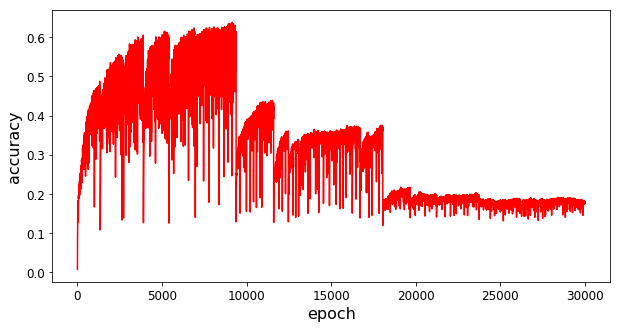

In [10]:
#plot loss function and accuracy function
acc = H.history['accuracy']
loss = H.history['loss']
plt.figure(figsize=[10,5])
font2 = {'family' : 'Times New Roman',
    'weight' : 'normal',
    'size' : 16,
    }

epochs = range(1,Nepochs+1)
 
#plt.title('Accuracy')
plt.plot(epochs, acc,'red')
plt.xlabel('epoch',font2)
plt.ylabel('accuracy',font2)
plt.tick_params(labelsize=12)

#plt.legend()
plt.show()

/home/njl/anaconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


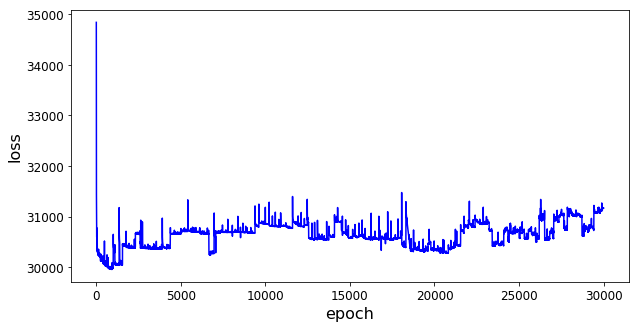

In [11]:
#plot loss function and accuracy function
 
#plt.title('Loss')
plt.figure(figsize=[10,5])
plt.plot(epochs, loss, 'blue')
plt.xlabel('epoch',font2)
plt.ylabel('loss',font2)
plt.tick_params(labelsize=12)

#plt.legend()
plt.show()